# **Lab of Information Systems and Analytics (ET7) | Project - Jacopo Lazzari 894361**

## **Summary**

### **Introduction**


The **individual project** for the course **Lab of Information Systems and Analytics** consists in applying Machine Learning to perform a predictive task starting from a given dataset to be chosen out of 3 different datasets. 

I chose to analyze the dataset related to the direct marketing campaigns of a Portuguese banking institution from the UC Irvine archive. The marketing campaigns were based on phone calls. Often, more than one contact with the same client was required, in order to assess if the product (bank term deposit) would be (`"yes"`) or not (`"no"`) subscribed. 

Link to the dataset: https://archive.ics.uci.edu/dataset/222/bank+marketing.

Sources: created by: Sérgio Moro (ISCTE-IUL), Paulo Cortez (Univ. Minho) and Paulo Rita (ISCTE-IUL) @ 2014.

There are four datasets availables: 
1) `bank-additional-full.csv` with all examples (41188) and 20 inputs, ordered by date (from May 2008 to November 2010), very close to the data analyzed in [Moro et al., 2014]
2) `bank-additional.csv` with 10% of the examples (4119), randomly selected from 1), and 20 inputs.
3) `bank-full.csv` with all examples and 17 inputs, ordered by date (older version of this dataset with less inputs). 
4) `bank.csv` with 10% of the examples and 17 inputs, randomly selected from 3 (older version of this dataset with less inputs). 
The smallest datasets are provided to test more computationally demanding machine learning algorithms (e.g., SVM). 

The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).

### **Variables**

**Bank client data:**

1) `age` (numeric)
2) `job` type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")
3) `marital` marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed)
4) `education` (categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")
5) `default` has credit in default? (categorical: "no","yes","unknown")
6) `housing` has housing loan? (categorical: "no","yes","unknown")
7) `loan` has personal loan? (categorical: "no","yes","unknown")

**Related with the last contact of the current campaign:**

8) `contact` contact communication type (categorical: "unknown","telephone","cellular") 
9) `month` last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
10) `day_of_week` last contact day of the week (categorical: "mon","tue","wed","thu","fri")
11) `duration` last contact duration, in seconds (numeric). Important note:  this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.


**Other attributes:**

12) `campaign` number of contacts performed during this campaign and for this client (numeric, includes last contact)
13) `pdays` number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14) `previous` number of contacts performed before this campaign and for this client (numeric)
15) `poutcome` outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")

**Social and economic context attributes:**

16) `emp.var.rate`: employment variation rate - quarterly indicator (numeric)
17) `cons.price.idx`: consumer price index - monthly indicator (numeric)  
18) `cons.conf.idx`: consumer confidence index - monthly indicator (numeric)   
19) `euribor3m`: euribor 3 month rate - daily indicator (numeric)
20) `nr.employed`: number of employees - quarterly indicator (numeric)

**Output variable (desired target):**

21) `y` has the client subscribed a term deposit? (binary: "yes","no")

### **Outline of the project**

Here a brief outline of the structure of the project:

`1) Dataset Loading and Cleaning`

`2) Exploratory Data Analysis (EDA)`

`3) Data Pre-Processing and Feature Engineering`

`4) Model Training and Evaluation`

`5) Conclusions`

## **1. Dataset Loading and Cleaning**

I import all the libraries needed for the project.

In [431]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, average_precision_score, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_class_weight
from sklearn.inspection import permutation_importance
from sklearn.neural_network import MLPClassifier
from sklearn.exceptions import ConvergenceWarning

Now I upload the full dataset and read the shape of the dataset.

In [432]:
df = pd.read_csv("Bank Marketing Dataset/bank-additional-full.csv", sep=';')
print('The dataset has {} rows and {} columns.'.format(df.shape[0], df.shape[1]))

The dataset has 41188 rows and 21 columns.


I read the summary of the dataset infos (columns, data types, etc.) and the first 20 rows of the dataframe to get a better understanding.

In [433]:
print(df.info())

df.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

age          job   marital            education  default housing loan  \
0    56    housemaid   married             basic.4y       no      no   no   
1    57     services   married          high.school  unknown      no   no   
2    37     services   married          high.school       no     yes   no   
3    40       admin.   married             basic.6y       no      no   no   
4    56     services   married          high.school       no      no  yes   
5    45     services   married             basic.9y  unknown      no   no   
6    59       admin.   married  professional.course       no      no   no   
7    41  blue-collar   married              unknown  unknown      no   no   
8    24   technician    single  professional.course       no     yes   no   
9    25     services    single          high.school       no     yes   no   
10   41  blue-collar   married              unknown  unknown      no   no   
11   25     services    single          high.school       no     yes   no   
12   29  blue-collar    single          high.school       no      no  yes   
13   57    housemaid  divorced             basic.4y       no     yes   no   
14   35  blue-collar   married             basic.6y       no     yes   no   
15   54      retired   married             basic.9y  unknown     yes  yes   
16   35  blue-collar   married             basic.6y       no     yes   no   
17   46  blue-collar   married             basic.6y  unknown     yes  yes   
18   50  blue-collar   married             basic.9y       no     yes  yes   
19   39   management    single             basic.9y  unknown      no   no   

      contact month day_of_week  ...  campaign  pdays  previous     poutcome  \
0   telephone   may         mon  ...         1    999         0  nonexistent   
1   telephone   may         mon  ...         1    999         0  nonexistent   
2   telephone   may         mon  ...         1    999         0  nonexistent   
3   telephone   may         mon  ...         1    999         0  nonexistent   
4   telephone   may         mon  ...         1    999         0  nonexistent   
5   telephone   may         mon  ...         1    999         0  nonexistent   
6   telephone   may         mon  ...         1    999         0  nonexistent   
7   telephone   may         mon  ...         1    999         0  nonexistent   
8   telephone   may         mon  ...         1    999         0  nonexistent   
9   telephone   may         mon  ...         1    999         0  nonexistent   
10  telephone   may         mon  ...         1    999         0  nonexistent   
11  telephone   may         mon  ...         1    999         0  nonexistent   
12  telephone   may         mon  ...         1    999         0  nonexistent   
13  telephone   may         mon  ...         1    999         0  nonexistent   
14  telephone   may         mon  ...         1    999         0  nonexistent   
15  telephone   may         mon  ...         1    999         0  nonexistent   
16  telephone   may         mon  ...         1    999         0  nonexistent   
17  telephone   may         mon  ...         1    999         0  nonexistent   
18  telephone   may         mon  ...         1    999         0  nonexistent   
19  telephone   may         mon  ...         1    999         0  nonexistent   

   emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0           1.1          93.994          -36.4      4.857       5191.0  no  
1           1.1          93.994          -36.4      4.857       5191.0  no  
2           1.1          93.994          -36.4      4.857       5191.0  no  
3           1.1          93.994          -36.4      4.857       5191.0  no  
4           1.1          93.994          -36.4      4.857       5191.0  no  
5           1.1          93.994          -36.4      4.857       5191.0  no  
6           1.1          93.994          -36.4      4.857       5191.0  no  
7           1.1          93.994          -36.4      4.857       5191.0  no  
8           

As can be seen by the first 20 rows of the dataframe, we have some "unknown" values. I count them.

In [434]:
unknown_counts = df.apply(lambda x: (x == 'unknown').sum())
print("Counts of 'unknown' values in each column:")
print(unknown_counts)

Counts of 'unknown' values in each column:
age                  0
job                330
marital             80
education         1731
default           8597
housing            990
loan               990
contact              0
month                0
day_of_week          0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
dtype: int64


I want to replace "unknown" values with `NaN` with the goal of ensuring the accuracy and reliability of the models I am going to build later on.

In [435]:
df.replace('unknown', np.nan, inplace=True)
print(df.info())
df.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             40858 non-null  object 
 2   marital         41108 non-null  object 
 3   education       39457 non-null  object 
 4   default         32591 non-null  object 
 5   housing         40198 non-null  object 
 6   loan            40198 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

age          job   marital            education default housing loan  \
0    56    housemaid   married             basic.4y      no      no   no   
1    57     services   married          high.school     NaN      no   no   
2    37     services   married          high.school      no     yes   no   
3    40       admin.   married             basic.6y      no      no   no   
4    56     services   married          high.school      no      no  yes   
5    45     services   married             basic.9y     NaN      no   no   
6    59       admin.   married  professional.course      no      no   no   
7    41  blue-collar   married                  NaN     NaN      no   no   
8    24   technician    single  professional.course      no     yes   no   
9    25     services    single          high.school      no     yes   no   
10   41  blue-collar   married                  NaN     NaN      no   no   
11   25     services    single          high.school      no     yes   no   
12   29  blue-collar    single          high.school      no      no  yes   
13   57    housemaid  divorced             basic.4y      no     yes   no   
14   35  blue-collar   married             basic.6y      no     yes   no   
15   54      retired   married             basic.9y     NaN     yes  yes   
16   35  blue-collar   married             basic.6y      no     yes   no   
17   46  blue-collar   married             basic.6y     NaN     yes  yes   
18   50  blue-collar   married             basic.9y      no     yes  yes   
19   39   management    single             basic.9y     NaN      no   no   

      contact month day_of_week  ...  campaign  pdays  previous     poutcome  \
0   telephone   may         mon  ...         1    999         0  nonexistent   
1   telephone   may         mon  ...         1    999         0  nonexistent   
2   telephone   may         mon  ...         1    999         0  nonexistent   
3   telephone   may         mon  ...         1    999         0  nonexistent   
4   telephone   may         mon  ...         1    999         0  nonexistent   
5   telephone   may         mon  ...         1    999         0  nonexistent   
6   telephone   may         mon  ...         1    999         0  nonexistent   
7   telephone   may         mon  ...         1    999         0  nonexistent   
8   telephone   may         mon  ...         1    999         0  nonexistent   
9   telephone   may         mon  ...         1    999         0  nonexistent   
10  telephone   may         mon  ...         1    999         0  nonexistent   
11  telephone   may         mon  ...         1    999         0  nonexistent   
12  telephone   may         mon  ...         1    999         0  nonexistent   
13  telephone   may         mon  ...         1    999         0  nonexistent   
14  telephone   may         mon  ...         1    999         0  nonexistent   
15  telephone   may         mon  ...         1    999         0  nonexistent   
16  telephone   may         mon  ...         1    999         0  nonexistent   
17  telephone   may         mon  ...         1    999         0  nonexistent   
18  telephone   may         mon  ...         1    999         0  nonexistent   
19  telephone   may         mon  ...         1    999         0  nonexistent   

   emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0           1.1          93.994          -36.4      4.857       5191.0  no  
1           1.1          93.994          -36.4      4.857       5191.0  no  
2           1.1          93.994          -36.4      4.857       5191.0  no  
3           1.1          93.994          -36.4      4.857       5191.0  no  
4           1.1          93.994          -36.4      4.857       5191.0  no  
5           1.1          93.994          -36.4      4.857       5191.0  no  
6           1.1          93.994          -36.4      4.857       5191.0  no  
7           1.1          93.994          -36.4      4.857       5191.0  no  
8           1.1          93.994  

I study the `NaN` distribution across the various columns by computing the percentage of `NaN` values in each column. 

Percentage of NaN values in each column:
age                0.000000
job                0.801204
marital            0.194231
education          4.202680
default           20.872584
housing            2.403613
loan               2.403613
contact            0.000000
month              0.000000
day_of_week        0.000000
duration           0.000000
campaign           0.000000
pdays              0.000000
previous           0.000000
poutcome           0.000000
emp.var.rate       0.000000
cons.price.idx     0.000000
cons.conf.idx      0.000000
euribor3m          0.000000
nr.employed        0.000000
y                  0.000000
dtype: float64


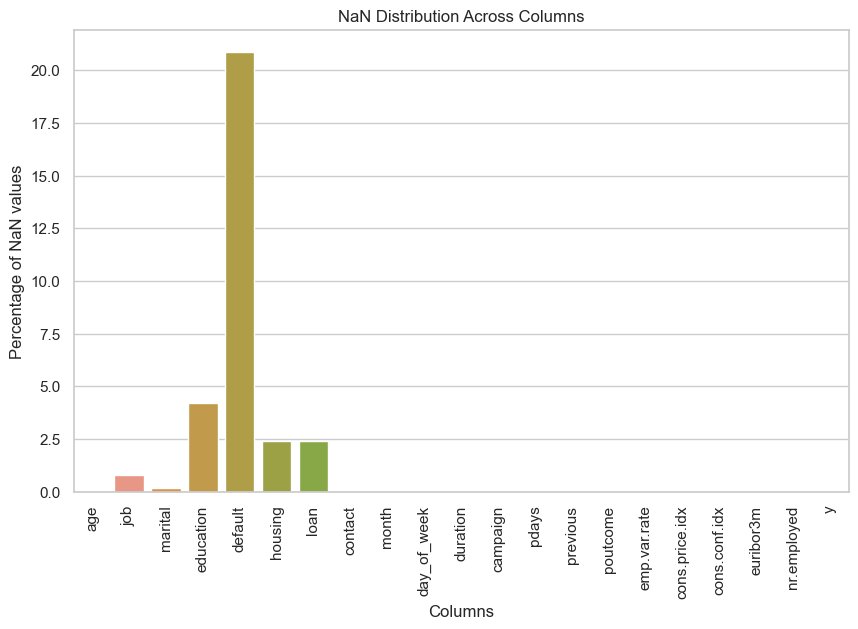

In [436]:
nan_percentage = df.isna().mean() * 100
print("Percentage of NaN values in each column:")
print(nan_percentage)

plt.figure(figsize=(10, 6))
sns.barplot(x=nan_percentage.index, y=nan_percentage.values)
plt.xticks(rotation=90)
plt.xlabel('Columns')
plt.ylabel('Percentage of NaN values')
plt.title('NaN Distribution Across Columns')
plt.show()

`default`, `education`, `housing` and `loan`are the columns with more `NaN`, with `default` with more than 20% of its values. I studied the distribution of the `NaN` values across rows, now I want to count how many rows in total do and do not have `NaN` values and wheter they influence the final result of the outcome. That is, whether the answer to the question "has the client subscribed a term deposit?" has more or less "yes" or "no" values in rows with or without `NaN` values.

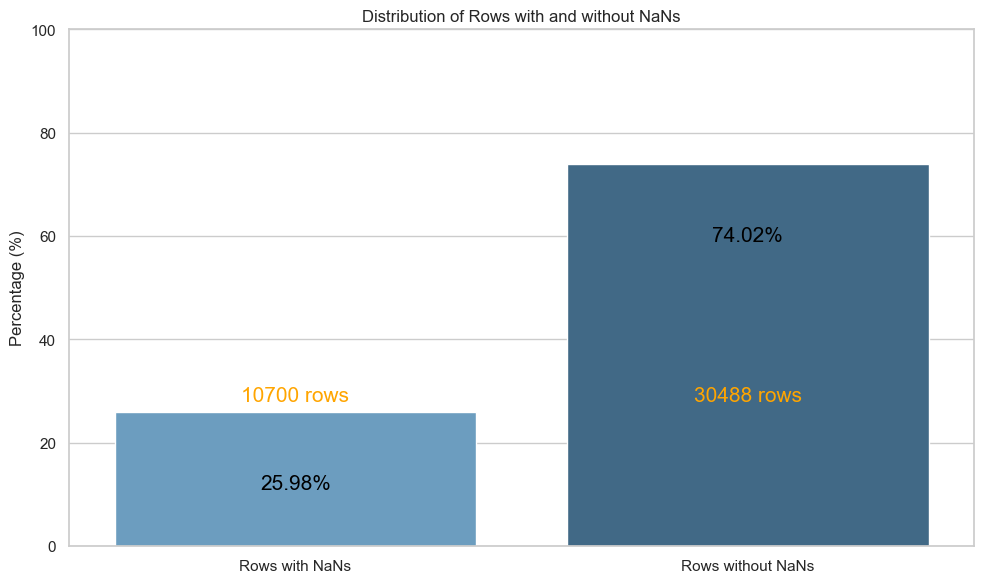

In [437]:
# Count NaNs per row
nan_counts_per_row = df.isnull().sum(axis=1)
total_rows = len(df)

# Count rows with NaNs and without NaNs
rows_with_nans = (nan_counts_per_row > 0).sum()
rows_without_nans = total_rows - rows_with_nans

# Calculate percentages
with_nans_percent = rows_with_nans / total_rows * 100
without_nans_percent = rows_without_nans / total_rows * 100

# Plotting the stacked 100% bar chart
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Plotting
bar_plot = sns.barplot(x=['Rows with NaNs', 'Rows without NaNs'], y=[with_nans_percent, without_nans_percent], palette="Blues_d")
plt.title('Distribution of Rows with and without NaNs')
plt.ylabel('Percentage (%)')
plt.ylim(0, 100)  # Ensure the y-axis starts at 0 and ends at 100

# Add counts on top of bars
for i, v in enumerate([rows_with_nans, rows_without_nans]):
    bar_plot.text(i, with_nans_percent + 5, f'{v} rows', ha='center', va='top', fontsize=15, color='orange')

# Add percentages on top of bars
for i, v in enumerate([with_nans_percent, without_nans_percent]):
    plt.text(i, v - 15, f"{v:.2f}%", ha='center', va='baseline', fontsize=15, color='black')

plt.tight_layout()
plt.show()

We have one quarter of the total rows with `NaN` values. Let's their influence on results.

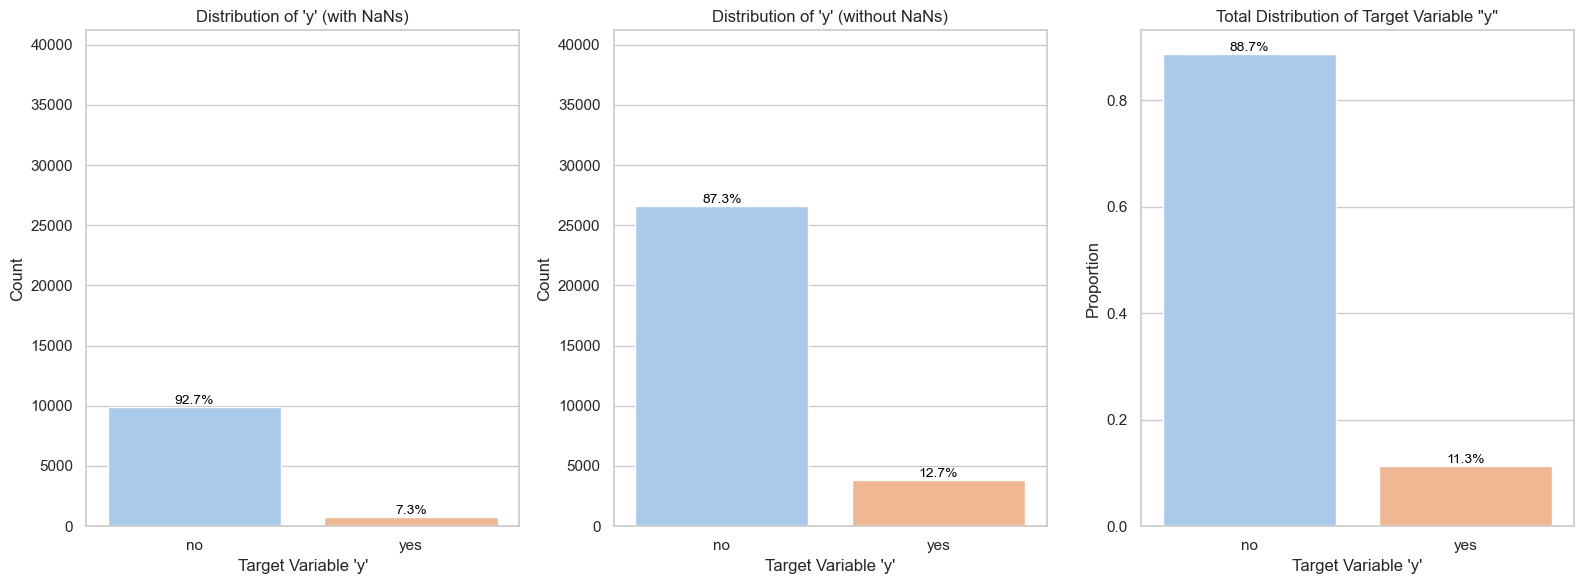

In [438]:
# Count NaNs per row
nan_counts_per_row = df.isnull().sum(axis=1)
total_rows = len(df)

# Analyze relationship with target variable 'y'
nan_rows_y = df.loc[nan_counts_per_row > 0, 'y']
non_nan_rows_y = df.loc[nan_counts_per_row == 0, 'y']

# Total 'y' variable distribution
total_y_distribution = df['y'].value_counts(normalize=True)

# Plotting
plt.figure(figsize=(16, 6))

# Plot 1: Distribution of 'y' with NaNs
plt.subplot(1, 3, 1)
sns.countplot(x='y', data=df.loc[nan_counts_per_row > 0], palette='pastel')
plt.title("Distribution of 'y' (with NaNs)")
plt.xlabel("Target Variable 'y'")
plt.ylabel("Count")
plt.ylim(0, df.shape[0])  # Set y-axis limit to total number of rows

# Add percentages as text annotations
total_nan_rows = nan_rows_y.shape[0]
for p in plt.gca().patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total_nan_rows)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    plt.text(x, y, percentage, ha='center', va='bottom', fontsize=10, color='black')

# Plot 2: Distribution of 'y' without NaNs
plt.subplot(1, 3, 2)
sns.countplot(x='y', data=df.loc[nan_counts_per_row == 0], palette='pastel')
plt.title("Distribution of 'y' (without NaNs)")
plt.xlabel("Target Variable 'y'")
plt.ylabel("Count")
plt.ylim(0, df.shape[0])  # Set y-axis limit to total number of rows

# Add percentages as text annotations
total_non_nan_rows = non_nan_rows_y.shape[0]
for p in plt.gca().patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total_non_nan_rows)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    plt.text(x, y, percentage, ha='center', va='bottom', fontsize=10, color='black')

# Plot 3: Total 'y' variable distribution
plt.subplot(1, 3, 3)
sns.barplot(x=total_y_distribution.index, y=total_y_distribution.values, palette='pastel')
plt.title('Total Distribution of Target Variable "y"')
plt.xlabel("Target Variable 'y'")
plt.ylabel("Proportion")

# Add percentages as text annotations
for i, val in enumerate(total_y_distribution.values):
    percentage = '{:.1f}%'.format(val * 100)
    plt.text(i, val, percentage, ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()

It seems that `NaN` values have just a small impact on whether the outcome is "yes" or "no" with a delta of just 4% with respect to the total distribution of target variable "y".

Now I have to decide whether to keep `NaN` values or drop them. I could keep them to preserve the sample size and maybe avoiding bais but I could also remove them to ensure that the analysis accurately reflects the full data and because some ML algorithms may not handle `NaN` values well, impacting my models.

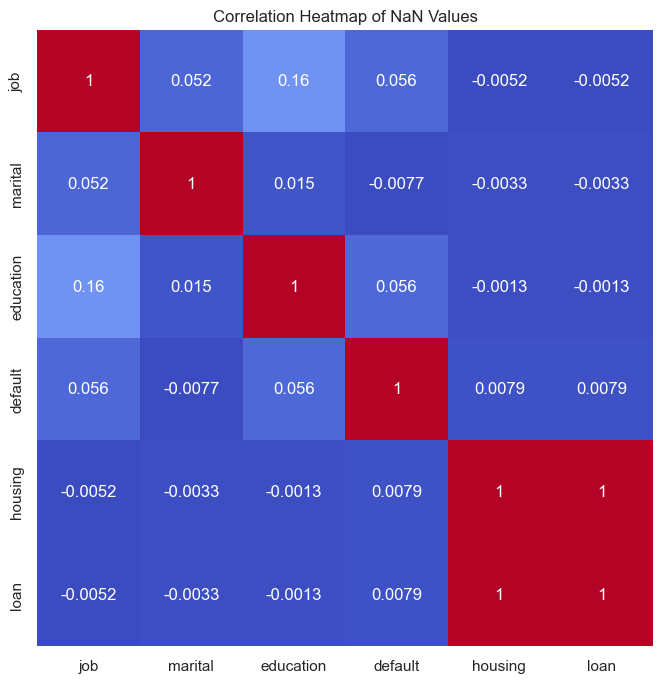

In [439]:
# Calculate which columns have NaN values
columns_with_nans = df.columns[df.isnull().any()]

# Filter the DataFrame to include only columns with NaN values
df_with_nans = df[columns_with_nans]

# Calculate NaN correlation matrix
nan_correlation = df_with_nans.isnull().corr()

# Plot the NaN correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(nan_correlation, annot=True, cmap='coolwarm', cbar=False, square=True)
plt.title('Correlation Heatmap of NaN Values')
plt.show()

I chose to drop `NaN` values (around 11k values out of 41k) because neutral correlations between `NaN` values across columns indicated that missing data was random. I believe this approach best preserves data integrity, avoids biases from imputation, and ensures reliable analyses and model performance.

In [440]:
# Drop rows with NaN values
df_clean = df.dropna()
print(df_clean.info())
df_clean.head(20)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30488 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             30488 non-null  int64  
 1   job             30488 non-null  object 
 2   marital         30488 non-null  object 
 3   education       30488 non-null  object 
 4   default         30488 non-null  object 
 5   housing         30488 non-null  object 
 6   loan            30488 non-null  object 
 7   contact         30488 non-null  object 
 8   month           30488 non-null  object 
 9   day_of_week     30488 non-null  object 
 10  duration        30488 non-null  int64  
 11  campaign        30488 non-null  int64  
 12  pdays           30488 non-null  int64  
 13  previous        30488 non-null  int64  
 14  poutcome        30488 non-null  object 
 15  emp.var.rate    30488 non-null  float64
 16  cons.price.idx  30488 non-null  float64
 17  cons.conf.idx   30488 non-null 

age          job   marital            education default housing loan  \
0    56    housemaid   married             basic.4y      no      no   no   
2    37     services   married          high.school      no     yes   no   
3    40       admin.   married             basic.6y      no      no   no   
4    56     services   married          high.school      no      no  yes   
6    59       admin.   married  professional.course      no      no   no   
8    24   technician    single  professional.course      no     yes   no   
9    25     services    single          high.school      no     yes   no   
11   25     services    single          high.school      no     yes   no   
12   29  blue-collar    single          high.school      no      no  yes   
13   57    housemaid  divorced             basic.4y      no     yes   no   
14   35  blue-collar   married             basic.6y      no     yes   no   
16   35  blue-collar   married             basic.6y      no     yes   no   
18   50  blue-collar   married             basic.9y      no     yes  yes   
20   30   unemployed   married          high.school      no      no   no   
22   55      retired    single          high.school      no     yes   no   
23   41   technician    single          high.school      no     yes   no   
24   37       admin.   married          high.school      no     yes   no   
25   35   technician   married    university.degree      no      no  yes   
34   54  blue-collar  divorced             basic.4y      no      no   no   
36   34     services   married          high.school      no      no   no   

      contact month day_of_week  ...  campaign  pdays  previous     poutcome  \
0   telephone   may         mon  ...         1    999         0  nonexistent   
2   telephone   may         mon  ...         1    999         0  nonexistent   
3   telephone   may         mon  ...         1    999         0  nonexistent   
4   telephone   may         mon  ...         1    999         0  nonexistent   
6   telephone   may         mon  ...         1    999         0  nonexistent   
8   telephone   may         mon  ...         1    999         0  nonexistent   
9   telephone   may         mon  ...         1    999         0  nonexistent   
11  telephone   may         mon  ...         1    999         0  nonexistent   
12  telephone   may         mon  ...         1    999         0  nonexistent   
13  telephone   may         mon  ...         1    999         0  nonexistent   
14  telephone   may         mon  ...         1    999         0  nonexistent   
16  telephone   may         mon  ...         1    999         0  nonexistent   
18  telephone   may         mon  ...         1    999         0  nonexistent   
20  telephone   may         mon  ...         1    999         0  nonexistent   
22  telephone   may         mon  ...         1    999         0  nonexistent   
23  telephone   may         mon  ...         1    999         0  nonexistent   
24  telephone   may         mon  ...         1    999         0  nonexistent   
25  telephone   may         mon  ...         1    999         0  nonexistent   
34  telephone   may         mon  ...         1    999         0  nonexistent   
36  telephone   may         mon  ...         1    999         0  nonexistent   

   emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0           1.1          93.994          -36.4      4.857       5191.0  no  
2           1.1          93.994          -36.4      4.857       5191.0  no  
3           1.1          93.994          -36.4      4.857       5191.0  no  
4           1.1          93.994          -36.4      4.857       5191.0  no  
6           1.1          93.994          -36.4      4.857       5191.0  no  
8           1.1          93.994          -36.4      4.857       5191.0  no  
9           1.1          93.994          -36.4      4.857       5191.0  no  
11          1.1          93.994          -36.4      4.857       5191.0  no  
12          1.1          93.994  

## **2. Exploratory Data Analysis**

In [441]:
bank = df_clean
bank.head()

age        job  marital            education default housing loan  \
0   56  housemaid  married             basic.4y      no      no   no   
2   37   services  married          high.school      no     yes   no   
3   40     admin.  married             basic.6y      no      no   no   
4   56   services  married          high.school      no      no  yes   
6   59     admin.  married  professional.course      no      no   no   

     contact month day_of_week  ...  campaign  pdays  previous     poutcome  \
0  telephone   may         mon  ...         1    999         0  nonexistent   
2  telephone   may         mon  ...         1    999         0  nonexistent   
3  telephone   may         mon  ...         1    999         0  nonexistent   
4  telephone   may         mon  ...         1    999         0  nonexistent   
6  telephone   may         mon  ...         1    999         0  nonexistent   

  emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0          1.1          93.994          -36.4      4.857       5191.0  no  
2          1.1          93.994          -36.4      4.857       5191.0  no  
3          1.1          93.994          -36.4      4.857       5191.0  no  
4          1.1          93.994          -36.4      4.857       5191.0  no  
6          1.1          93.994          -36.4      4.857       5191.0  no  

[5 rows x 21 columns]

As seen before, the data frame is composed of both numerical and categorical data. I need to better understand how they are distributed and which kind of data I actually have on hand to choose if it is the case to drop some attributes or do some transformations on the data frame.

In [442]:
# Identify numerical and categorical columns
numerical_cols = bank.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = bank.select_dtypes(include=['object', 'category']).columns

# Count the number of numerical and categorical columns
num_numerical = len(numerical_cols)
num_categorical = len(categorical_cols)

print(f"Number of numerical features: {num_numerical}")
print(f"Number of categorical features: {num_categorical}")

# Optional: print the actual column names if needed
print("Numerical columns:", list(numerical_cols))
print("Categorical columns:", list(categorical_cols))

Number of numerical features: 10
Number of categorical features: 11
Numerical columns: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
Categorical columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']


I have 10 numerical features and 11 categorical features. Before going deeper in the separate analysis of both of them, I want to have a look at their distributions.

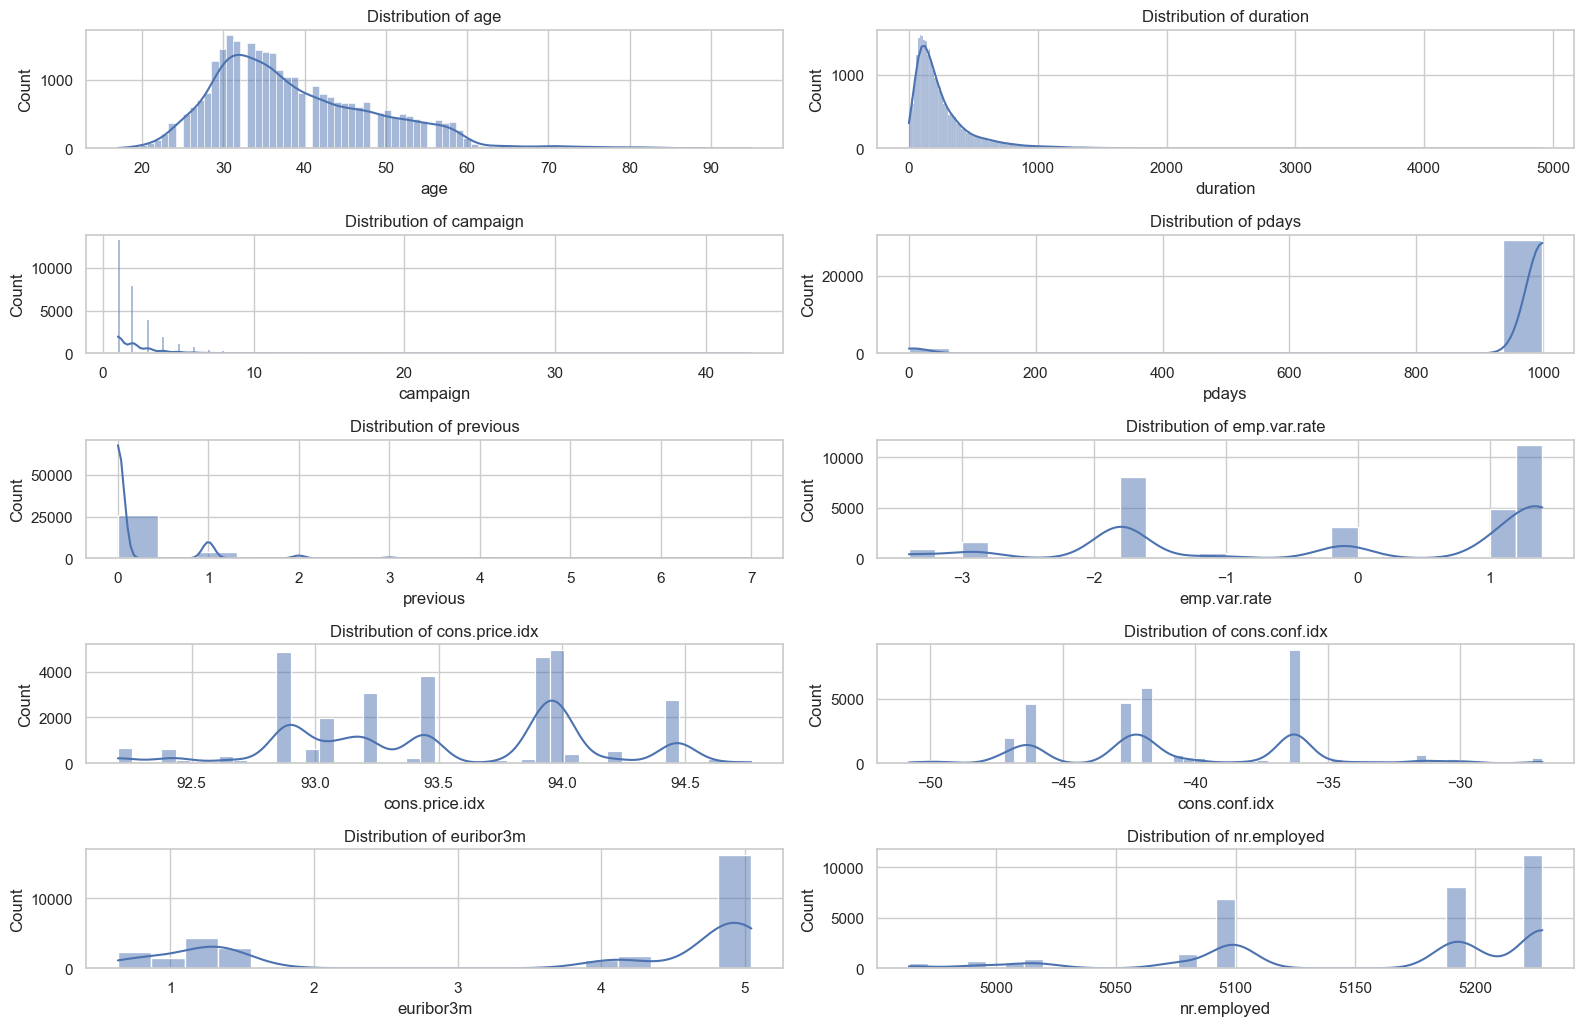

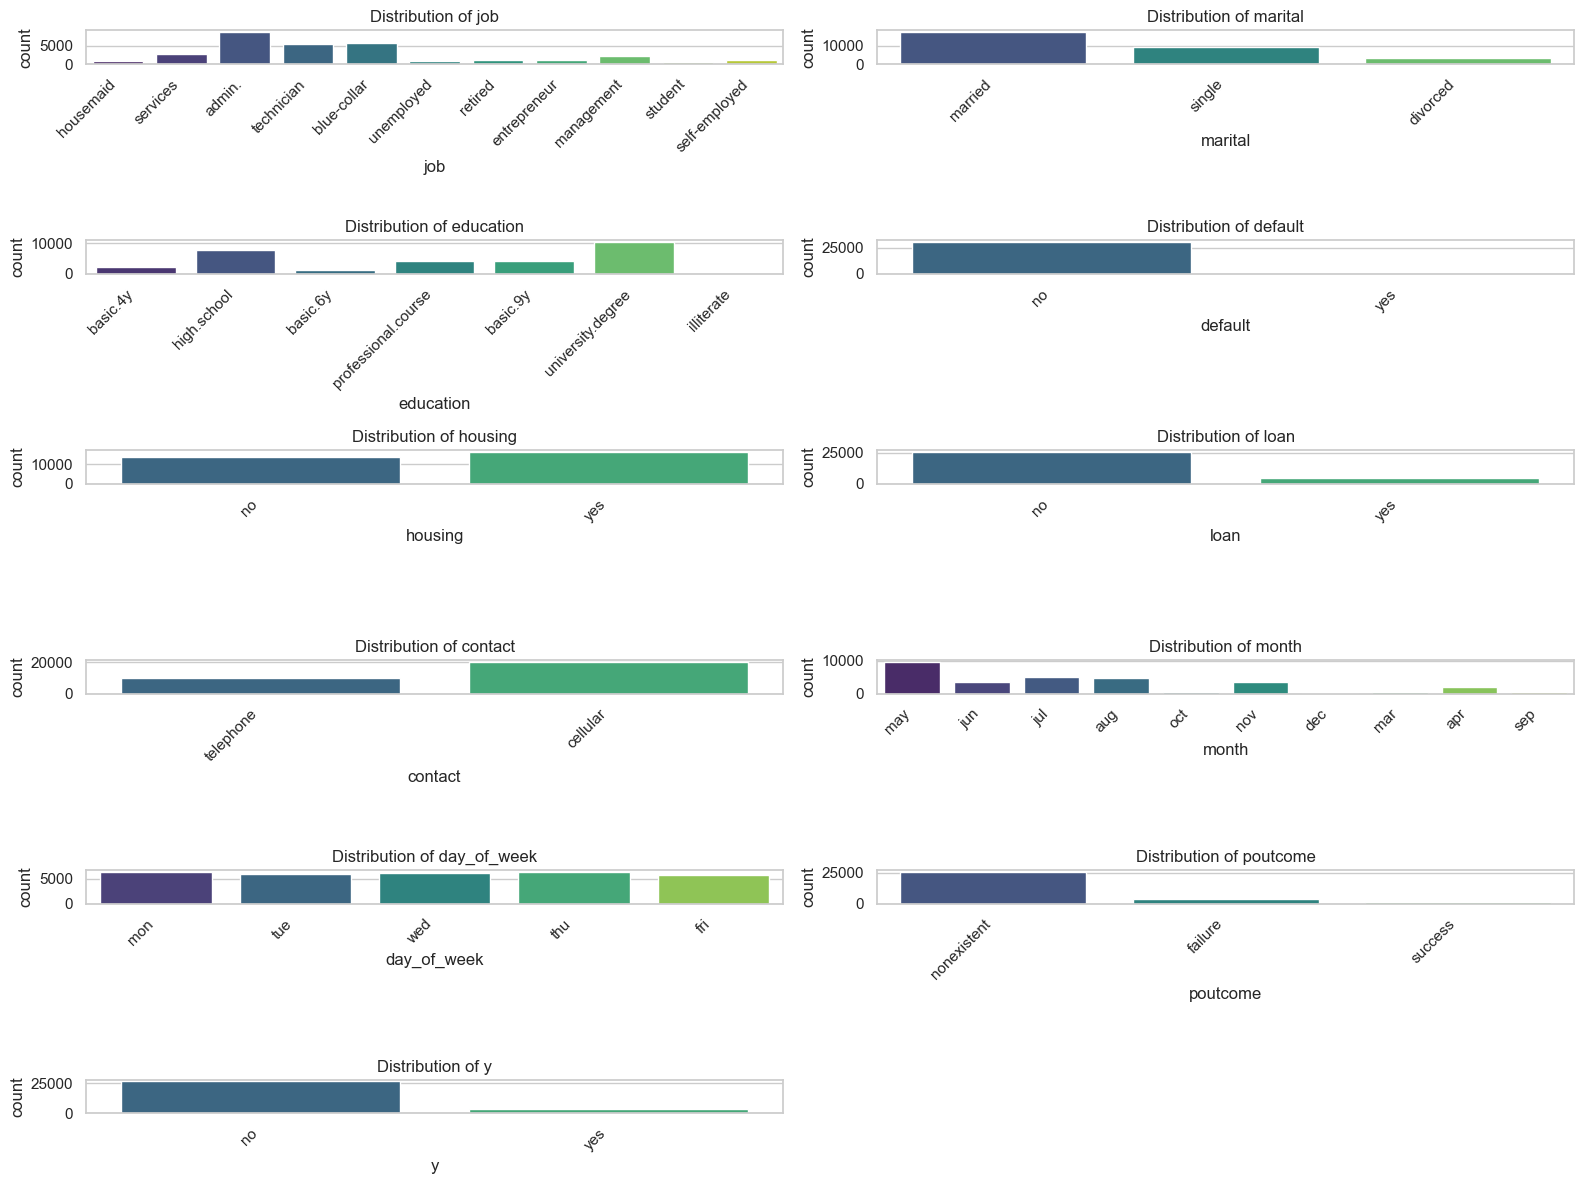

In [443]:
# Plot distribution of numerical columns
plt.figure(figsize=(16, 12))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(len(numerical_cols) // 2 + 1, 2, i)
    sns.histplot(bank[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# Plot distribution of categorical columns
plt.figure(figsize=(16, 12))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(len(categorical_cols) // 2 + 1, 2, i)
    sns.countplot(x=col, data=bank, palette='viridis')
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### **Numerical Features**

Now let's focus on **numerical features**. I would like to have a summary of the statistics for the **numerical features** of my data frame. The function below describes common statistical measures as mean, standard deviation, min/max values and percentiles.

In [444]:
# Compute summary statistics and transpose
summary_stats = bank.describe().transpose()
summary_stats

count         mean         std       min       25%  \
age             30488.0    39.030012   10.333529    17.000    31.000   
duration        30488.0   259.484092  261.714262     0.000   103.000   
campaign        30488.0     2.521451    2.720150     1.000     1.000   
pdays           30488.0   956.332295  201.373292     0.000   999.000   
previous        30488.0     0.194273    0.522788     0.000     0.000   
emp.var.rate    30488.0    -0.071510    1.610399    -3.400    -1.800   
cons.price.idx  30488.0    93.523311    0.585374    92.201    93.075   
cons.conf.idx   30488.0   -40.602263    4.789249   -50.800   -42.700   
euribor3m       30488.0     3.459938    1.777231     0.634     1.313   
nr.employed     30488.0  5160.813409   75.158065  4963.600  5099.100   

                     50%       75%       max  
age               37.000    45.000    95.000  
duration         181.000   321.000  4918.000  
campaign           2.000     3.000    43.000  
pdays            999.000   999.000   999.000  
previous           0.000     0.000     7.000  
emp.var.rate       1.100     1.400     1.400  
cons.price.idx    93.444    93.994    94.767  
cons.conf.idx    -41.800   -36.400   -26.900  
euribor3m          4.856     4.961     5.045  
nr.employed     5191.000  5228.100  5228.100

Let's plot the means and sd of the numerical features.

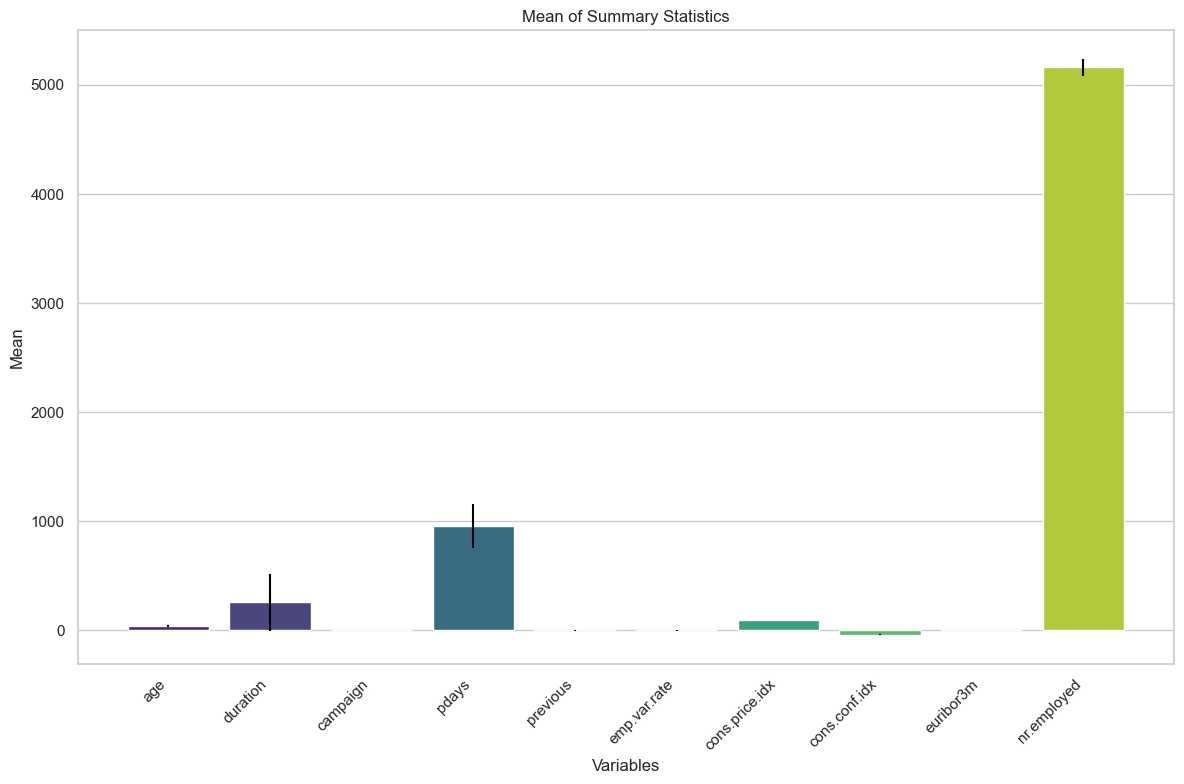

In [445]:
# Plotting
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Plotting barplot
sns.barplot(x=summary_stats.index, y='mean', data=summary_stats, palette='viridis')
plt.title('Mean of Summary Statistics')
plt.xlabel('Variables')
plt.ylabel('Mean')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility

# Add error bars (standard deviation)
plt.errorbar(x=summary_stats.index, y=summary_stats['mean'], yerr=summary_stats['std'], fmt='none', ecolor='black')

plt.tight_layout()
plt.show()

We have very different values since they represent different features.  Let's take a look at the distribution of each single **numerical feature**.

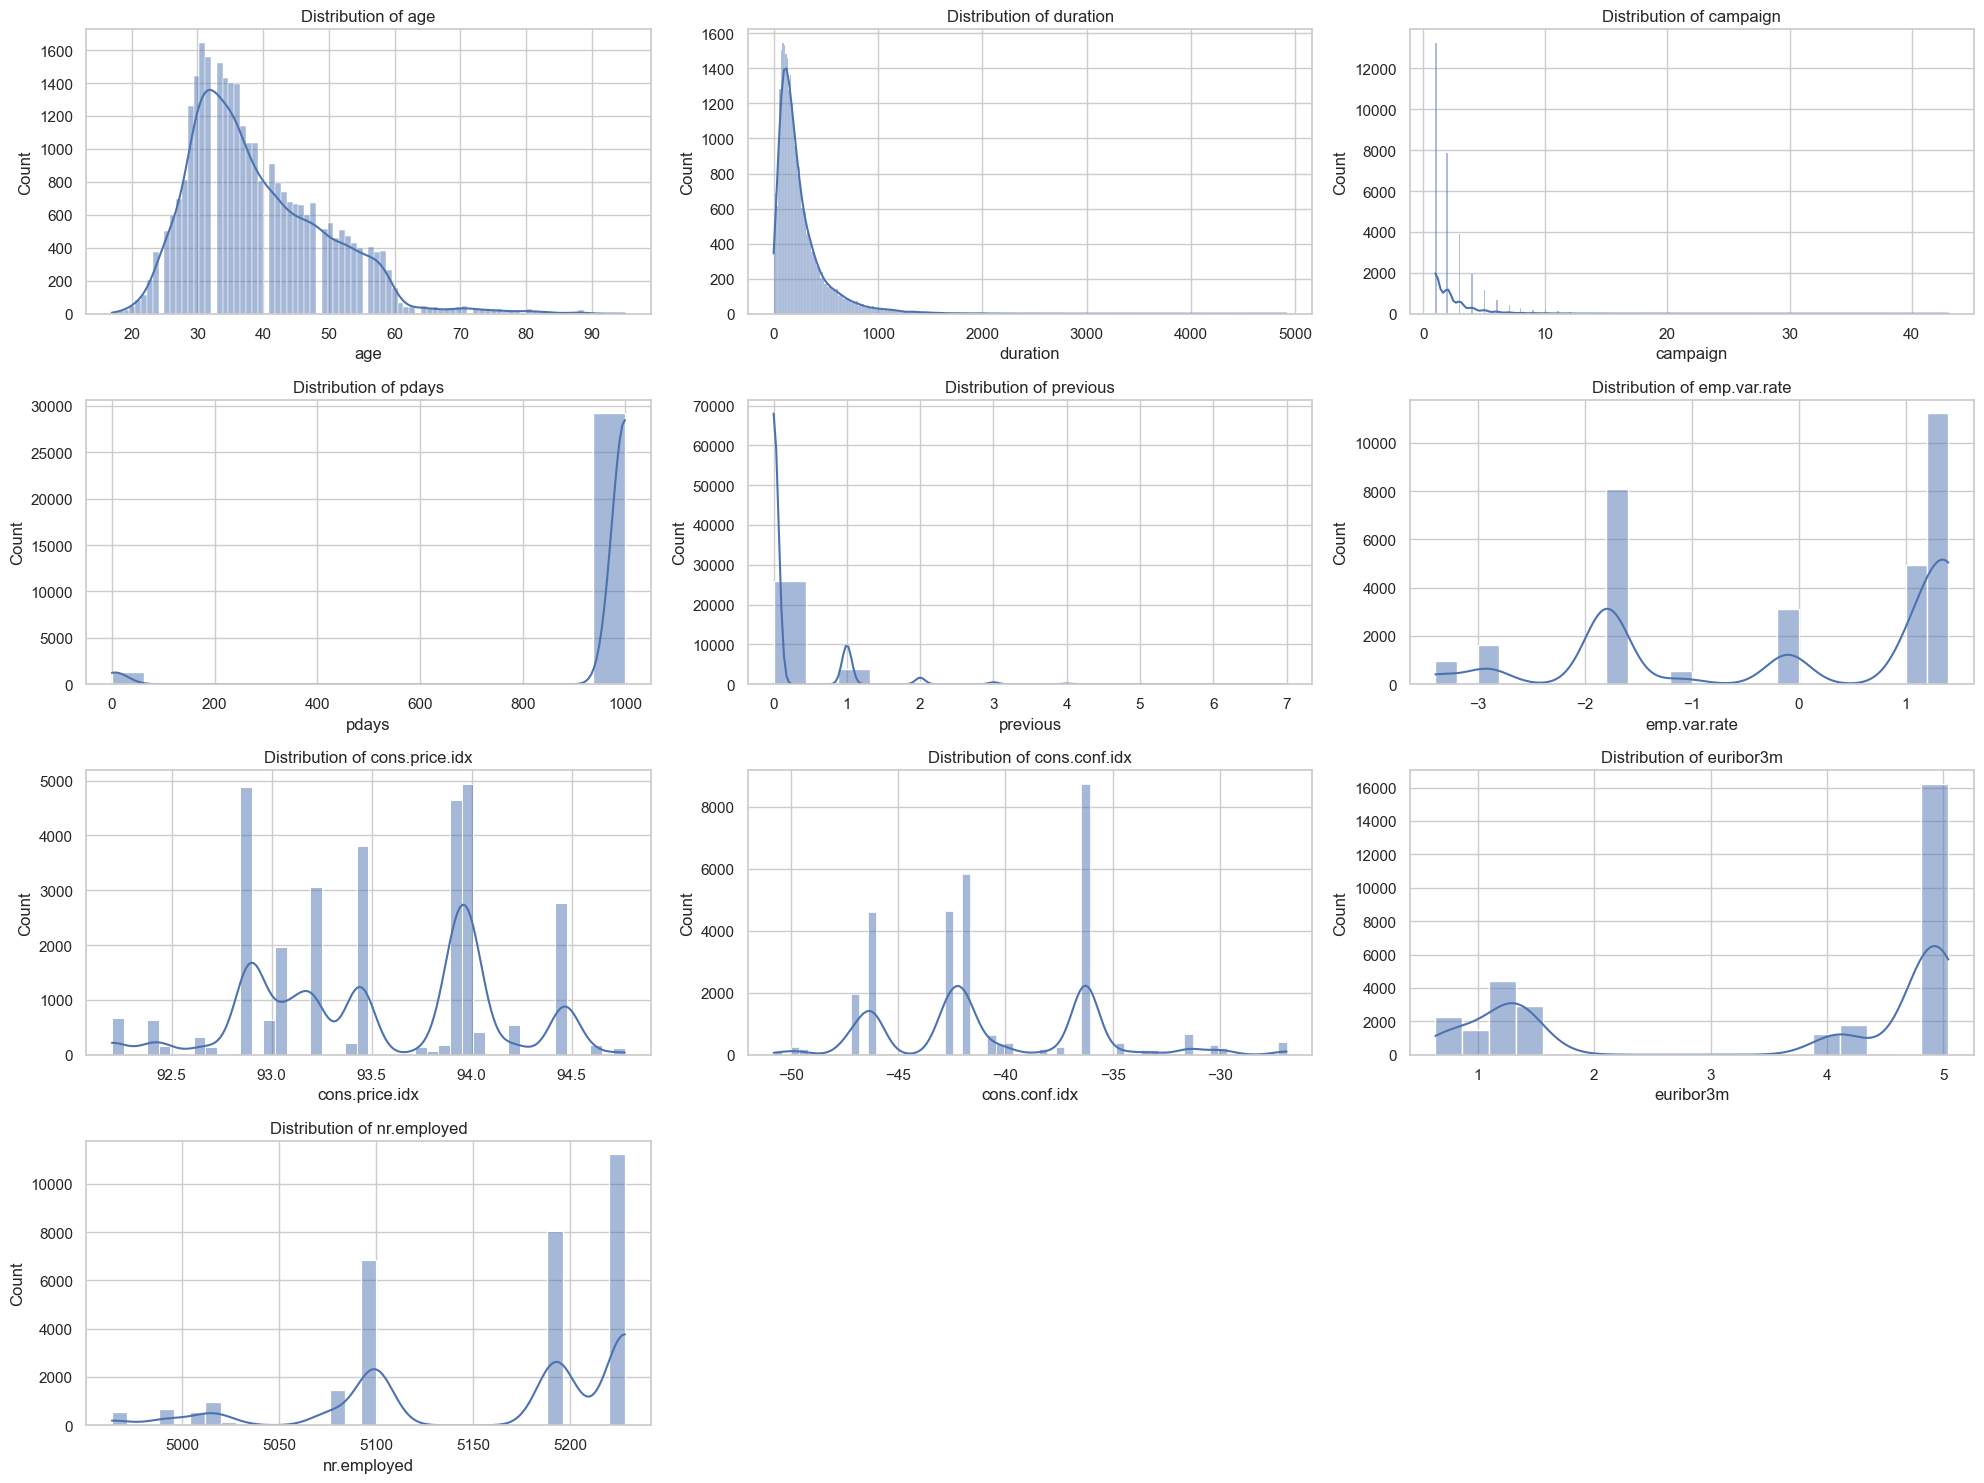

In [446]:
# Set up the matplotlib figure
plt.figure(figsize=(20, 15))

# Loop through each numerical column and plot its distribution
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(len(numerical_cols) // 3 + 1, 3, i)
    sns.histplot(bank[col], kde=True)
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

Let's go on with the analysis of **numerical features** by plotting a combination of histograms with KDE plots, box plots, and standalone KDE plots for each numerical feature in the dataframe. These visualizations help understand the distribution, central tendency, spread, and density of each numerical variable.

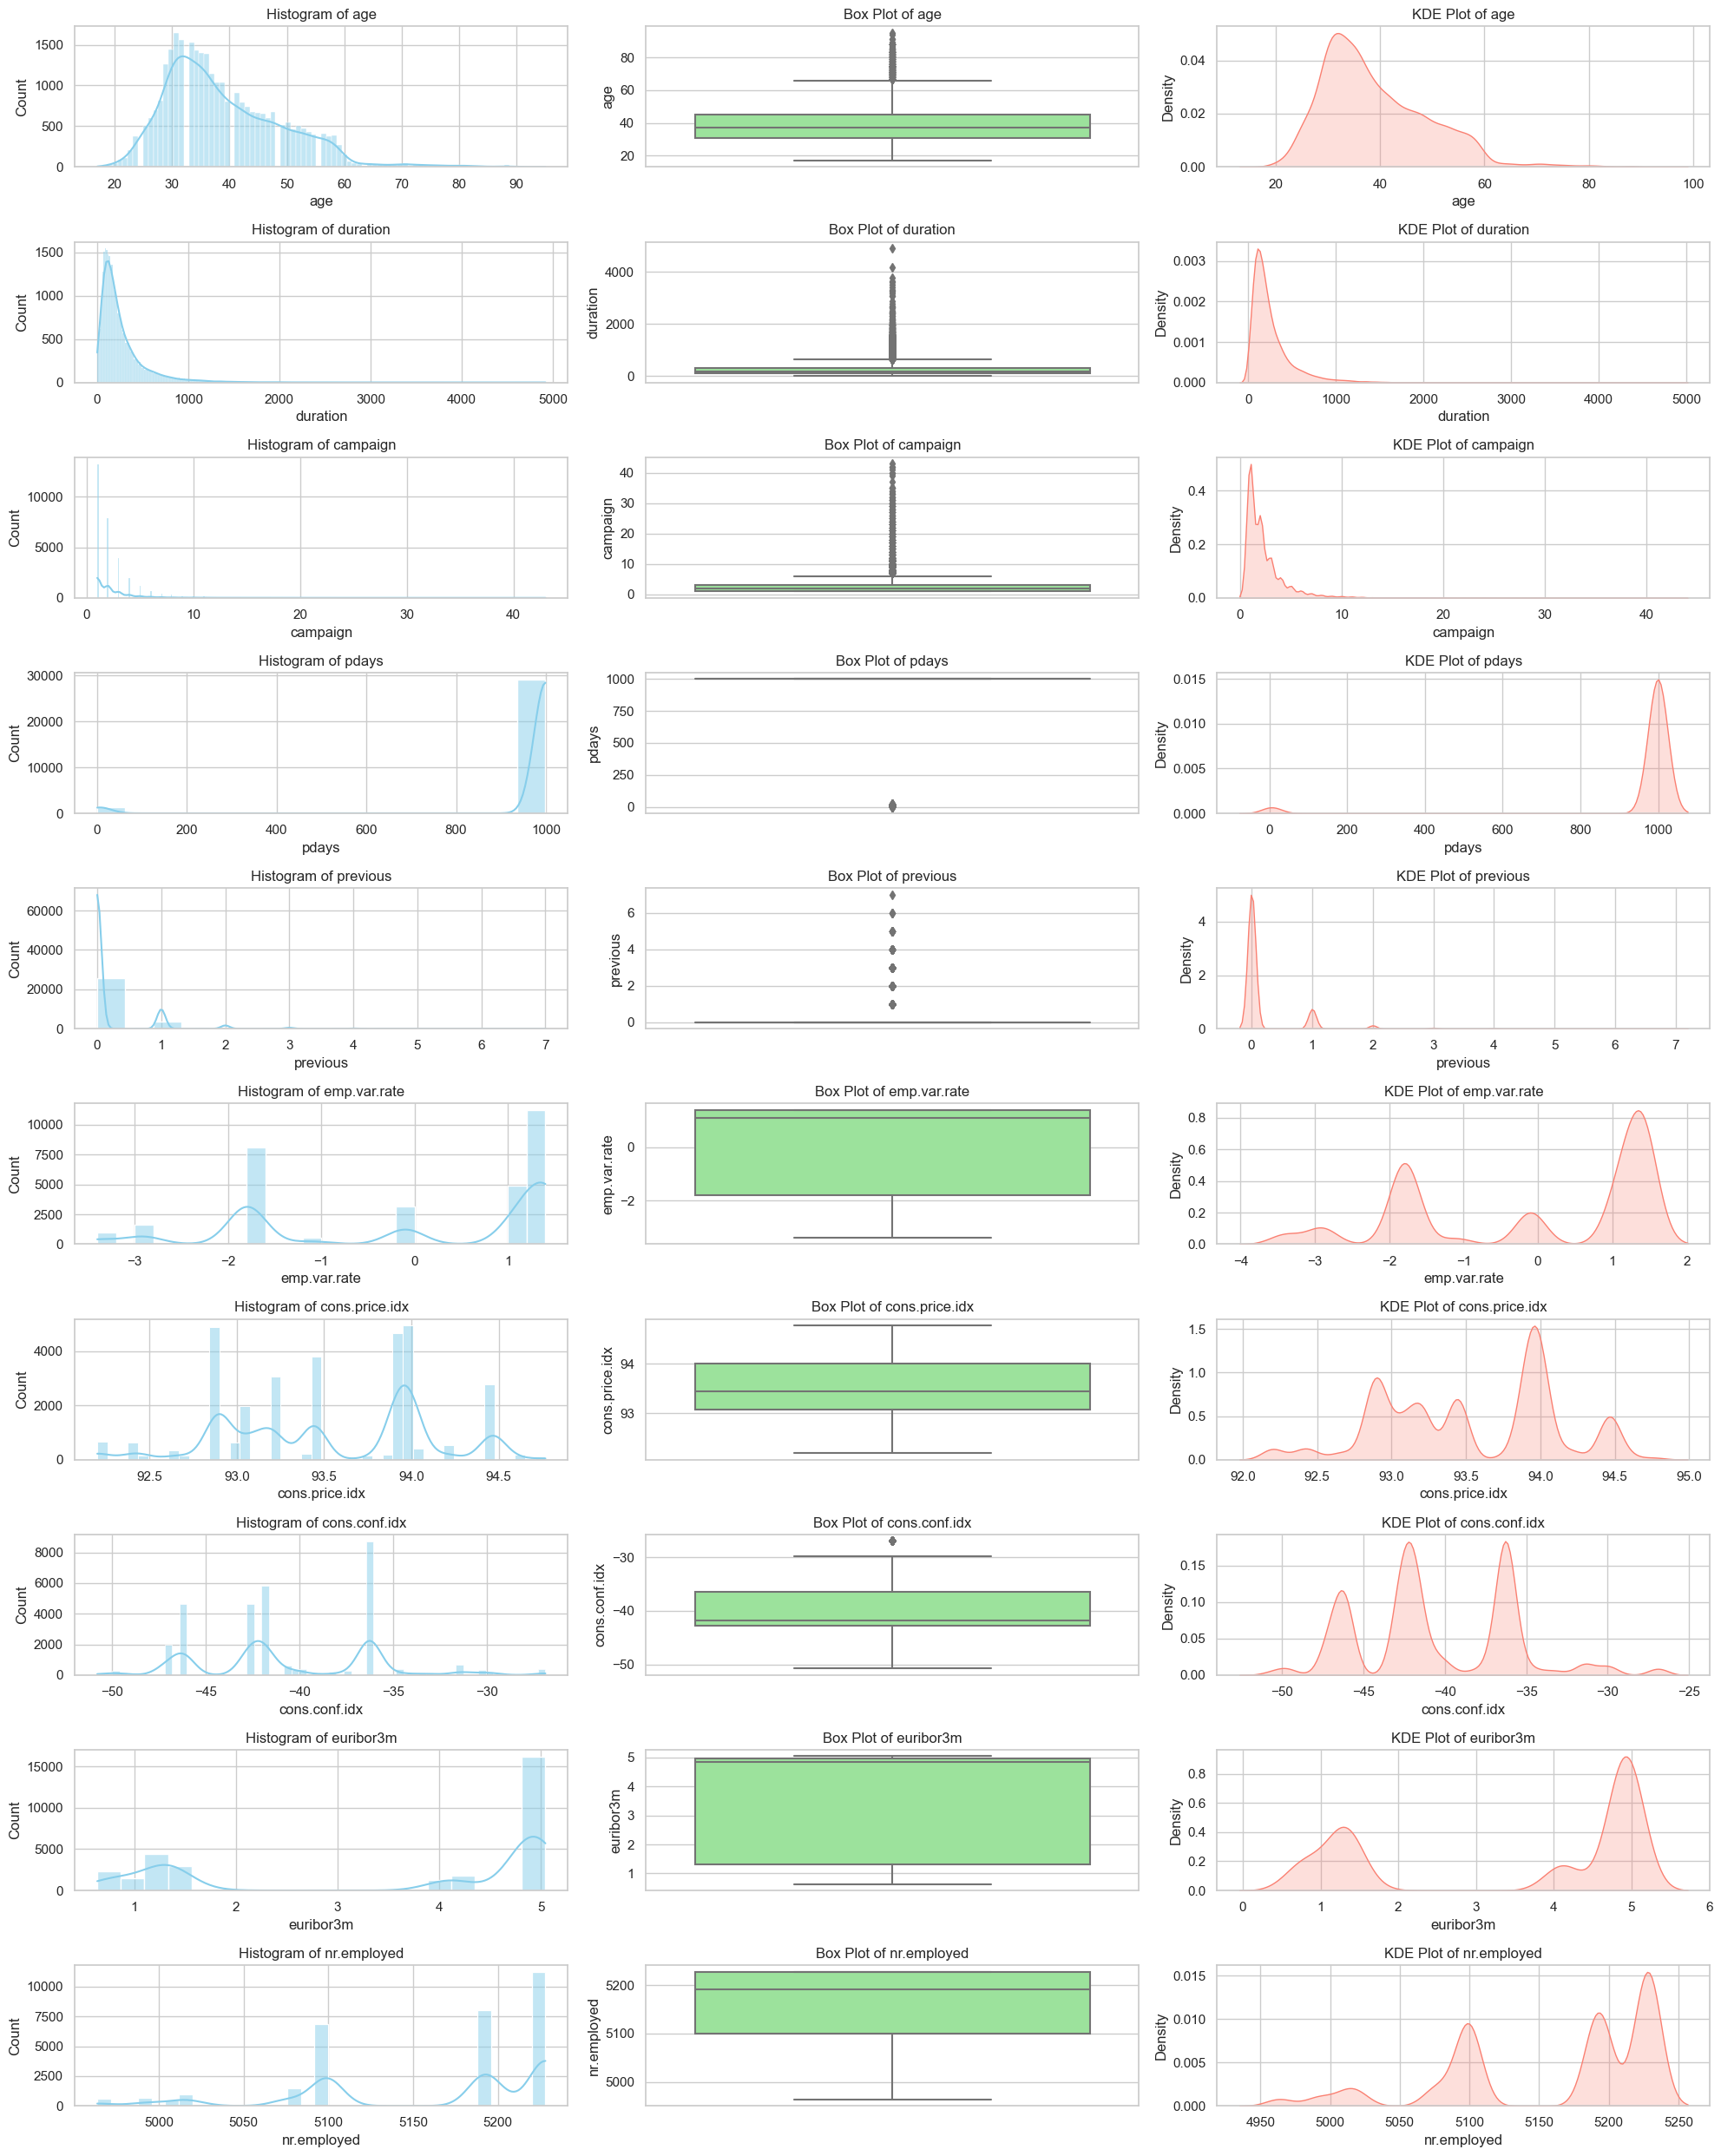

In [447]:
plt.figure(figsize=(20, 25))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(len(numerical_cols), 3, 3*i-2)
    sns.histplot(bank[col], kde=True, color='skyblue')
    plt.title(f'Histogram of {col}')
    
    plt.subplot(len(numerical_cols), 3, 3*i-1)
    sns.boxplot(y=bank[col], color='lightgreen')
    plt.title(f'Box Plot of {col}')
    
    plt.subplot(len(numerical_cols), 3, 3*i)
    sns.kdeplot(bank[col], fill=True, color='salmon')
    plt.title(f'KDE Plot of {col}')
    
plt.tight_layout()
plt.show()

I study the correlation between the **numerical features**.

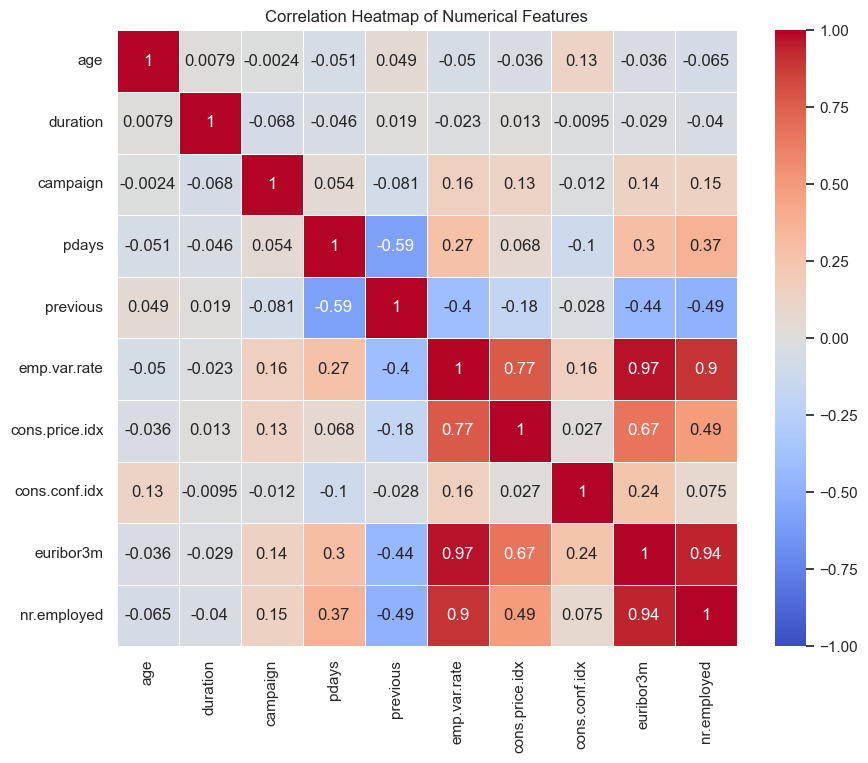

Highly Correlated Features (threshold > +- 0.75):
emp.var.rate and cons.price.idx: correlation = 0.77
emp.var.rate and euribor3m: correlation = 0.97
emp.var.rate and nr.employed: correlation = 0.90
cons.price.idx and emp.var.rate: correlation = 0.77
euribor3m and emp.var.rate: correlation = 0.97
euribor3m and nr.employed: correlation = 0.94
nr.employed and emp.var.rate: correlation = 0.90
nr.employed and euribor3m: correlation = 0.94


In [448]:
# Calculate the correlation matrix
correlation_matrix = bank[numerical_cols].corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

# Identify highly correlated features
threshold = 0.75
highly_correlated_features = [(i, j, correlation_matrix.loc[i, j]) 
                              for i in correlation_matrix.columns 
                              for j in correlation_matrix.columns 
                              if i != j and abs(correlation_matrix.loc[i, j]) > threshold]

print("Highly Correlated Features (threshold > +- 0.75):")
for i, j, corr in highly_correlated_features:
    print(f"{i} and {j}: correlation = {corr:.2f}")

I have a few variables that are highly correlated with each other. 

Since `emp.var.rate` is highly correlated with `cons.price.idx`, `euribor3m` and `nr.employed`, I choose to keep `emp.var.rate` for its strong economic implications (it is the quarterly variation in the employment rate (∆%)), while dropping the other three.

In [449]:
# Remove 'euribor3m' and 'nr.employed' as they have high correlation with 'emp.var.rate'
features_to_drop = ['euribor3m', 'nr.employed', 'cons.price.idx']
bank_reduced = bank.drop(columns=features_to_drop)

Reduced dataframe shape: (30488, 18)


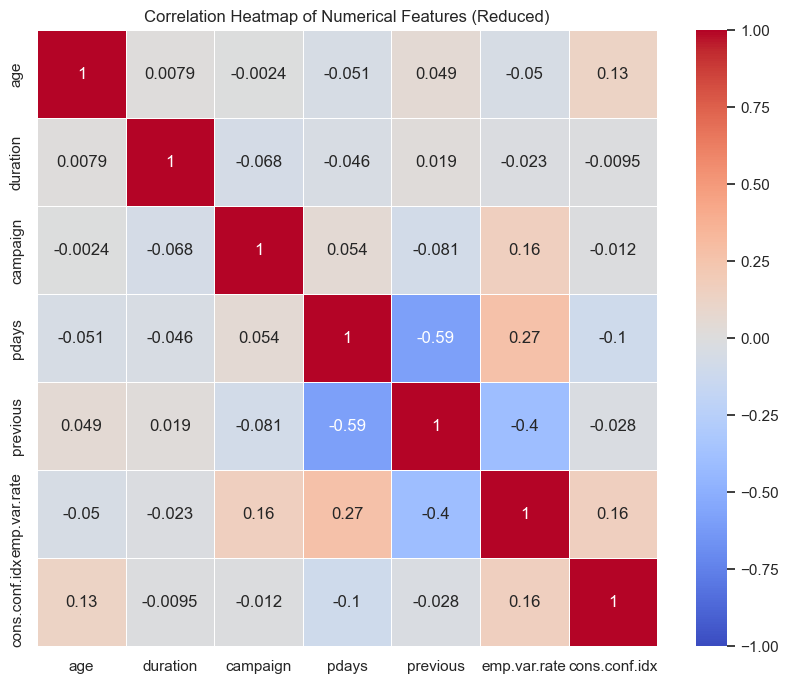

In [450]:
# Print the reduced dataframe shape
print("Reduced dataframe shape:", bank_reduced.shape)

# Plot the correlation heatmap of the reduced dataframe
numeric_features = bank_reduced.select_dtypes(include=['int64', 'float64']).columns
reduced_corr_matrix = bank_reduced[numeric_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(reduced_corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features (Reduced)')
plt.show()

There are no remaining numerical features that show high correlations.

Now I want to the explore the relationship between the **numerical features** and the **target variable `y`**. I plot some useful graphs for the purpose: an histogram with density curve, a boxplot, and a violin plot for each **numerical feature** and **"yes"** and **"no"**.

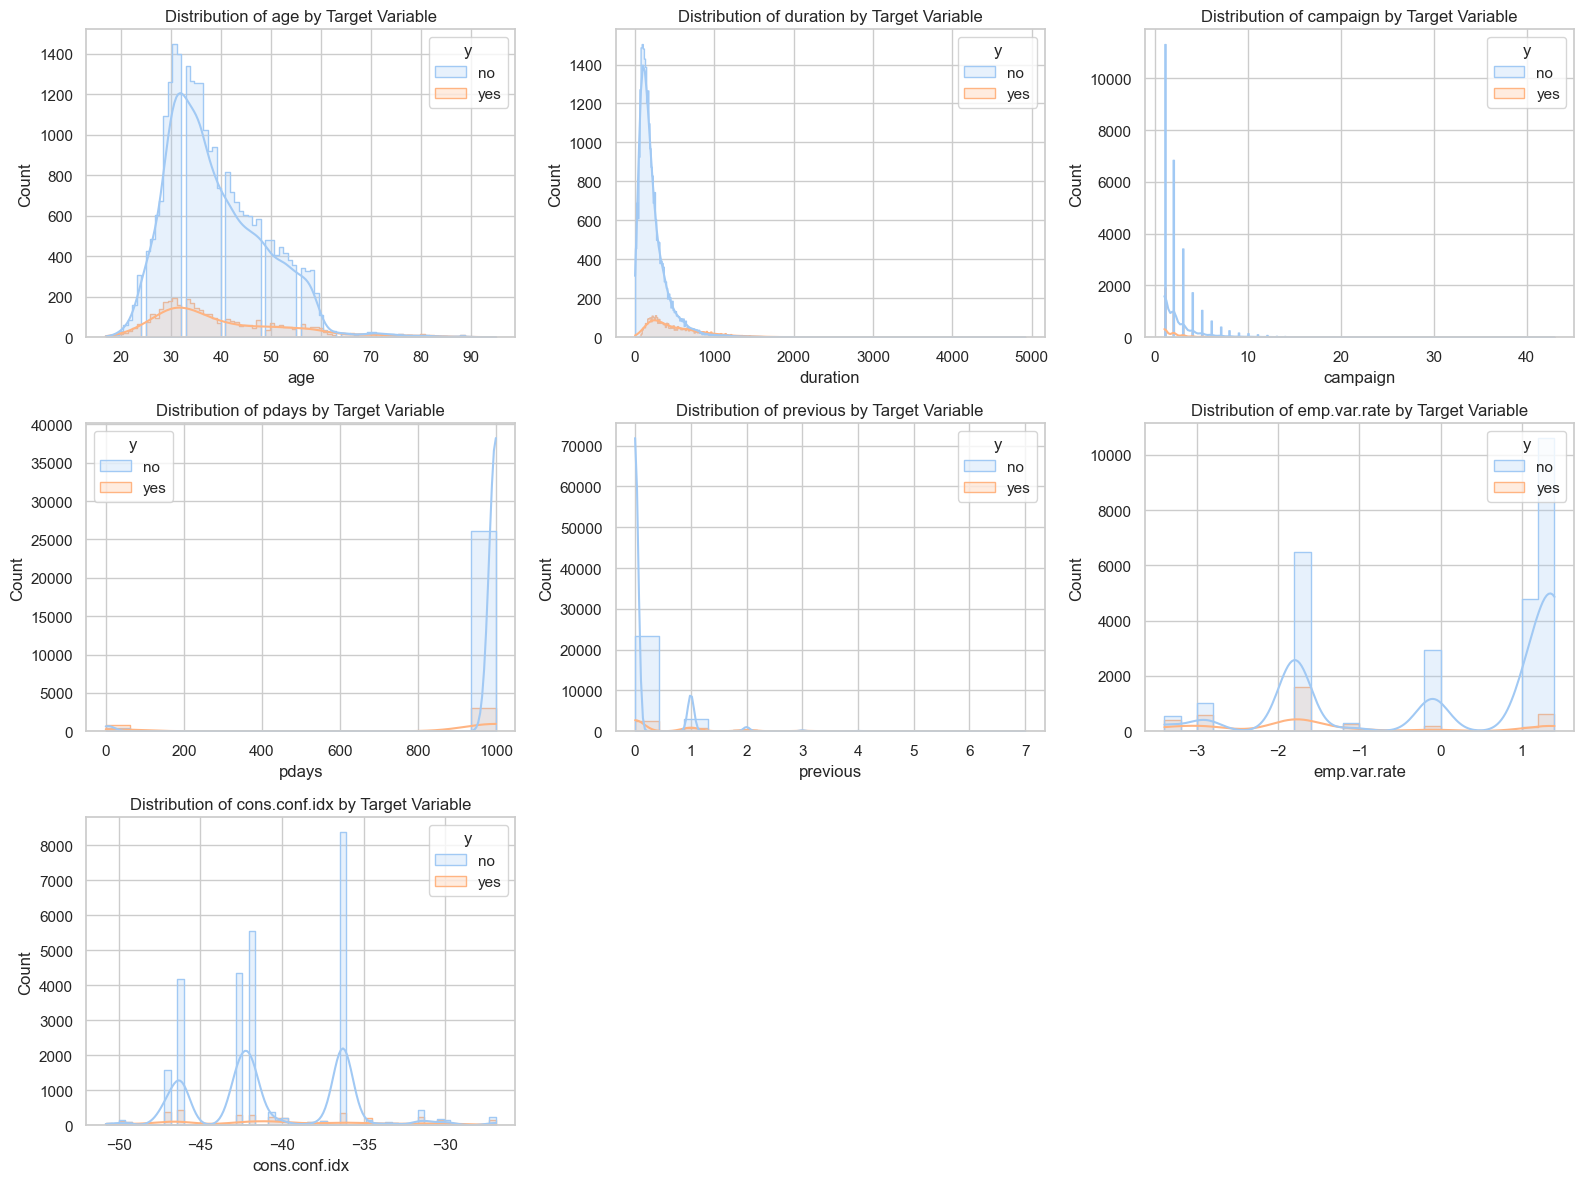

In [451]:
# Set up figure with subplots
plt.figure(figsize=(16, 12))

# Loop through each numerical feature
for i, col in enumerate(numeric_features, start=1):
    plt.subplot(3, 3, i)
    sns.histplot(bank_reduced, x=col, hue='y', kde=True, palette='pastel', element='step')
    plt.title(f'Distribution of {col} by Target Variable')
    plt.xlabel(col)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

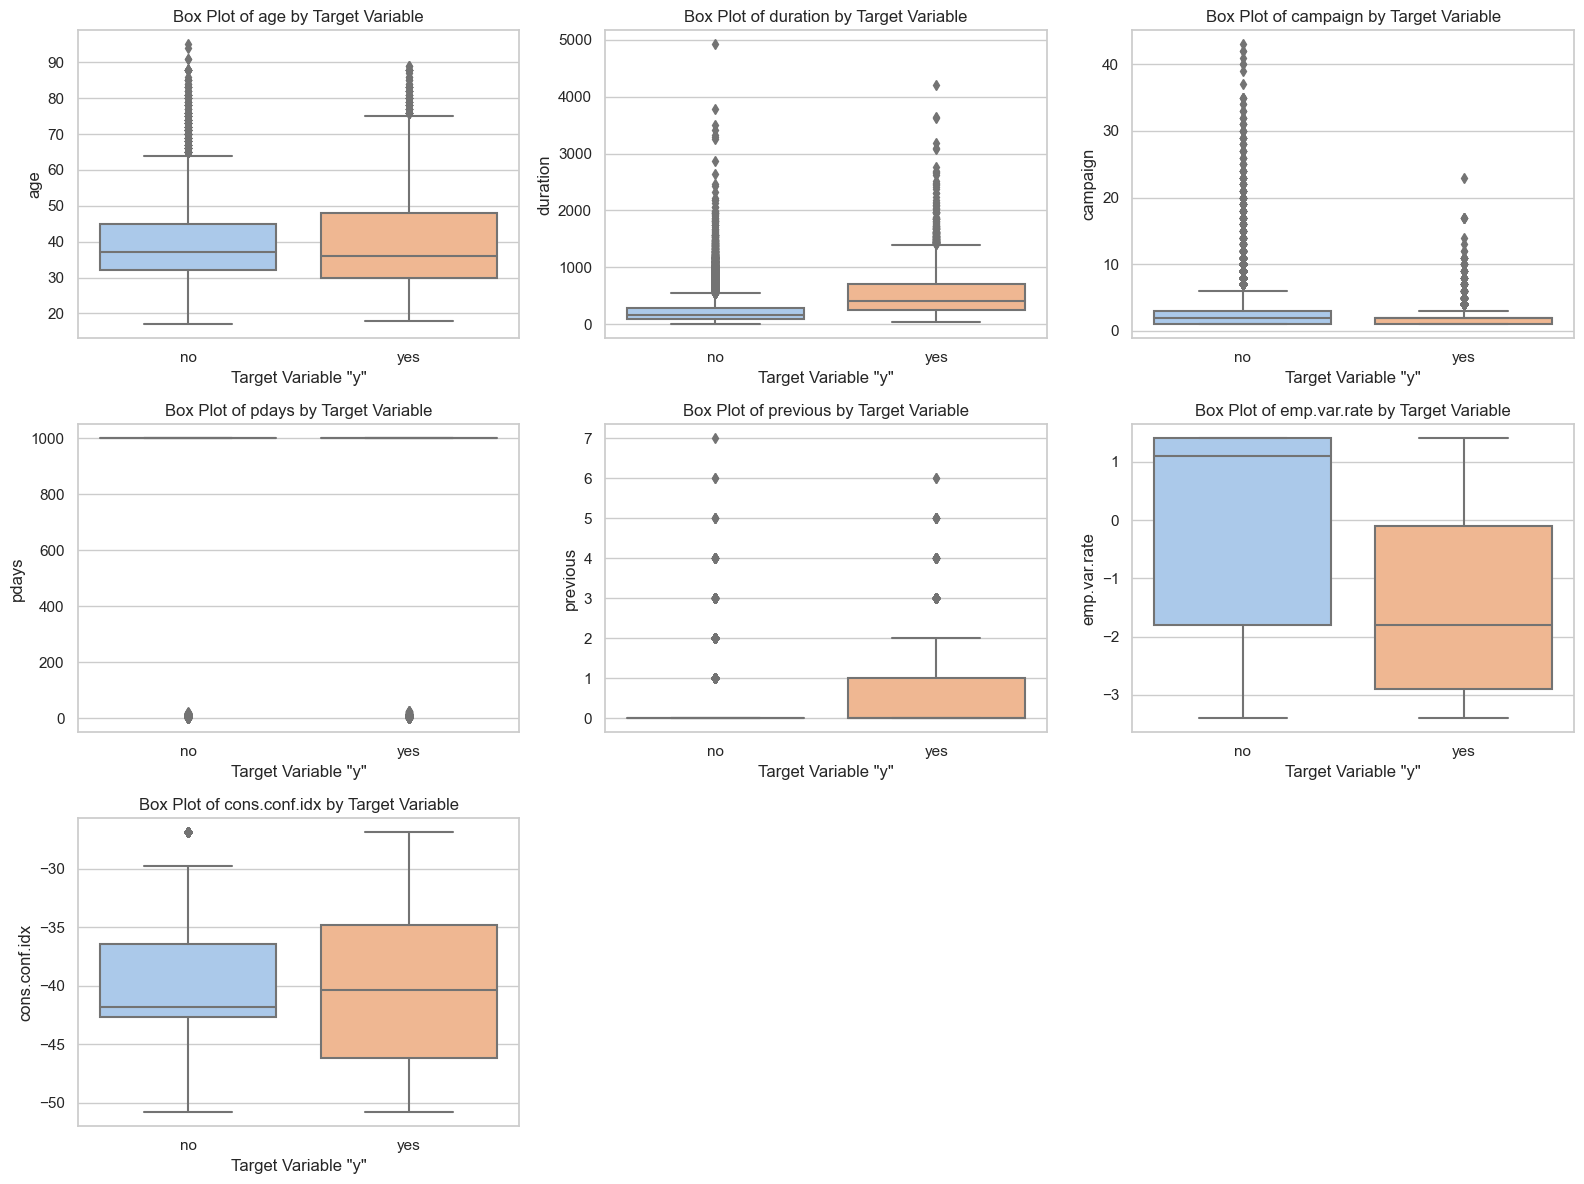

In [452]:
# Set up figure with subplots
plt.figure(figsize=(16, 12))

# Loop through each numerical feature
for i, col in enumerate(numeric_features, start=1):
    plt.subplot(3, 3, i)
    sns.boxplot(x='y', y=col, data=bank_reduced, palette='pastel')
    plt.title(f'Box Plot of {col} by Target Variable')
    plt.xlabel('Target Variable "y"')
    plt.ylabel(col)

plt.tight_layout()
plt.show()

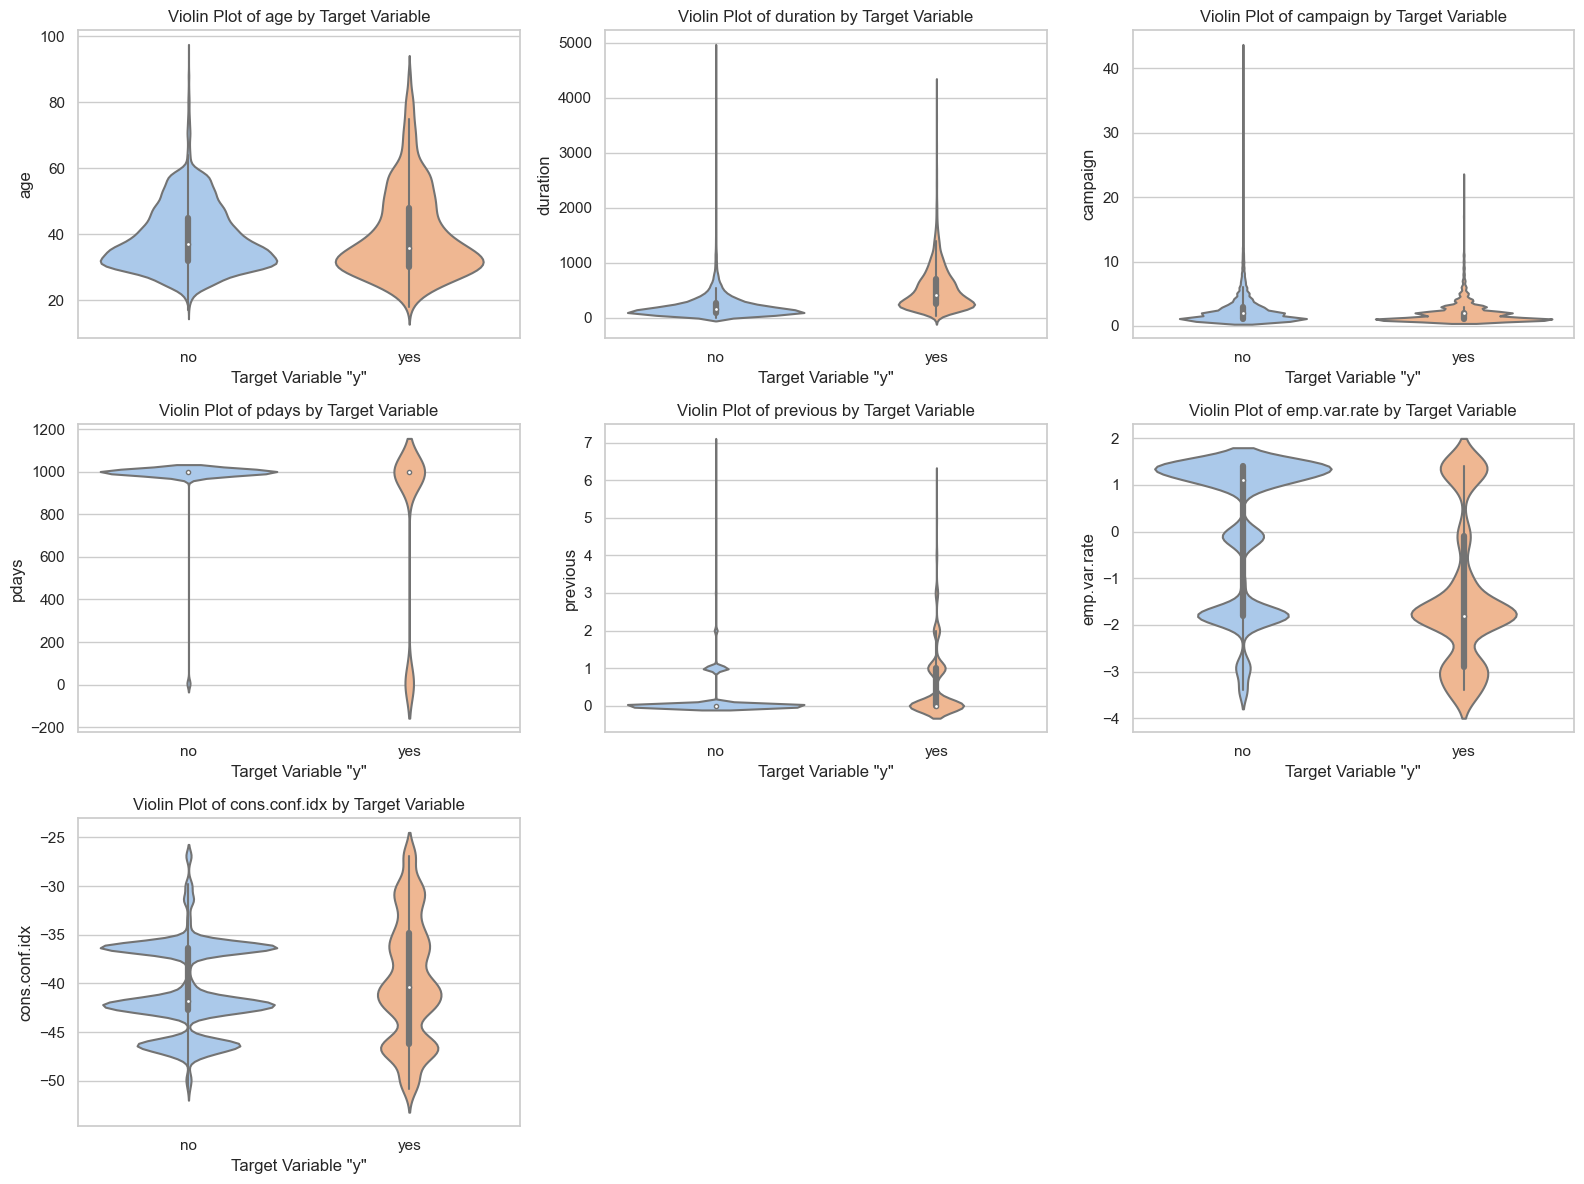

In [453]:
# Set up figure with subplots
plt.figure(figsize=(16, 12))

# Loop through each numerical feature
for i, col in enumerate(numeric_features, start=1):
    plt.subplot(3, 3, i)
    sns.violinplot(x='y', y=col, data=bank_reduced, palette='pastel')
    plt.title(f'Violin Plot of {col} by Target Variable')
    plt.xlabel('Target Variable "y"')
    plt.ylabel(col)

plt.tight_layout()
plt.show()

And also some statistical measures divided by **"yes"** and **"no"** for each **numerical feature**.

In [454]:
# Calculate summary statistics of numerical features grouped by 'y'
bank_reduced.groupby('y')[numeric_features].describe()

age                                                     duration  \
       count       mean        std   min   25%   50%   75%   max    count   
y                                                                           
no   26629.0  38.838334   9.773415  17.0  32.0  37.0  45.0  95.0  26629.0   
yes   3859.0  40.352682  13.510657  18.0  30.0  36.0  48.0  89.0   3859.0   

                 ... emp.var.rate      cons.conf.idx                       \
           mean  ...          75%  max         count       mean       std   
y                ...                                                        
no   220.277555  ...          1.4  1.4       26629.0 -40.714638  4.519967   
yes  530.028505  ...         -0.1  1.4        3859.0 -39.826820  6.289376   

                                   
      min   25%   50%   75%   max  
y                                  
no  -50.8 -42.7 -41.8 -36.4 -26.9  
yes -50.8 -46.2 -40.4 -34.8 -26.9  

[2 rows x 56 columns]

From the graphs and the statistical summary, it can be seen that the **numerical features** whose values most differ between **"yes"** and **"no"** responses to **target variable** are `duration`, `previous`, and `emp.var.rate`. Their means strongly differ from **"yes"** to **"no"**. 

- `duration` mean for "yes" is ~530 seconds while for "no" is ~220 seconds. But, the description of the dataset given says: "Important note:  this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model." 

Given this, I decide to drop `duration`.

- `previous` mean for "yes" is ~0.507 contacts while for "no" is ~0.149 contacts. I believe this a significant measure for the dataframe since it gives the number of contacts performed before this campaign and for this client so it can be a factor on which to train the model.

I won't drop `previous`.

- `emp.var.rate` mean for "yes" is ~0.116 ∆% while for "no" is ~-1.363 ∆%. This is also a signficant measure since it measures the employment variation rate.

I will keep `emp.var.rate`.

In [455]:
bank_reduced = bank_reduced.drop(columns=['duration'])
print('The dataframe has {} rows and {} columns.'.format(bank_reduced.shape[0], bank_reduced.shape[1]))
bank_reduced.head()

The dataframe has 30488 rows and 17 columns.


age        job  marital            education default housing loan  \
0   56  housemaid  married             basic.4y      no      no   no   
2   37   services  married          high.school      no     yes   no   
3   40     admin.  married             basic.6y      no      no   no   
4   56   services  married          high.school      no      no  yes   
6   59     admin.  married  professional.course      no      no   no   

     contact month day_of_week  campaign  pdays  previous     poutcome  \
0  telephone   may         mon         1    999         0  nonexistent   
2  telephone   may         mon         1    999         0  nonexistent   
3  telephone   may         mon         1    999         0  nonexistent   
4  telephone   may         mon         1    999         0  nonexistent   
6  telephone   may         mon         1    999         0  nonexistent   

   emp.var.rate  cons.conf.idx   y  
0           1.1          -36.4  no  
2           1.1          -36.4  no  
3           1.1          -36.4  no  
4           1.1          -36.4  no  
6           1.1          -36.4  no

### **Categorical Features**

Having analyzed **numerical features**, now I want to analyze **categorical features**.

Let's start by analyzing the distribution of **categorical features**.

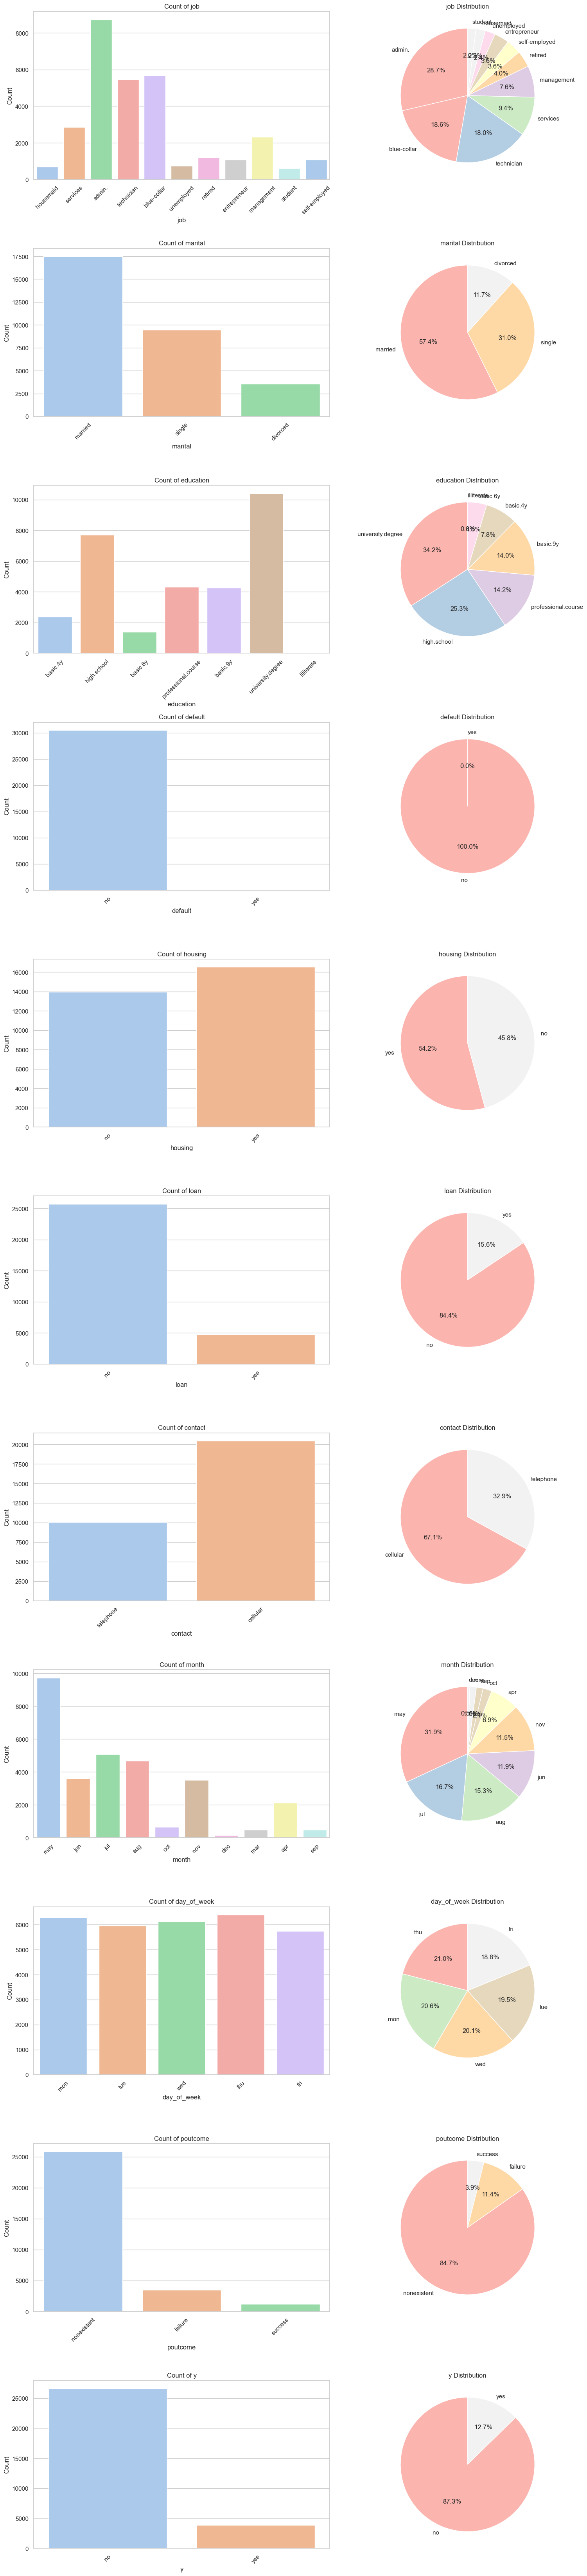

In [456]:
# Extracting categorical features
categorical_features = bank_reduced.select_dtypes(include=['object']).columns

# Set up the subplots
fig, axes = plt.subplots(nrows=len(categorical_features), ncols=2, figsize=(16, 6 * len(categorical_features)))
fig.subplots_adjust(hspace=0.5)

# Loop through each categorical feature
for i, col in enumerate(categorical_features):
    # Count plot
    ax1 = sns.countplot(x=col, data=bank_reduced, ax=axes[i, 0], palette='pastel')
    ax1.set_title(f'Count of {col}')
    ax1.set_xlabel(col)
    ax1.set_ylabel('Count')
    ax1.tick_params(axis='x', rotation=45)
    
    # Pie chart
    ax2 = bank_reduced[col].value_counts().plot(kind='pie', ax=axes[i, 1], autopct='%1.1f%%', startangle=90, cmap='Pastel1')
    ax2.set_title(f'{col} Distribution')
    ax2.set_ylabel('')
    
plt.tight_layout()
plt.show()

As we can already see from this graph, for the variable `default` we have 100% "no" and 0.00% "yes". It seems the only **categorical features** that is really skewed to only one value. Let's check the skewness of all the **categorical features** before dropping it.

In [457]:
# Extracting categorical features
categorical_features = bank_reduced.select_dtypes(include=['object']).columns

# Function to calculate skewness and mode
def check_skewness_and_mode(df, categorical_features):
    skewness_info = {}
    mode_info = {}
    for feature in categorical_features:
        value_counts = df[feature].value_counts(normalize=True)
        skewness_info[feature] = value_counts
        
        mode_value = value_counts.idxmax()
        mode_proportion = value_counts.max()
        mode_info[feature] = (mode_value, mode_proportion)
    
    return skewness_info, mode_info

# Get skewness and mode information
skewness_info, mode_info = check_skewness_and_mode(bank_reduced, categorical_features)

# Define threshold for skewness
skew_threshold = 0.90

# Identify skewed features
skewed_features = {}
for feature, value_counts in skewness_info.items():
    if value_counts.max() > skew_threshold:
        skewed_features[feature] = value_counts

# Display mode and mode proportion for all categorical features
mode_df = pd.DataFrame.from_dict(mode_info, orient='index', columns=['Mode', 'Mode Proportion'])
print("Mode and Mode Proportion for All Categorical Features:")
print(mode_df)
print("-" * 55)

# Display skewed features
print("Skewed Features (Threshold > 90%):")
for feature, value_counts in skewed_features.items():
    print(f"Feature: {feature}")
    print(value_counts)

Mode and Mode Proportion for All Categorical Features:
                          Mode  Mode Proportion
job                     admin.         0.286572
marital                married         0.573734
education    university.degree         0.341511
default                     no         0.999902
housing                    yes         0.541885
loan                        no         0.843611
contact               cellular         0.670526
month                      may         0.319240
day_of_week                thu         0.209755
poutcome           nonexistent         0.847415
y                           no         0.873426
-------------------------------------------------------
Skewed Features (Threshold > 90%):
Feature: default
no     0.999902
yes    0.000098
Name: default, dtype: float64


From these analysis, it is confirmed that the only feature that is really skewed (with a mode proportion of 99.9902%) is the `default` categorical feature. I drop it consequently.

In [458]:
bank_reduced = bank_reduced.drop(columns=['default'])
print('The dataframe has {} rows and {} columns.'.format(bank_reduced.shape[0], bank_reduced.shape[1]))
bank_reduced.head()

The dataframe has 30488 rows and 16 columns.


age        job  marital            education housing loan    contact month  \
0   56  housemaid  married             basic.4y      no   no  telephone   may   
2   37   services  married          high.school     yes   no  telephone   may   
3   40     admin.  married             basic.6y      no   no  telephone   may   
4   56   services  married          high.school      no  yes  telephone   may   
6   59     admin.  married  professional.course      no   no  telephone   may   

  day_of_week  campaign  pdays  previous     poutcome  emp.var.rate  \
0         mon         1    999         0  nonexistent           1.1   
2         mon         1    999         0  nonexistent           1.1   
3         mon         1    999         0  nonexistent           1.1   
4         mon         1    999         0  nonexistent           1.1   
6         mon         1    999         0  nonexistent           1.1   

   cons.conf.idx   y  
0          -36.4  no  
2          -36.4  no  
3          -36.4  no  
4          -36.4  no  
6          -36.4  no

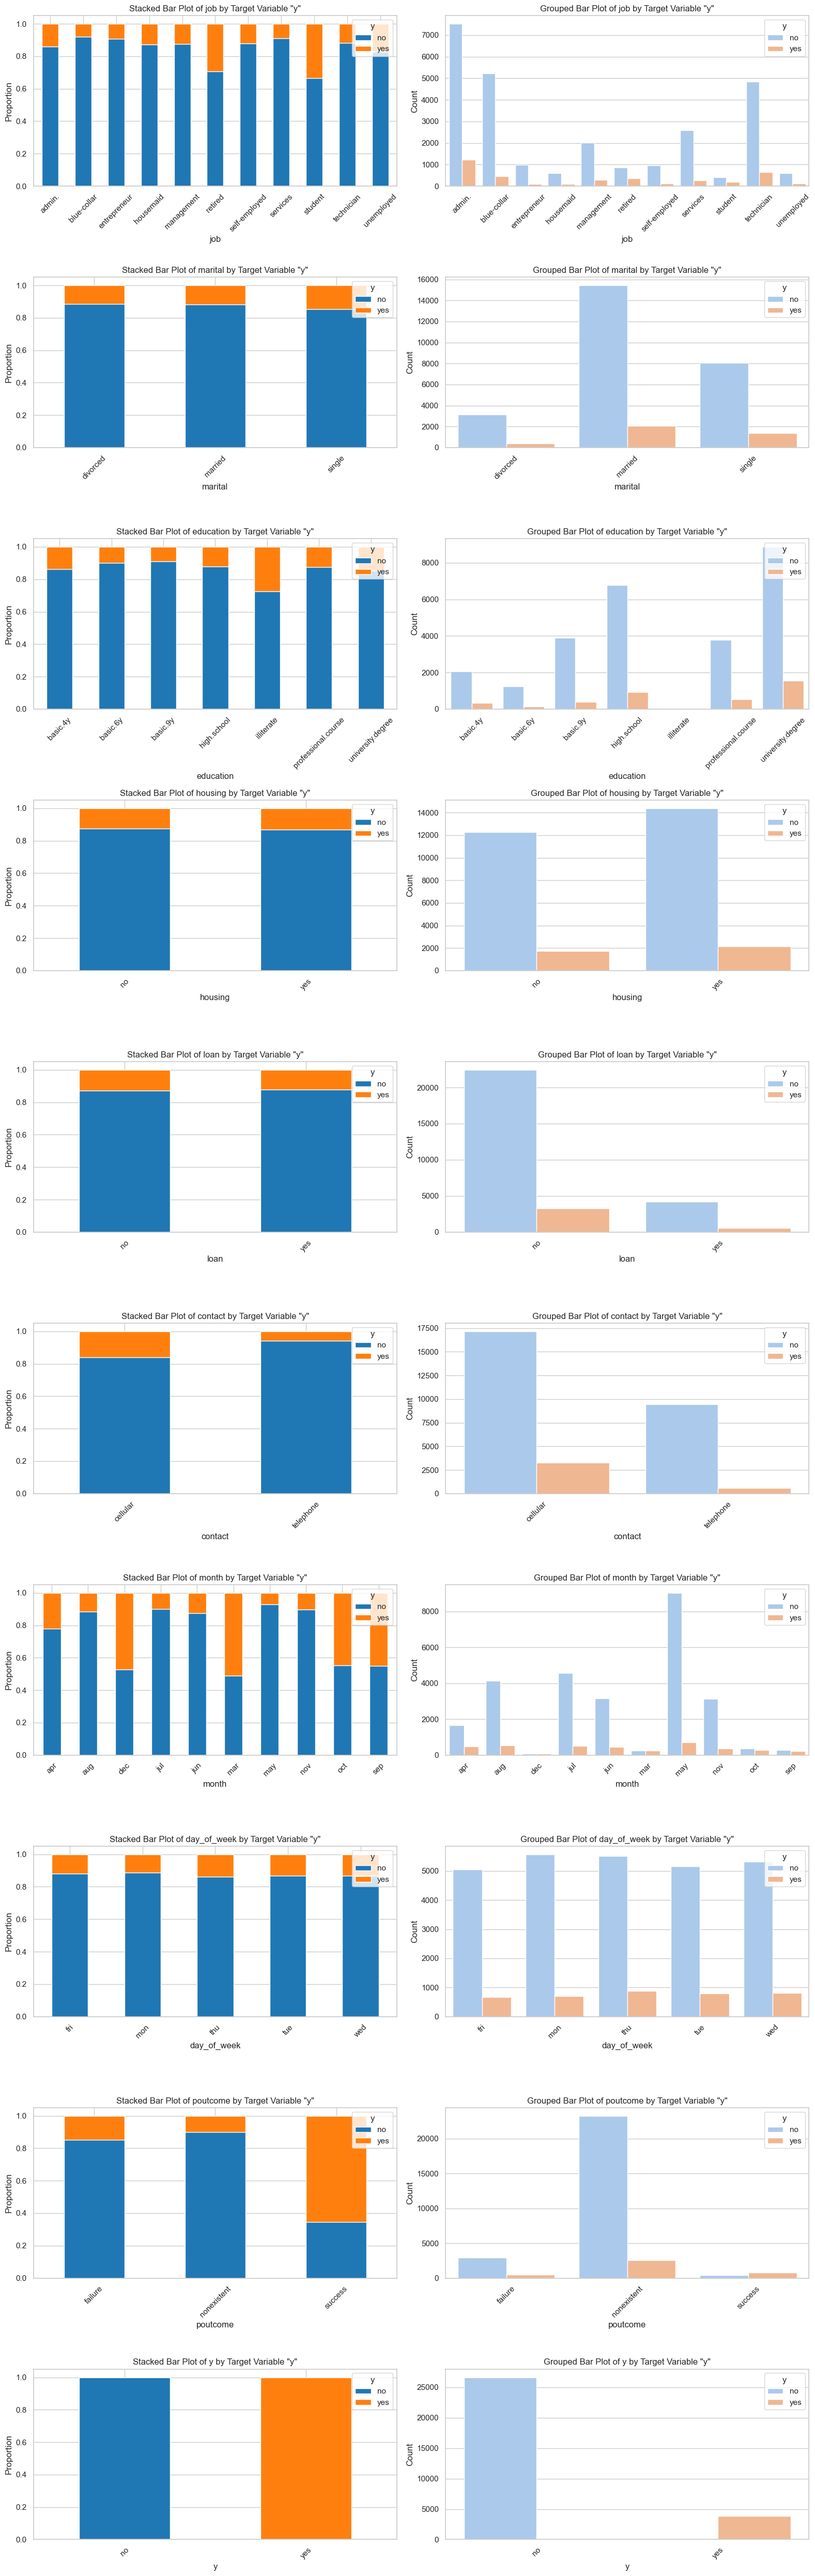

In [459]:
# Extracting categorical features excluding the dropped 'default' variable
categorical_features = bank_reduced.select_dtypes(include=['object']).columns

# Set up figure with subplots, two plots per categorical feature
fig, axes = plt.subplots(len(categorical_features), 2, figsize=(16, 5 * len(categorical_features)))

# Loop through each categorical feature
for i, feature in enumerate(categorical_features):
    # Cross-tabulation of the feature and target variable 'y'
    crosstab = pd.crosstab(bank_reduced[feature], bank_reduced['y'], normalize='index')
    
    # Get the category order
    category_order = crosstab.index
    
    # Plotting the stacked bar plot
    crosstab.plot(kind='bar', stacked=True, ax=axes[i, 0], color=['#1f77b4', '#ff7f0e'], legend=False)
    axes[i, 0].set_title(f'Stacked Bar Plot of {feature} by Target Variable "y"')
    axes[i, 0].set_xlabel(feature)
    axes[i, 0].set_ylabel('Proportion')
    axes[i, 0].legend(title='y', loc='upper right')
    axes[i, 0].tick_params(axis='x', rotation=45)
    
    # Plotting the grouped bar plot
    sns.countplot(data=bank_reduced, x=feature, hue='y', palette='pastel', ax=axes[i, 1], order=category_order)
    axes[i, 1].set_title(f'Grouped Bar Plot of {feature} by Target Variable "y"')
    axes[i, 1].set_xlabel(feature)
    axes[i, 1].set_ylabel('Count')
    axes[i, 1].tick_params(axis='x', rotation=45)
    axes[i, 1].legend(title='y', loc='upper right')

plt.tight_layout()
plt.show()

There are some results of the **categorical features** that could bias our **target value**. For example, the `poutcome` feature whose values are "success" have a bias towards "yes" as a `"y"` target variable outcome but I believe the data make sense given that `poutcome` is the variable for the success of past marketing campaings with the client. Let's keep them as they are.

## **3. Data Pre-Processing and Feature Engineering**

Now, the dataframe is almost ready to be used the application of Machine Learning algorithms. 

In [460]:
bank_reduced.info()
print('The dataframe has {} rows and {} columns.'.format(bank_reduced.shape[0], bank_reduced.shape[1]))
bank_reduced.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30488 entries, 0 to 41187
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            30488 non-null  int64  
 1   job            30488 non-null  object 
 2   marital        30488 non-null  object 
 3   education      30488 non-null  object 
 4   housing        30488 non-null  object 
 5   loan           30488 non-null  object 
 6   contact        30488 non-null  object 
 7   month          30488 non-null  object 
 8   day_of_week    30488 non-null  object 
 9   campaign       30488 non-null  int64  
 10  pdays          30488 non-null  int64  
 11  previous       30488 non-null  int64  
 12  poutcome       30488 non-null  object 
 13  emp.var.rate   30488 non-null  float64
 14  cons.conf.idx  30488 non-null  float64
 15  y              30488 non-null  object 
dtypes: float64(2), int64(4), object(10)
memory usage: 4.0+ MB
The dataframe has 30488 rows and 16 

age        job  marital            education housing loan    contact month  \
0   56  housemaid  married             basic.4y      no   no  telephone   may   
2   37   services  married          high.school     yes   no  telephone   may   
3   40     admin.  married             basic.6y      no   no  telephone   may   
4   56   services  married          high.school      no  yes  telephone   may   
6   59     admin.  married  professional.course      no   no  telephone   may   

  day_of_week  campaign  pdays  previous     poutcome  emp.var.rate  \
0         mon         1    999         0  nonexistent           1.1   
2         mon         1    999         0  nonexistent           1.1   
3         mon         1    999         0  nonexistent           1.1   
4         mon         1    999         0  nonexistent           1.1   
6         mon         1    999         0  nonexistent           1.1   

   cons.conf.idx   y  
0          -36.4  no  
2          -36.4  no  
3          -36.4  no  
4          -36.4  no  
6          -36.4  no

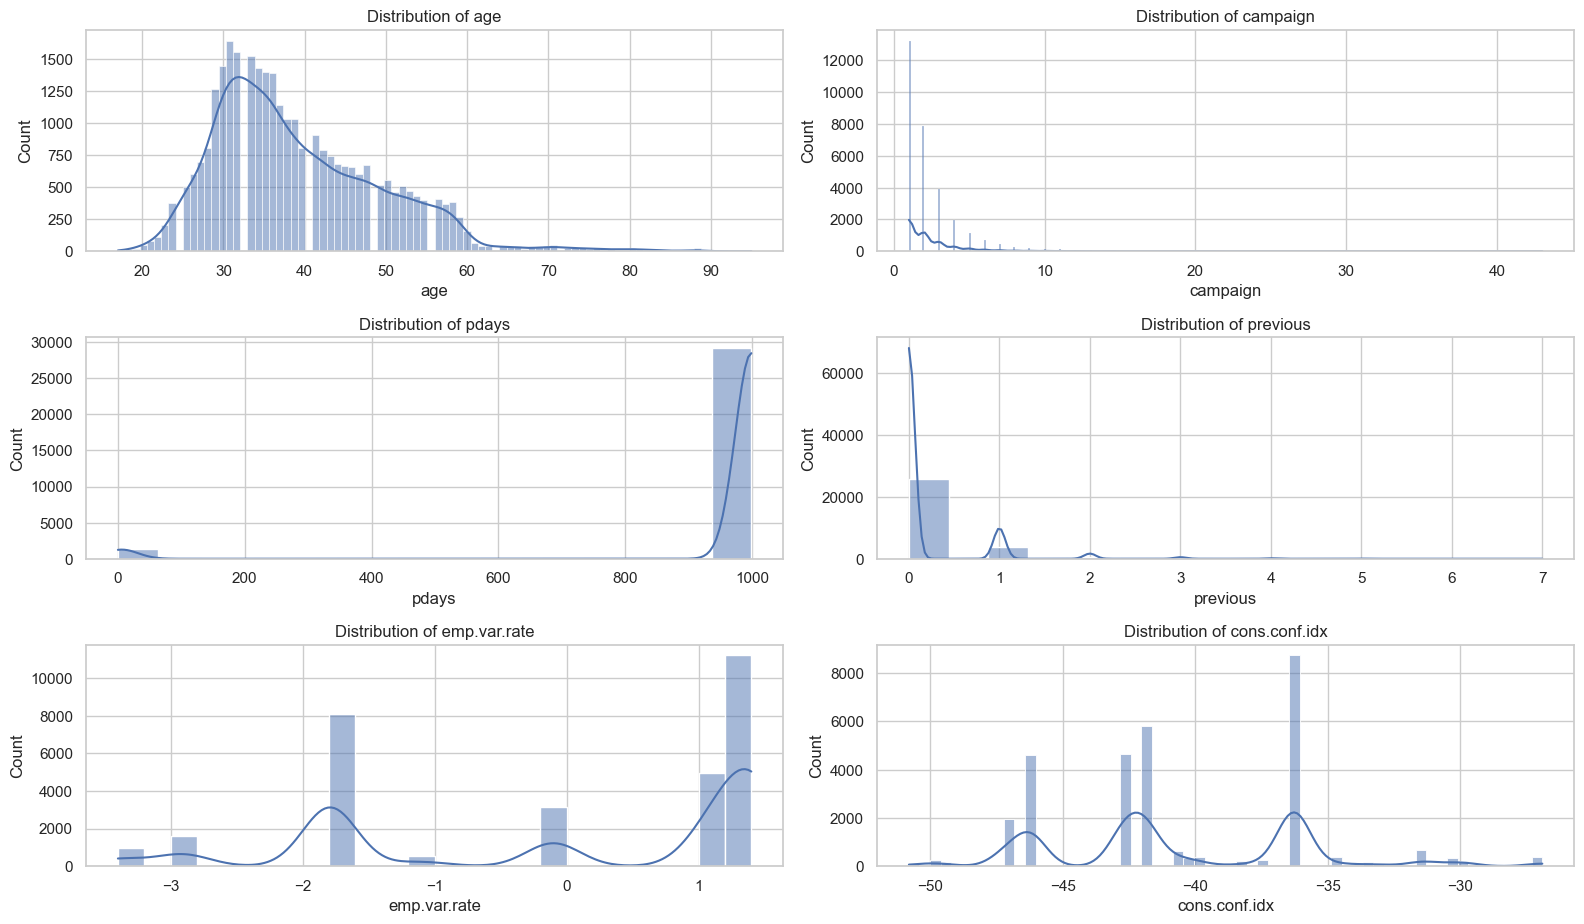

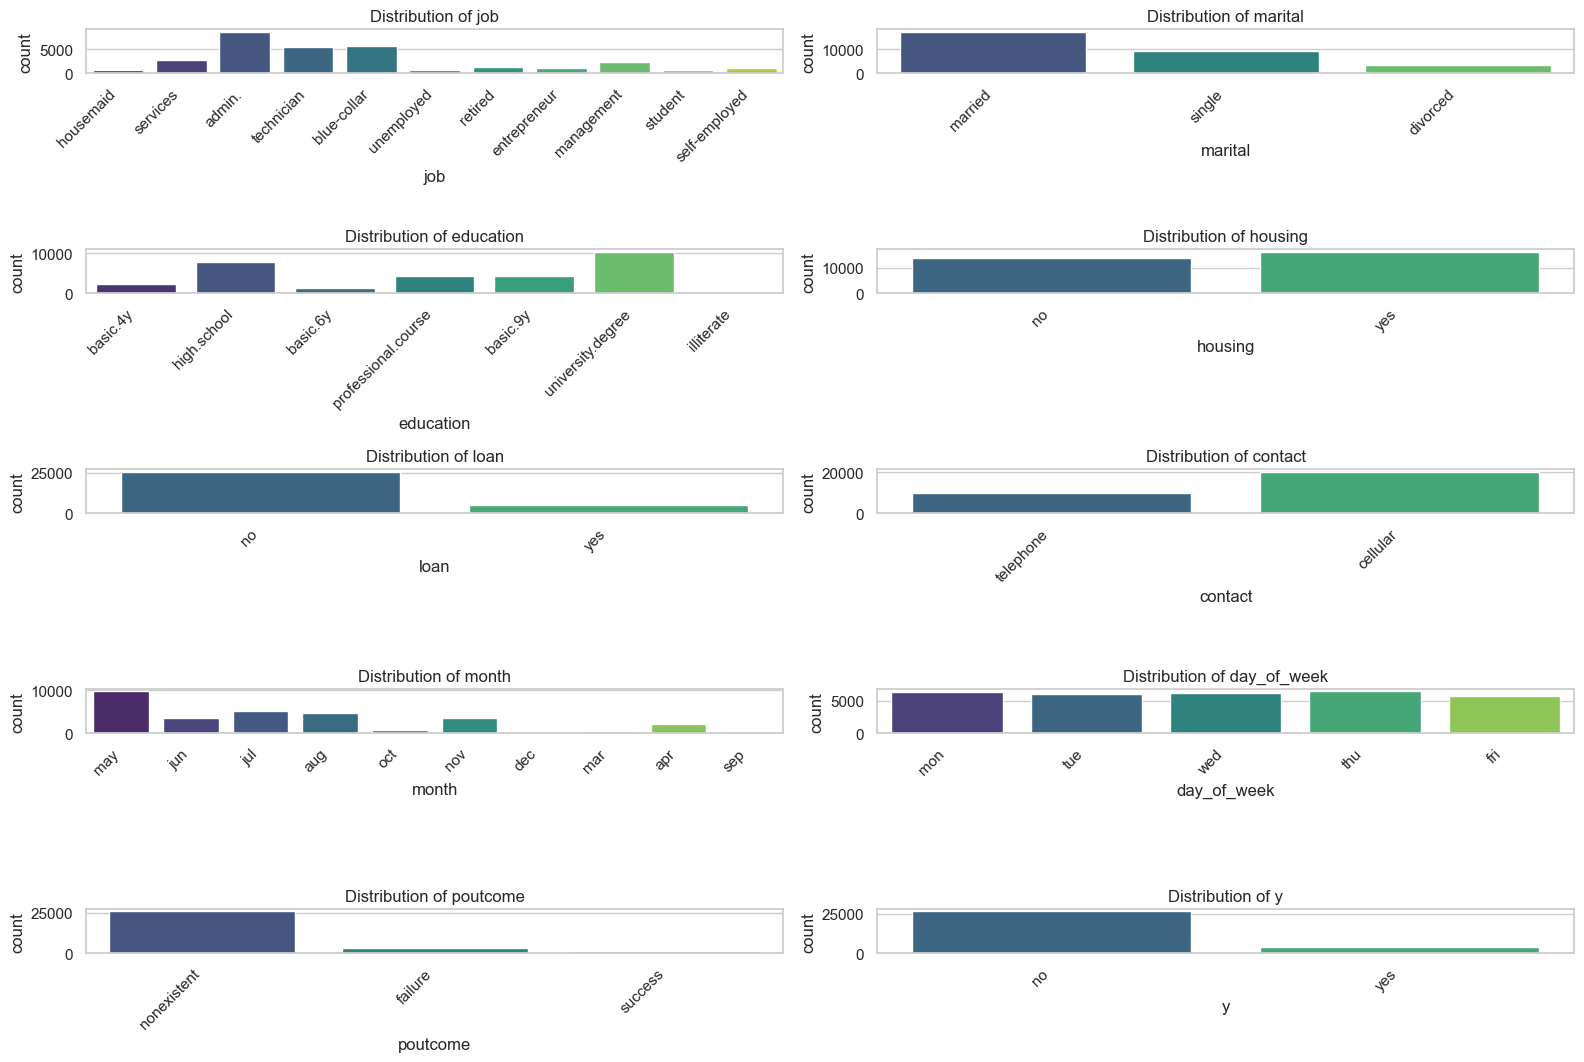

In [461]:
numerical_cols = bank_reduced.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = bank_reduced.select_dtypes(include=['object', 'category']).columns

# Plot distribution of numerical columns
plt.figure(figsize=(16, 12))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(len(numerical_cols) // 2 + 1, 2, i)
    sns.histplot(bank[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# Plot distribution of categorical columns
plt.figure(figsize=(16, 12))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(len(categorical_cols) // 2 + 1, 2, i)
    sns.countplot(x=col, data=bank, palette='viridis')
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

I believe there are 2 Feature Engineering steps to do before having our model ready for use. 

2 problems are still present in the dataframe:

1) **Numerical features** have very different scales of distribution that can't be simply compared.

2) We have to deal with **categorical features** since they have many different outcome values.

I am going to solve these problems in the following way:

1) Apply a **scaler** to **numerical features** as to be in a comparable range with the others.

2) Apply **one-hot encoding (dummy variables)** to **categorical features** in order to convert categorical features into numerical comparable features.

In [462]:
# Extracting numerical and categorical features
numeric_features = bank_reduced.select_dtypes(include=['int64', 'float64']).columns
categorical_features = bank_reduced.select_dtypes(include=['object']).columns

**Step 1.** I apply the feature scaling **Standard Scaler** that rescale and shift each dimension to have a mean of 0 and a standard deviation of 1.

In [463]:
# Step 1: Scale Numerical Features
scaler = StandardScaler()
bank_reduced[numeric_features] = scaler.fit_transform(bank_reduced[numeric_features])
bank_reduced.head()

age        job  marital            education housing loan    contact  \
0  1.642253  housemaid  married             basic.4y      no   no  telephone   
2 -0.196452   services  married          high.school     yes   no  telephone   
3  0.093870     admin.  married             basic.6y      no   no  telephone   
4  1.642253   services  married          high.school      no  yes  telephone   
6  1.932575     admin.  married  professional.course      no   no  telephone   

  month day_of_week  campaign     pdays  previous     poutcome  emp.var.rate  \
0   may         mon -0.559335  0.211887 -0.371616  nonexistent      0.727477   
2   may         mon -0.559335  0.211887 -0.371616  nonexistent      0.727477   
3   may         mon -0.559335  0.211887 -0.371616  nonexistent      0.727477   
4   may         mon -0.559335  0.211887 -0.371616  nonexistent      0.727477   
6   may         mon -0.559335  0.211887 -0.371616  nonexistent      0.727477   

   cons.conf.idx   y  
0       0.877451  no  
2       0.877451  no  
3       0.877451  no  
4       0.877451  no  
6       0.877451  no

**Step 2.1** I convert binary features (so columns with "yes" and "no" as outcomes such as `housing`, `loan`, and target variable `y`) to 0 and 1 since applying **one-hot encoding** to them would mean to have 3 additional columns.

In [464]:
# Step 2.1: Convert binary categorical features (yes/no) to 0 and 1
binary_categorical_features = [col for col in categorical_features if set(bank_reduced[col].unique()) <= {'yes', 'no'}]

for feature in binary_categorical_features:
    bank_reduced[feature] = bank_reduced[feature].map({'yes': 1, 'no': 0})

bank_reduced.head()

age        job  marital            education  housing  loan  \
0  1.642253  housemaid  married             basic.4y        0     0   
2 -0.196452   services  married          high.school        1     0   
3  0.093870     admin.  married             basic.6y        0     0   
4  1.642253   services  married          high.school        0     1   
6  1.932575     admin.  married  professional.course        0     0   

     contact month day_of_week  campaign     pdays  previous     poutcome  \
0  telephone   may         mon -0.559335  0.211887 -0.371616  nonexistent   
2  telephone   may         mon -0.559335  0.211887 -0.371616  nonexistent   
3  telephone   may         mon -0.559335  0.211887 -0.371616  nonexistent   
4  telephone   may         mon -0.559335  0.211887 -0.371616  nonexistent   
6  telephone   may         mon -0.559335  0.211887 -0.371616  nonexistent   

   emp.var.rate  cons.conf.idx  y  
0      0.727477       0.877451  0  
2      0.727477       0.877451  0  
3      0.727477       0.877451  0  
4      0.727477       0.877451  0  
6      0.727477       0.877451  0

**Step 2.2** I apply **one-hot encoding** to the remaining categorical features. This will create a new column for each value of a categorical feature with 0/1 value. For example `day_of_week` will make 5 columns: `day_of_week_mon`, `day_of_week_tue`, `day_of_week_wed`, `day_of_week_thu`, and `day_of_week_fri`. 

In [465]:
# Remaining categorical features (after removing binary features)
remaining_categorical_features = [col for col in categorical_features if col not in binary_categorical_features]

# Step 2.2: Apply One-Hot Encoding to the remaining categorical features
bank_reduced = pd.get_dummies(bank_reduced, columns=remaining_categorical_features, drop_first=True)

bank_reduced.head()

age  housing  loan  campaign     pdays  previous  emp.var.rate  \
0  1.642253        0     0 -0.559335  0.211887 -0.371616      0.727477   
2 -0.196452        1     0 -0.559335  0.211887 -0.371616      0.727477   
3  0.093870        0     0 -0.559335  0.211887 -0.371616      0.727477   
4  1.642253        0     1 -0.559335  0.211887 -0.371616      0.727477   
6  1.932575        0     0 -0.559335  0.211887 -0.371616      0.727477   

   cons.conf.idx  y  job_blue-collar  ...  month_may  month_nov  month_oct  \
0       0.877451  0                0  ...          1          0          0   
2       0.877451  0                0  ...          1          0          0   
3       0.877451  0                0  ...          1          0          0   
4       0.877451  0                0  ...          1          0          0   
6       0.877451  0                0  ...          1          0          0   

   month_sep  day_of_week_mon  day_of_week_thu  day_of_week_tue  \
0          0                1                0                0   
2          0                1                0                0   
3          0                1                0                0   
4          0                1                0                0   
6          0                1                0                0   

   day_of_week_wed  poutcome_nonexistent  poutcome_success  
0                0                     1                 0  
2                0                     1                 0  
3                0                     1                 0  
4                0                     1                 0  
6                0                     1                 0  

[5 rows x 43 columns]

The dataframe has a new shape, with plenty of more columns. Let's see how many.

In [466]:
bank_reduced.info()
print('The dataframe has {} rows and {} columns.'.format(bank_reduced.shape[0], bank_reduced.shape[1]))
bank_reduced.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30488 entries, 0 to 41187
Data columns (total 43 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            30488 non-null  float64
 1   housing                        30488 non-null  int64  
 2   loan                           30488 non-null  int64  
 3   campaign                       30488 non-null  float64
 4   pdays                          30488 non-null  float64
 5   previous                       30488 non-null  float64
 6   emp.var.rate                   30488 non-null  float64
 7   cons.conf.idx                  30488 non-null  float64
 8   y                              30488 non-null  int64  
 9   job_blue-collar                30488 non-null  uint8  
 10  job_entrepreneur               30488 non-null  uint8  
 11  job_housemaid                  30488 non-null  uint8  
 12  job_management                 30488 non-null 

age  housing  loan  campaign     pdays  previous  emp.var.rate  \
0  1.642253        0     0 -0.559335  0.211887 -0.371616      0.727477   
2 -0.196452        1     0 -0.559335  0.211887 -0.371616      0.727477   
3  0.093870        0     0 -0.559335  0.211887 -0.371616      0.727477   
4  1.642253        0     1 -0.559335  0.211887 -0.371616      0.727477   
6  1.932575        0     0 -0.559335  0.211887 -0.371616      0.727477   

   cons.conf.idx  y  job_blue-collar  ...  month_may  month_nov  month_oct  \
0       0.877451  0                0  ...          1          0          0   
2       0.877451  0                0  ...          1          0          0   
3       0.877451  0                0  ...          1          0          0   
4       0.877451  0                0  ...          1          0          0   
6       0.877451  0                0  ...          1          0          0   

   month_sep  day_of_week_mon  day_of_week_thu  day_of_week_tue  \
0          0                1                0                0   
2          0                1                0                0   
3          0                1                0                0   
4          0                1                0                0   
6          0                1                0                0   

   day_of_week_wed  poutcome_nonexistent  poutcome_success  
0                0                     1                 0  
2                0                     1                 0  
3                0                     1                 0  
4                0                     1                 0  
6                0                     1                 0  

[5 rows x 43 columns]

The dataframe has 30488 rows and 43 columns. Data types are **integer** and **float**. I convert everything to **float**.

In [467]:
# Convert all integer columns to float
integer_columns = bank_reduced.select_dtypes(include=['int64','uint8']).columns
bank_reduced[integer_columns] = bank_reduced[integer_columns].astype(float)

bank_reduced.info()
print('The dataframe has {} rows and {} columns.'.format(bank_reduced.shape[0], bank_reduced.shape[1]))
bank_reduced.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30488 entries, 0 to 41187
Data columns (total 43 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            30488 non-null  float64
 1   housing                        30488 non-null  float64
 2   loan                           30488 non-null  float64
 3   campaign                       30488 non-null  float64
 4   pdays                          30488 non-null  float64
 5   previous                       30488 non-null  float64
 6   emp.var.rate                   30488 non-null  float64
 7   cons.conf.idx                  30488 non-null  float64
 8   y                              30488 non-null  float64
 9   job_blue-collar                30488 non-null  float64
 10  job_entrepreneur               30488 non-null  float64
 11  job_housemaid                  30488 non-null  float64
 12  job_management                 30488 non-null 

age  housing  loan  campaign     pdays  previous  emp.var.rate  \
0  1.642253      0.0   0.0 -0.559335  0.211887 -0.371616      0.727477   
2 -0.196452      1.0   0.0 -0.559335  0.211887 -0.371616      0.727477   
3  0.093870      0.0   0.0 -0.559335  0.211887 -0.371616      0.727477   
4  1.642253      0.0   1.0 -0.559335  0.211887 -0.371616      0.727477   
6  1.932575      0.0   0.0 -0.559335  0.211887 -0.371616      0.727477   

   cons.conf.idx    y  job_blue-collar  ...  month_may  month_nov  month_oct  \
0       0.877451  0.0              0.0  ...        1.0        0.0        0.0   
2       0.877451  0.0              0.0  ...        1.0        0.0        0.0   
3       0.877451  0.0              0.0  ...        1.0        0.0        0.0   
4       0.877451  0.0              0.0  ...        1.0        0.0        0.0   
6       0.877451  0.0              0.0  ...        1.0        0.0        0.0   

   month_sep  day_of_week_mon  day_of_week_thu  day_of_week_tue  \
0        0.0              1.0              0.0              0.0   
2        0.0              1.0              0.0              0.0   
3        0.0              1.0              0.0              0.0   
4        0.0              1.0              0.0              0.0   
6        0.0              1.0              0.0              0.0   

   day_of_week_wed  poutcome_nonexistent  poutcome_success  
0              0.0                   1.0               0.0  
2              0.0                   1.0               0.0  
3              0.0                   1.0               0.0  
4              0.0                   1.0               0.0  
6              0.0                   1.0               0.0  

[5 rows x 43 columns]

Now that I can, I check for correlation between every feature of my dataframe to search for values to drop in case of high correlation that would impact the results of Machine Learning algorithms.

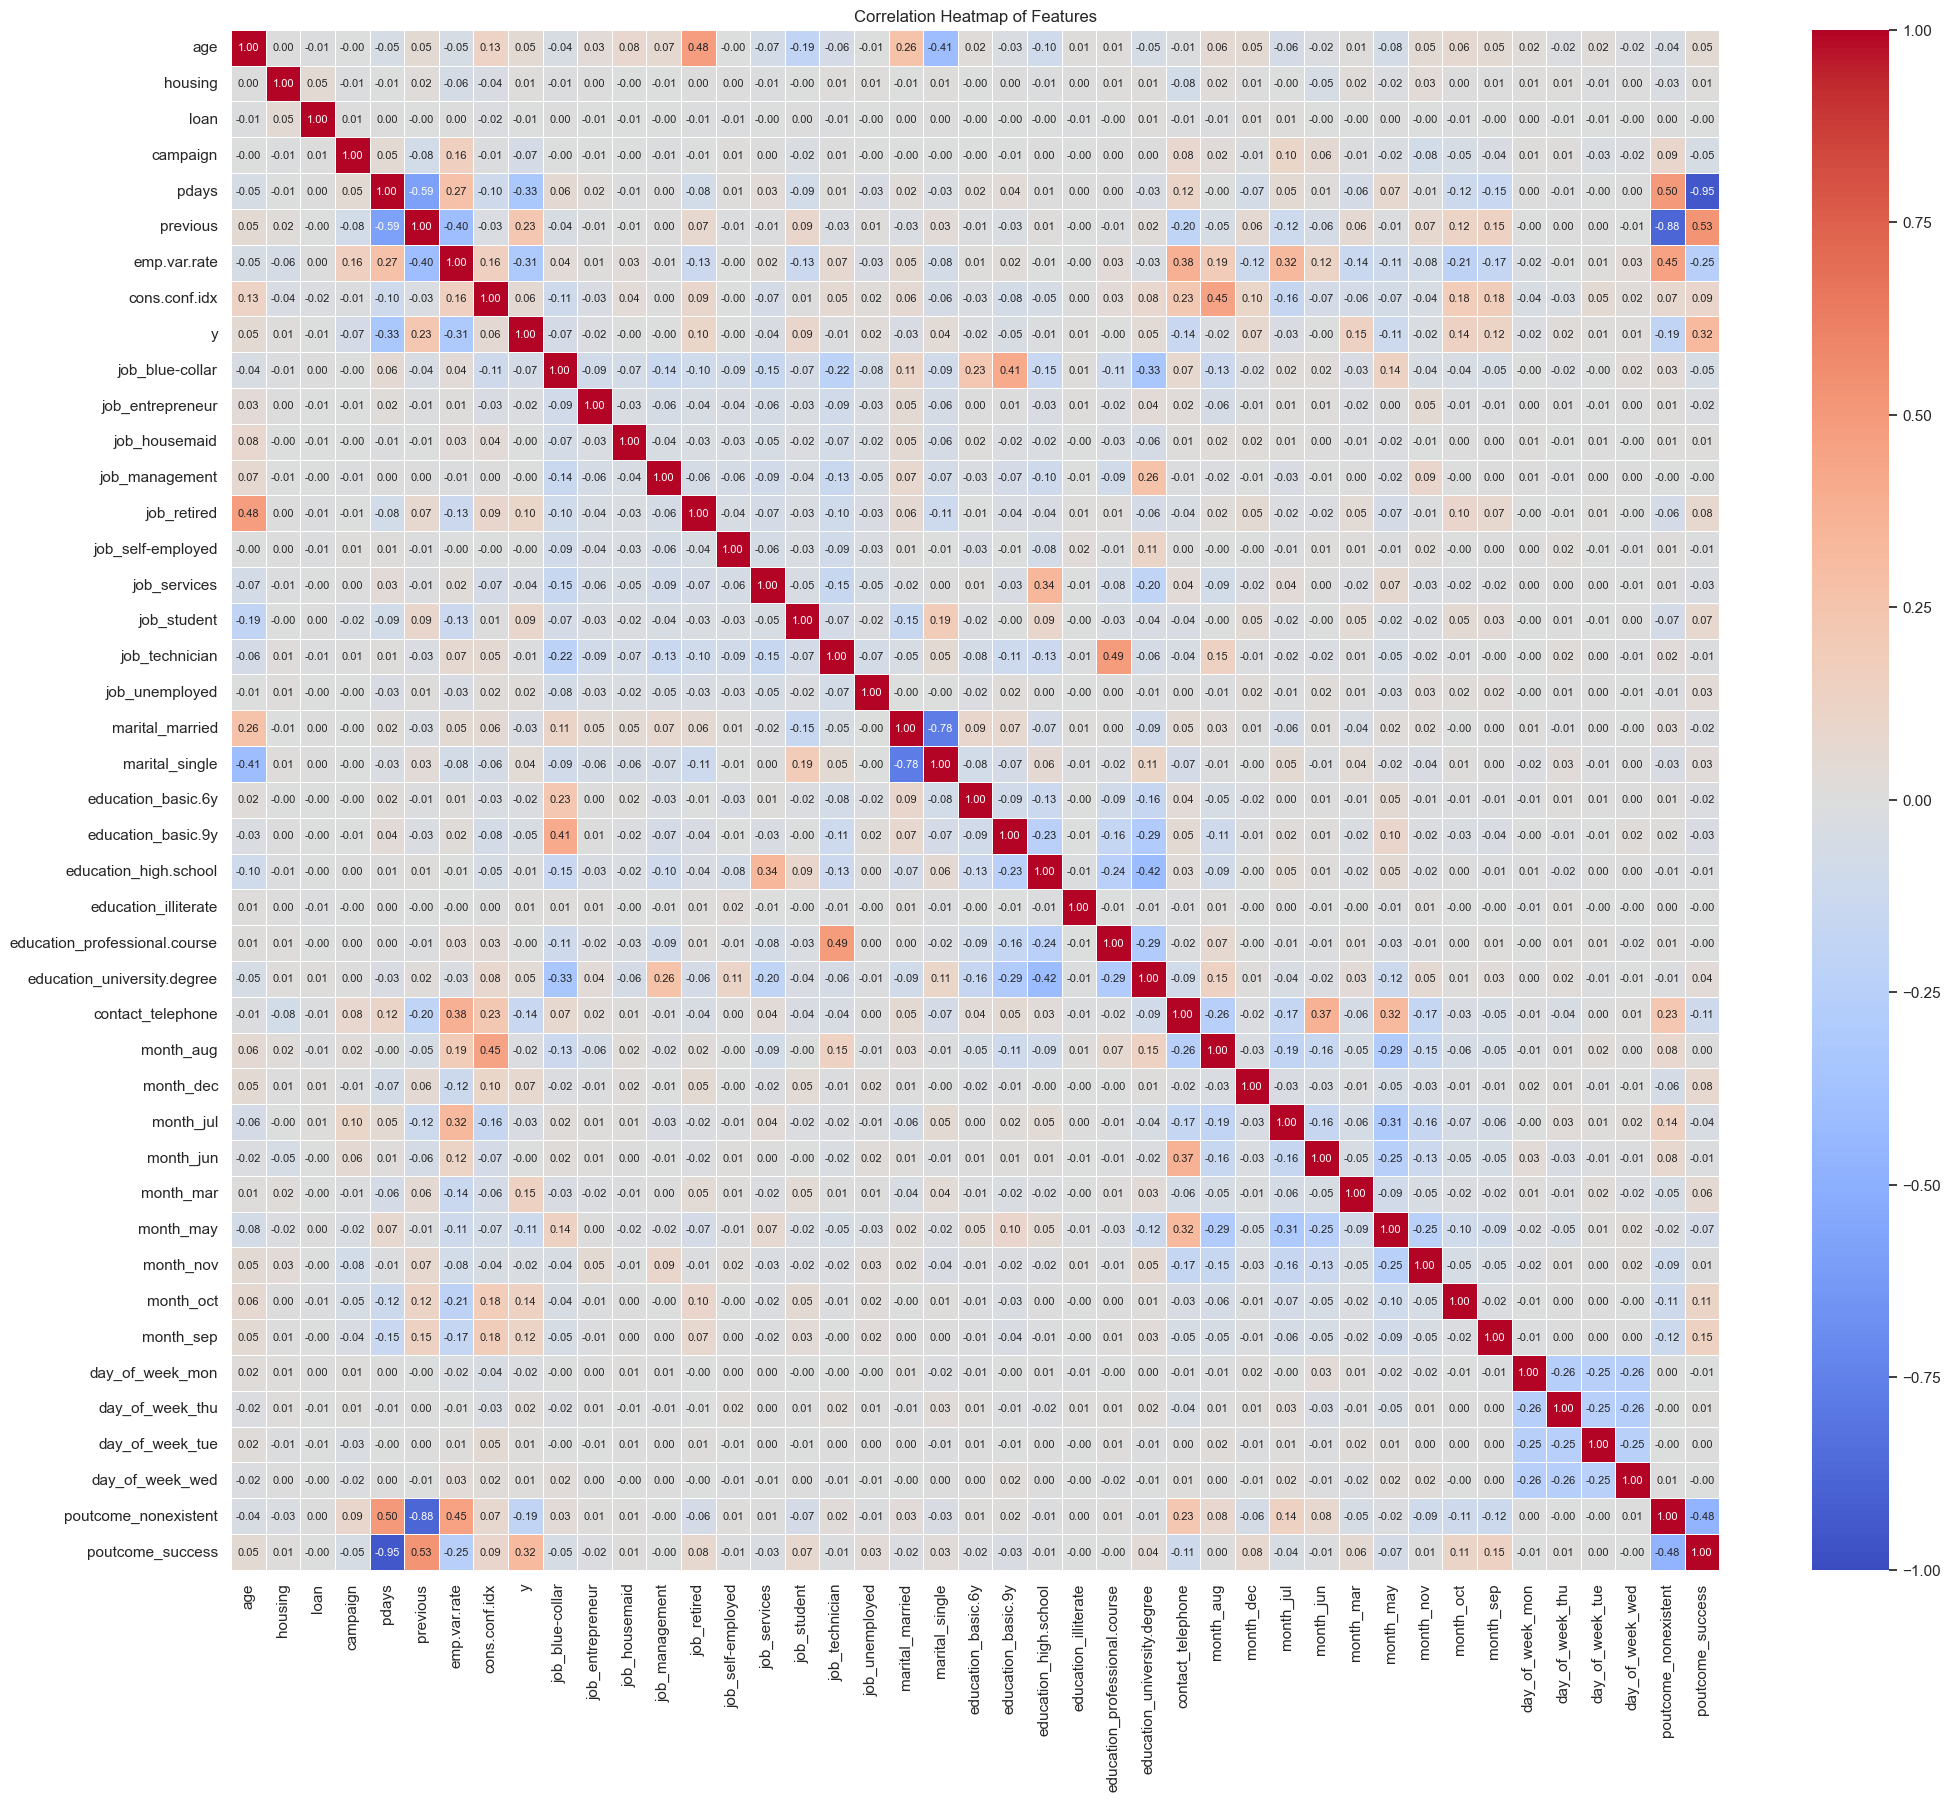

Highly Correlated Features (threshold > +- 0.75):
pdays and poutcome_success: correlation = -0.95
previous and poutcome_nonexistent: correlation = -0.88
marital_married and marital_single: correlation = -0.78
marital_single and marital_married: correlation = -0.78
poutcome_nonexistent and previous: correlation = -0.88
poutcome_success and pdays: correlation = -0.95


In [468]:
# Calculate correlation matrix
correlation_matrix = bank_reduced.corr()

# Plot the correlation heatmap with larger size and formatted annotations
plt.figure(figsize=(24, 20))  # Adjust the figure size (width, height) as necessary
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1,
            linewidths=0.5, annot_kws={"fontsize": 8, "ha": 'center', "va": 'center'}, fmt='.2f')
plt.title('Correlation Heatmap of Features')
plt.show()

# Identify highly correlated features
threshold = 0.75
highly_correlated_features = [(i, j, correlation_matrix.loc[i, j]) 
                              for i in correlation_matrix.columns 
                              for j in correlation_matrix.columns 
                              if i != j and abs(correlation_matrix.loc[i, j]) > threshold]

print("Highly Correlated Features (threshold > +- 0.75):")
for i, j, corr in highly_correlated_features:
    print(f"{i} and {j}: correlation = {corr:.2f}")

I choose to drop `poutcome_success`, `previous`, and `marital_single` due to their high correlation with other features. I re-check correlation after dropping.

Dropped Features:
['poutcome_success', 'previous', 'marital_single']


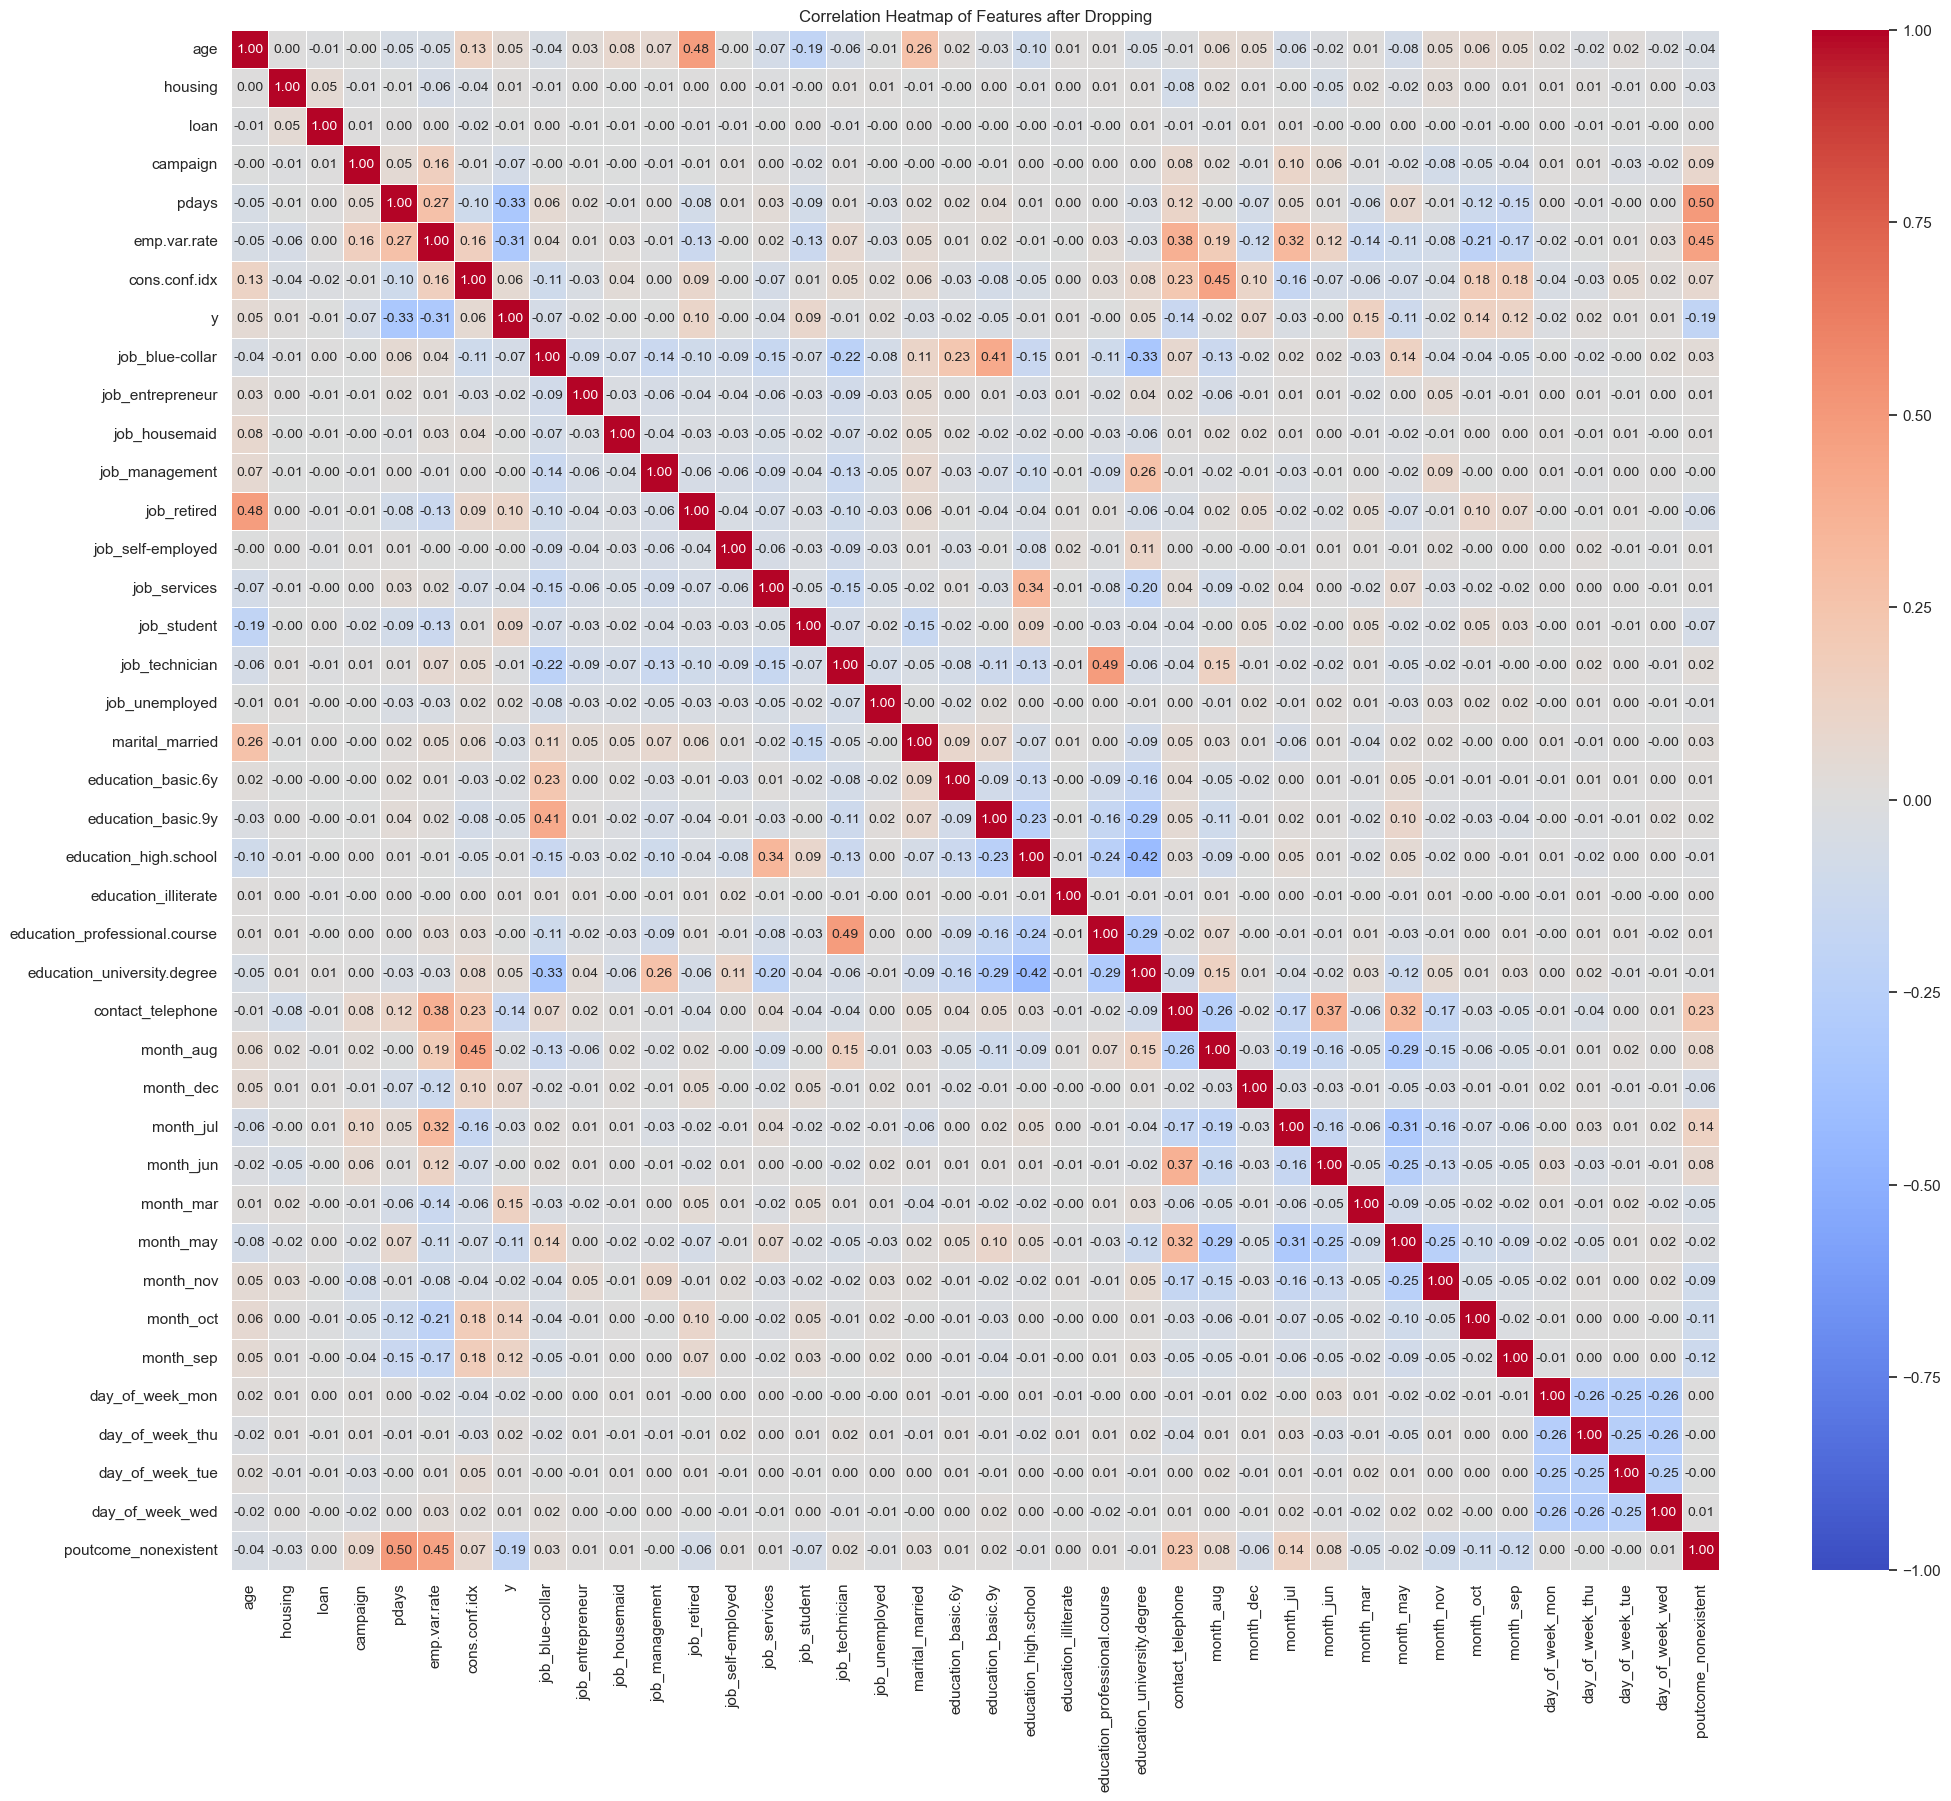

Highly Correlated Features (threshold > +- 0.75) after Dropping:
No highly correlated features found.


In [469]:
# Drop highly correlated features
features_to_drop = ['poutcome_success', 'previous', 'marital_single']

bank_reduced.drop(columns=features_to_drop, inplace=True)

# Verify the dropped features
print("Dropped Features:")
print(features_to_drop)

# Re-calculate the correlation matrix after dropping features
correlation_matrix_after_drop = bank_reduced.corr()

# Re-plot the correlation heatmap after dropping features
plt.figure(figsize=(24, 20))
sns.heatmap(correlation_matrix_after_drop, annot=True, cmap='coolwarm', vmin=-1, vmax=1,
            linewidths=0.5, annot_kws={"fontsize": 10, "ha": 'center', "va": 'center'}, fmt='.2f')
plt.title('Correlation Heatmap of Features after Dropping')
plt.show()

# Identify highly correlated features after dropping
threshold = 0.75
highly_correlated_features_after_drop = [(i, j, correlation_matrix_after_drop.loc[i, j]) 
                                         for i in correlation_matrix_after_drop.columns 
                                         for j in correlation_matrix_after_drop.columns 
                                         if i != j and abs(correlation_matrix_after_drop.loc[i, j]) > threshold]

print("Highly Correlated Features (threshold > +- 0.75) after Dropping:")
if highly_correlated_features_after_drop:
    for i, j, corr in highly_correlated_features_after_drop:
        print(f"{i} and {j}: correlation = {corr:.2f}")
else:
    print("No highly correlated features found.")

Now the dataframe seems to be containing only features with acceptable correlation betwen each other...

In [470]:
bank_reduced.info()
print('The dataframe has {} rows and {} columns.'.format(bank_reduced.shape[0], bank_reduced.shape[1]))
bank_reduced.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30488 entries, 0 to 41187
Data columns (total 40 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            30488 non-null  float64
 1   housing                        30488 non-null  float64
 2   loan                           30488 non-null  float64
 3   campaign                       30488 non-null  float64
 4   pdays                          30488 non-null  float64
 5   emp.var.rate                   30488 non-null  float64
 6   cons.conf.idx                  30488 non-null  float64
 7   y                              30488 non-null  float64
 8   job_blue-collar                30488 non-null  float64
 9   job_entrepreneur               30488 non-null  float64
 10  job_housemaid                  30488 non-null  float64
 11  job_management                 30488 non-null  float64
 12  job_retired                    30488 non-null 

age  housing  loan  campaign     pdays  emp.var.rate  cons.conf.idx  \
0  1.642253      0.0   0.0 -0.559335  0.211887      0.727477       0.877451   
2 -0.196452      1.0   0.0 -0.559335  0.211887      0.727477       0.877451   
3  0.093870      0.0   0.0 -0.559335  0.211887      0.727477       0.877451   
4  1.642253      0.0   1.0 -0.559335  0.211887      0.727477       0.877451   
6  1.932575      0.0   0.0 -0.559335  0.211887      0.727477       0.877451   

     y  job_blue-collar  job_entrepreneur  ...  month_mar  month_may  \
0  0.0              0.0               0.0  ...        0.0        1.0   
2  0.0              0.0               0.0  ...        0.0        1.0   
3  0.0              0.0               0.0  ...        0.0        1.0   
4  0.0              0.0               0.0  ...        0.0        1.0   
6  0.0              0.0               0.0  ...        0.0        1.0   

   month_nov  month_oct  month_sep  day_of_week_mon  day_of_week_thu  \
0        0.0        0.0        0.0              1.0              0.0   
2        0.0        0.0        0.0              1.0              0.0   
3        0.0        0.0        0.0              1.0              0.0   
4        0.0        0.0        0.0              1.0              0.0   
6        0.0        0.0        0.0              1.0              0.0   

   day_of_week_tue  day_of_week_wed  poutcome_nonexistent  
0              0.0              0.0                   1.0  
2              0.0              0.0                   1.0  
3              0.0              0.0                   1.0  
4              0.0              0.0                   1.0  
6              0.0              0.0                   1.0  

[5 rows x 40 columns]

... a unique data type (float), non-null values, comparable values and a total of 30488 rows and 40 columns.

The dataframe seems ready to be used for the model traning.

## **4. Model Training and Evaluation**

The first thing I want to do before starting exploring Machine Learning algorithms, is to split the dataframe into train, test and validation sets.

I will split the full dataframe into training and test sets and then I will split the training set into training and validation.

I will distribute the sets with the following instructions: 
- **80%** of the total database as **training set** and **20%** as **test set**
- **25%** of the **training set** as **validation set** (so, actually, **validation set** will be **20%** of the total)

With the code below, I am going to split the dataset into features and target variable and the split training, test and validation sets.

After the split, I want to check the distribution of `"y"` outcomes in all the sets and compare it with the full data frame distribution to check that the distribution is as random and comparable as possible.

In [471]:
# Split the dataset into features (X) and target (y)
X = bank_reduced.drop('y', axis=1)
y = bank_reduced['y']

# Split dataset into train (80%) and test (20%) sets
X_train_80, X_test, y_train_80, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split training set into training (75%) and validation (25%) sets
X_train, X_valid, y_train, y_valid = train_test_split(X_train_80, y_train_80, test_size=0.25, random_state=42)

# The final split is 60% (train) / 20% (test) / 20% (validation)
# Function to print the distribution of the target variable
def print_target_distribution(y, set_name, count):
    print(f"{set_name} set distribution:")
    print(y.value_counts(normalize=True))
    print(f"Count: {count}")
    print("-" * 55)

# Check the distribution of "yes" and "no" in the target variable "y"
print_target_distribution(y, "Total data", len(y))
print_target_distribution(y_train, "Training", len(y_train))
print_target_distribution(y_test, "Test", len(y_test))
print_target_distribution(y_valid, "Validation", len(y_valid))

Total data set distribution:
0.0    0.873426
1.0    0.126574
Name: y, dtype: float64
Count: 30488
-------------------------------------------------------
Training set distribution:
0.0    0.873661
1.0    0.126339
Name: y, dtype: float64
Count: 18292
-------------------------------------------------------
Test set distribution:
0.0    0.869793
1.0    0.130207
Name: y, dtype: float64
Count: 6098
-------------------------------------------------------
Validation set distribution:
0.0    0.876353
1.0    0.123647
Name: y, dtype: float64
Count: 6098
-------------------------------------------------------


As we can see, we have a "yes" outcome to the target variable of ~ 0.12/0.13 in each set, as the full data frame. Finally, we can go on with the classification task.

We want to use Machine Learning algorithms to predict in the best way the outcome of the target variable `"y"`, that is to predict whether the client will subscribe to a term deposit or not with the Portuguese banking institution.

### **Decision Tree Classifier**

I will start with the **Decision Tree Classifier**. The **Decision Tree Classifier** is ideal due to its interpretability, ability to handle diverse data types without assumptions about distribution, and capability to reveal feature importance, making it a solid baseline for understanding and predicting target variable `"y"` outcomes.

Accuracy on validation set: 0.83

Classification Report:
               precision    recall  f1-score   support

         0.0       0.91      0.89      0.90      5344
         1.0       0.31      0.34      0.32       754

    accuracy                           0.83      6098
   macro avg       0.61      0.62      0.61      6098
weighted avg       0.83      0.83      0.83      6098



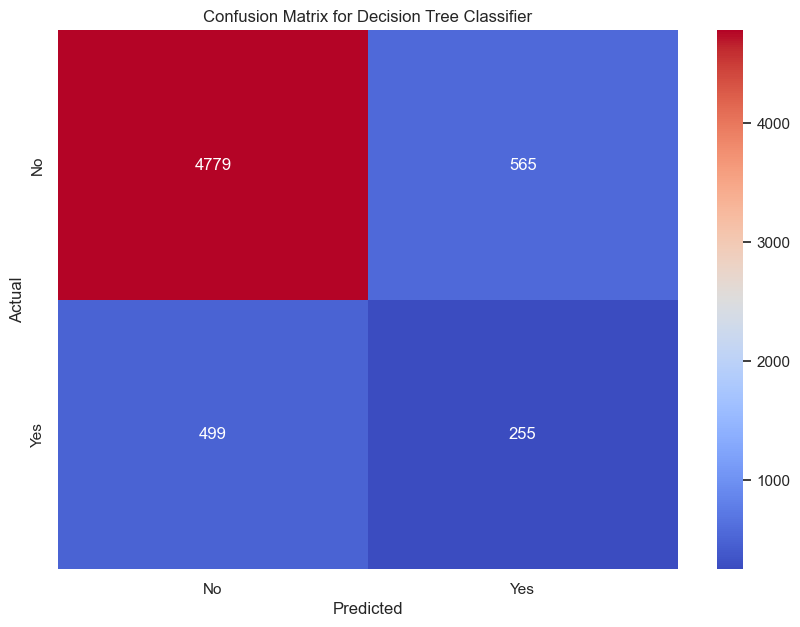

In [472]:
# Initialize the Decision Tree Classifier
decision_tree = DecisionTreeClassifier(random_state=42)

# Train the Decision Tree Classifier
decision_tree.fit(X_train, y_train)

# Predict on the validation set
y_valid_pred = decision_tree.predict(X_valid)

# Evaluate the model
accuracy = accuracy_score(y_valid, y_valid_pred)
classification_rep = classification_report(y_valid, y_valid_pred)
confusion_mat = confusion_matrix(y_valid, y_valid_pred)

# Print the evaluation metrics
print(f"Accuracy on validation set: {accuracy:.2f}")
print("\nClassification Report:\n", classification_rep)

# Plot the Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='coolwarm', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Decision Tree Classifier')
plt.show()

An accuracy of **0.83** is a **good starting point**, but we can improve the performance of the **Decision Tree Classifier** by **tuning its hyperparameters**. Hyperparameters control the learning process and significantly impact model performance. **GridSearchCV** can be used to explore different hyperparameter combinations and find the one that maximizes accuracy (or another relevant metric) on a validation set. This helps prevent overfitting and leads to a model that generalizes better to unseen data. 

Accuracy on validation set with best hyperparameters: 0.89

Classification Report:
               precision    recall  f1-score   support

         0.0       0.90      0.99      0.94      5344
         1.0       0.69      0.19      0.30       754

    accuracy                           0.89      6098
   macro avg       0.79      0.59      0.62      6098
weighted avg       0.87      0.89      0.86      6098



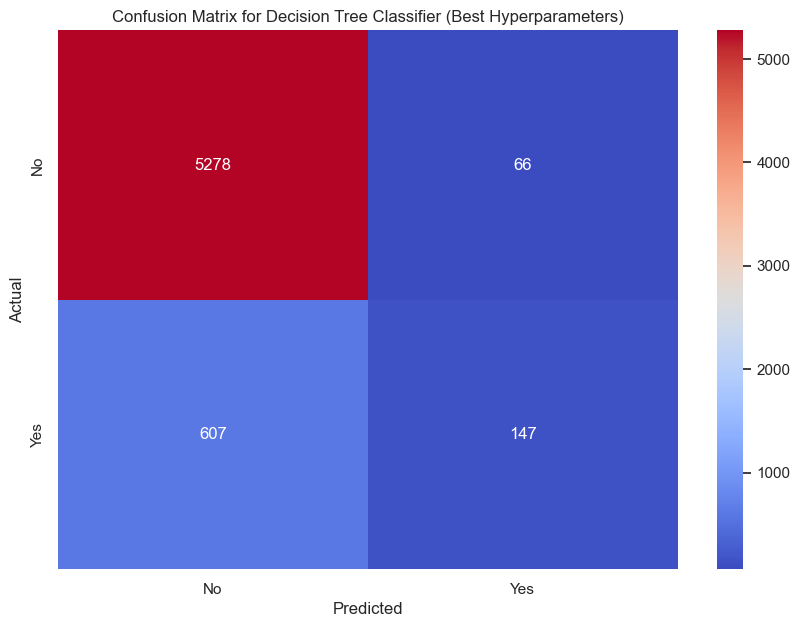

In [473]:
# Define the hyperparameter grid to search
param_grid = {
    'max_depth': [3, 5, 8],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a DecisionTreeClassifier object
decision_tree = DecisionTreeClassifier(random_state=42)

# Use GridSearchCV to find the optimal hyperparameters
grid_search = GridSearchCV(decision_tree, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Use the best model for prediction on validation set
y_valid_pred = best_model.predict(X_valid)

# Evaluate the model with the best hyperparameters
accuracy = accuracy_score(y_valid, y_valid_pred)
print(f"Accuracy on validation set with best hyperparameters: {accuracy:.2f}")

# Classification Report with best hyperparameters
print("\nClassification Report:\n", classification_report(y_valid, y_valid_pred))

# Confusion Matrix with best hyperparameters
confusion_mat = confusion_matrix(y_valid, y_valid_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='coolwarm', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Decision Tree Classifier (Best Hyperparameters)')
plt.show()

The performance **improved** a bit. Let's see if we can improve the performance even more with a **larger hyperparameter grid** to explore a wider range of possible configurations for the **Decision Tree Classifier**. This allows the **GridSearchCV** to potentially find a better combination of hyperparameters that optimizes the model's performance on your specific dataset.

Accuracy on validation set with best hyperparameters: 0.89

Classification Report:
               precision    recall  f1-score   support

         0.0       0.90      0.99      0.94      5344
         1.0       0.69      0.19      0.30       754

    accuracy                           0.89      6098
   macro avg       0.79      0.59      0.62      6098
weighted avg       0.87      0.89      0.86      6098



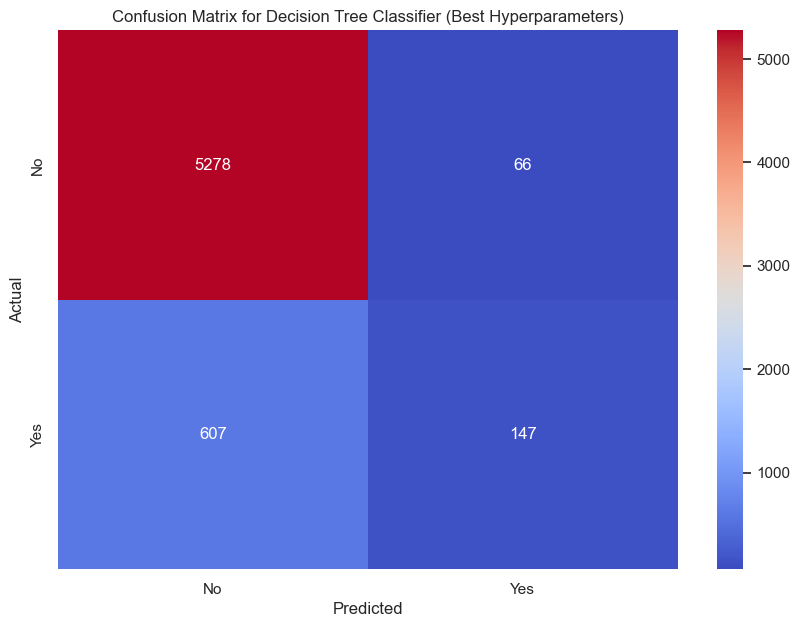

In [474]:
# Define a larger hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 8, 10, 12],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 8, 10]
}

# Create a DecisionTreeClassifier object
decision_tree = DecisionTreeClassifier(random_state=42)

# Use GridSearchCV with the new grid
grid_search = GridSearchCV(decision_tree, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Use the best model for prediction on validation set
y_valid_pred = best_model.predict(X_valid)

# Evaluate the model with the best hyperparameters
accuracy = accuracy_score(y_valid, y_valid_pred)
print(f"Accuracy on validation set with best hyperparameters: {accuracy:.2f}")

# Classification Report with best hyperparameters
print("\nClassification Report:\n", classification_report(y_valid, y_valid_pred))

# Confusion Matrix with best hyperparameters
confusion_mat = confusion_matrix(y_valid, y_valid_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='coolwarm', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Decision Tree Classifier (Best Hyperparameters)')
plt.show()

Actually, the performance didn't change. It might be because the original grid might have already captured the "good" regions of the hyperparameter space. And thus, increasing the search range, might not have found significantly better configurations.

I would like to generate some plots to show the performance of the Decision Tree Classifier.

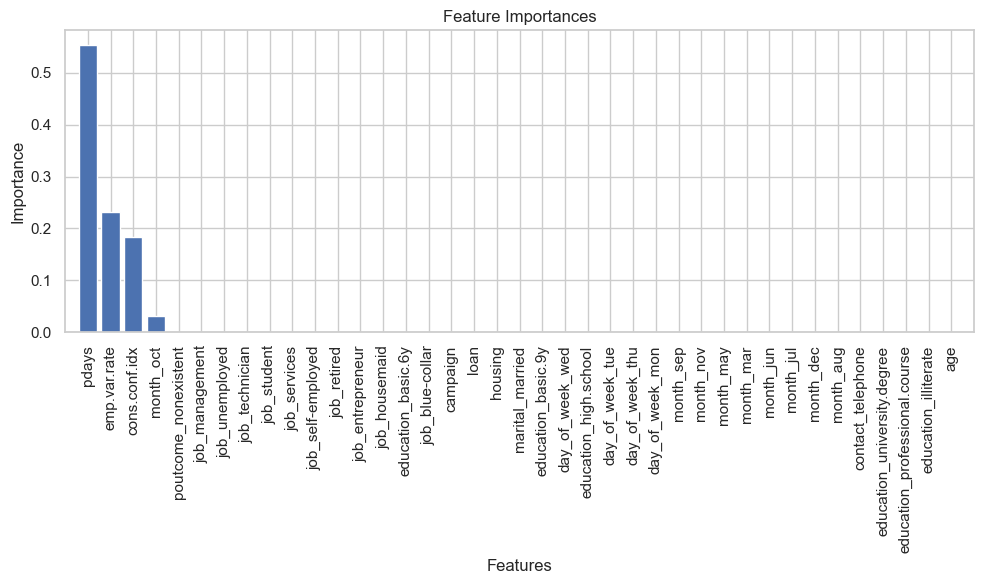

In [475]:
def plot_feature_importance(model, X_train):
  """
  Plots feature importance using the model's feature_importances_ attribute.

  Args:
      model: The trained DecisionTreeClassifier model.
      X_train: Training set features.
  """
  # Extract feature importances
  importances = model.feature_importances_
  features = X_train.columns

  # Sort feature importances in descending order
  indices = np.argsort(importances)[::-1]

  # Rearrange feature names so they match the sorted feature importances
  sorted_features = [features[i] for i in indices]

  # Plot
  plt.figure(figsize=(10, 6))
  plt.title("Feature Importances")
  plt.bar(range(X_train.shape[1]), importances[indices], align="center")
  plt.xticks(range(X_train.shape[1]), sorted_features, rotation=90)
  plt.xlim([-1, X_train.shape[1]])
  plt.xlabel("Features")
  plt.ylabel("Importance")
  plt.tight_layout()
  plt.show()

# Plot feature importance using the best model
plot_feature_importance(best_model, X_train)


The feature importances plot show that `pdays` is the dominant factor influencing the model's predictions, followed by `emp.var.rate` and `cons.conf.idx` with moderate importance. `Month_oct` has minimal influence.

Seeing only a few important features suggests sparsity in the data or the model. This means most features have little impact on the target variable, and the model focuses on a select few for prediction.

And I plot the learning curve.

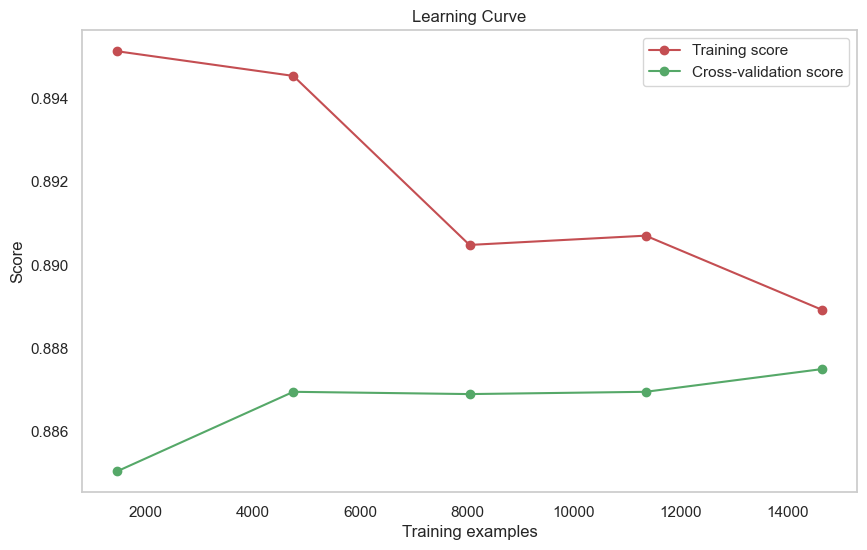

In [476]:
def plot_learning_curve(estimator, X, y, cv=5):
    train_sizes, train_scores, valid_scores = learning_curve(estimator, X, y, cv=cv, scoring='accuracy')
    train_scores_mean = train_scores.mean(axis=1)
    valid_scores_mean = valid_scores.mean(axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, valid_scores_mean, 'o-', color='g', label='Cross-validation score')

    plt.title('Learning Curve')
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

plot_learning_curve(best_model, X_train, y_train)

The **Decision Tree Classifier** achieved an accuracy of **0.89**, with high precision and recall for `"no"`, but low for `"yes"`. Despite tuning hyperparameters, the model still struggles with the imbalanced data, reflected in the **lower F1 score for `"no"`**. The feature importance plot suggests only a few features significantly influence predictions. This analysis highlights the need for more advanced models or techniques to better handle class imbalance and improve overall performance.

Here is the **Decision Tree Classifier** graph.

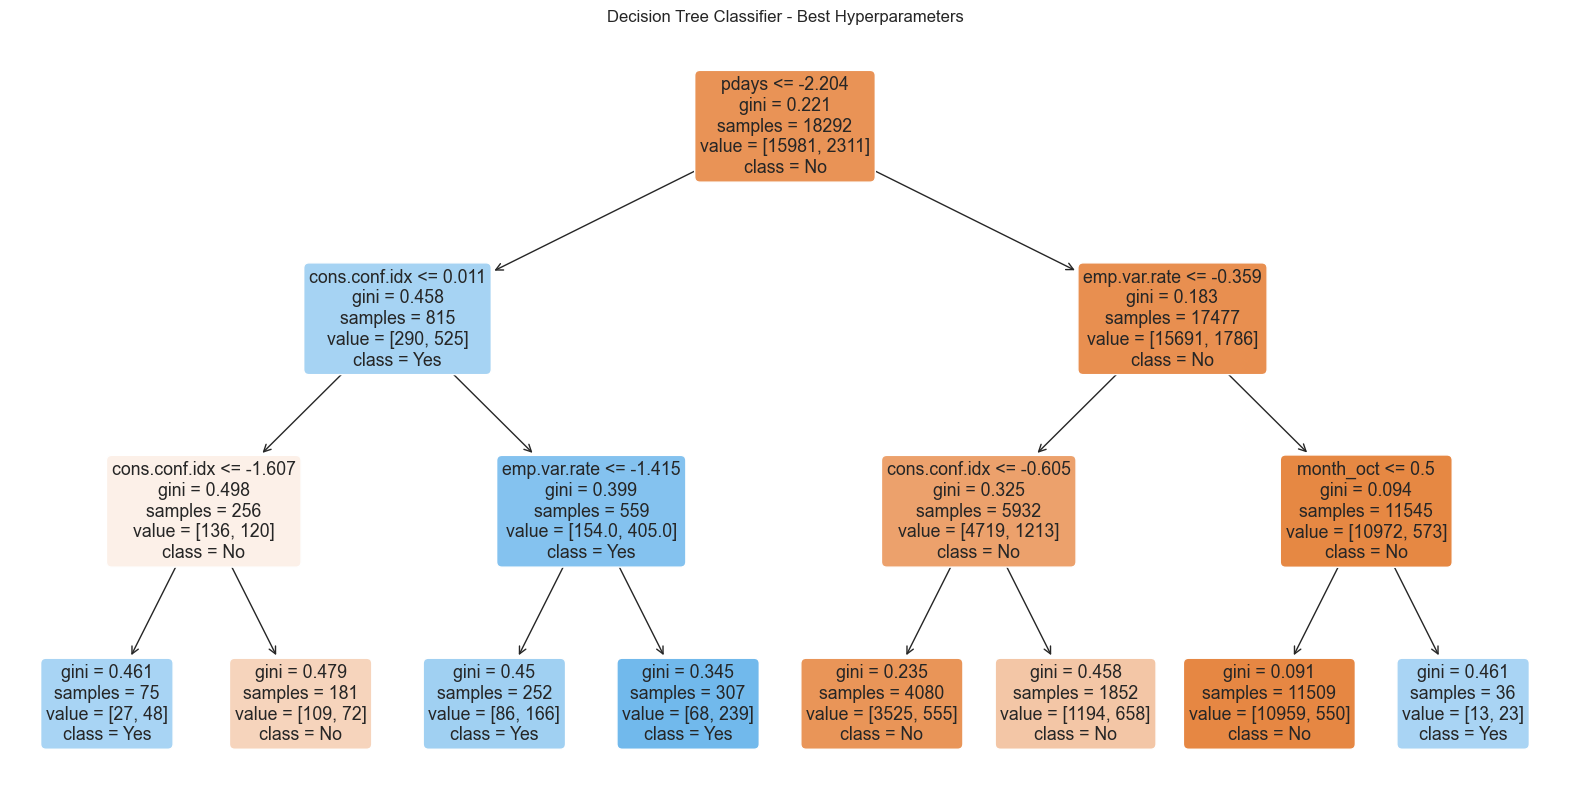

In [477]:
# Plot the Decision Tree Classifier with best hyperparameters
plt.figure(figsize=(20, 10)) 
plot_tree(best_model, filled=True, feature_names=X.columns, class_names=['No', 'Yes'], rounded=True)
plt.title('Decision Tree Classifier - Best Hyperparameters')
plt.show()

### **Random Forest Classifier**

Now I want to try the **Random Forest Classifier**. This approach should improve upon the **Decision Tree Classifier** by leveraging *ensemble learning*, which combines multiple decision trees to *reduce overfitting* and *increase predictive accuracy*. Random Forests also handle *feature importance* *more robustly*, which is beneficial for complex datasets like this.

The **Random Forest Classifier** is initialized and trained on the training data. It's then evaluated on the validation set to assess its predictive performance.

Accuracy on validation set: 0.88

Classification Report:
               precision    recall  f1-score   support

         0.0       0.91      0.96      0.93      5344
         1.0       0.53      0.29      0.38       754

    accuracy                           0.88      6098
   macro avg       0.72      0.63      0.66      6098
weighted avg       0.86      0.88      0.86      6098



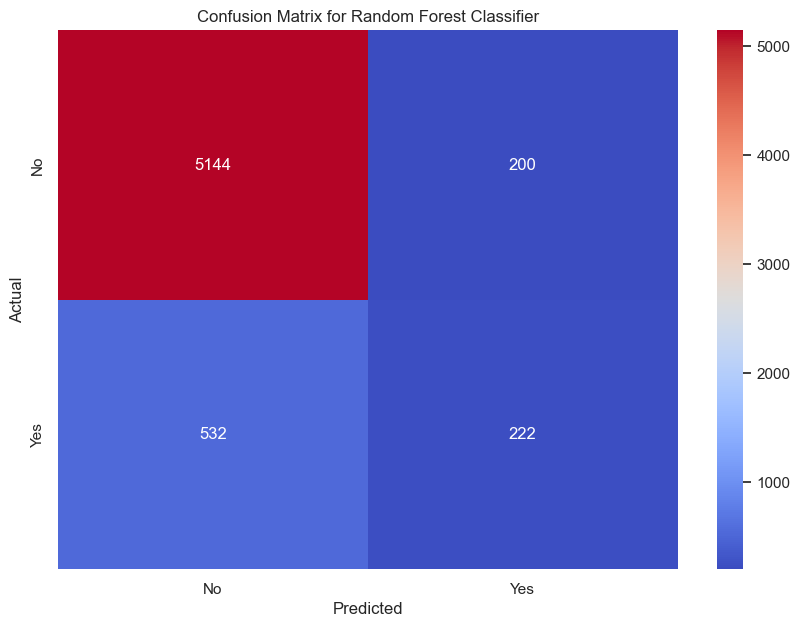

In [478]:
# Initialize the Random Forest Classifier
random_forest = RandomForestClassifier(random_state=42)

# Train the Random Forest Classifier
random_forest.fit(X_train, y_train)

# Predict on the validation set
y_valid_pred_rf = random_forest.predict(X_valid)

# Evaluate the model
accuracy_rf = accuracy_score(y_valid, y_valid_pred_rf)
classification_rep_rf = classification_report(y_valid, y_valid_pred_rf)
confusion_mat_rf = confusion_matrix(y_valid, y_valid_pred_rf)

# Print the evaluation metrics
print(f"Accuracy on validation set: {accuracy_rf:.2f}")
print("\nClassification Report:\n", classification_rep_rf)

# Plot the Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_mat_rf, annot=True, fmt='d', cmap='coolwarm', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()

The **Random Forest Classifier** shows an improved accuracy of 0.88 on the validation set compared to the **Decision Tree Classifier**. However, the precision, recall, and F1-score for the `"yes"` are relatively low, indicating that the model struggles with correctly identifying customers who will subscribe to a term deposit (low recall) and misclassifies some non-subscribers as subscribers (low precision).

Now I will conduct a **grid search** across defined ranges of `max_depth` and `max_leaf_nodes` to identify the best Random Forest model, chosen for its highest validation F1 score.

In [479]:
# Define the ranges for max_depth and max_leaf_nodes
depth_range = range(16, 30, 3)
leaves_range = range(6, 30, 2)

# Variables to store the best model and its performance
best_f1_score = -1
best_model = None
best_params = {}

# Iterate over all combinations of max_depth and max_leaf_nodes
for depth in depth_range:
    for leaves in leaves_range:
        # Initialize Random Forest Classifier with current parameters
        model = RandomForestClassifier(max_depth=depth, max_leaf_nodes=leaves, random_state=42)
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Predict on validation set
        y_pred = model.predict(X_valid)
        
        # Calculate F1 score
        f1 = f1_score(y_valid, y_pred, average='weighted')
        
        # Print F1 score for current parameters
        print(f"max_depth={depth}, max_leaf_nodes={leaves}: Validation F1 Score = {f1}")
        
        # Check if this model is the best so far
        if f1 > best_f1_score:
            best_f1_score = f1
            best_model = model
            best_params = {'max_depth': depth, 'max_leaf_nodes': leaves}

# Print the best model's parameters and performance
print("\nBest Parameters:")
print(best_params)
print("Best Validation F1 Score:", best_f1_score)

max_depth=16, max_leaf_nodes=6: Validation F1 Score = 0.8256853254856645
max_depth=16, max_leaf_nodes=8: Validation F1 Score = 0.8521720604854941
max_depth=16, max_leaf_nodes=10: Validation F1 Score = 0.8562894773684614
max_depth=16, max_leaf_nodes=12: Validation F1 Score = 0.8595129983109101
max_depth=16, max_leaf_nodes=14: Validation F1 Score = 0.8602762223478789
max_depth=16, max_leaf_nodes=16: Validation F1 Score = 0.8606207387540626
max_depth=16, max_leaf_nodes=18: Validation F1 Score = 0.861083550864524
max_depth=16, max_leaf_nodes=20: Validation F1 Score = 0.8614963783508108
max_depth=16, max_leaf_nodes=22: Validation F1 Score = 0.8617873775125523
max_depth=16, max_leaf_nodes=24: Validation F1 Score = 0.8614963783508108
max_depth=16, max_leaf_nodes=26: Validation F1 Score = 0.861083550864524
max_depth=16, max_leaf_nodes=28: Validation F1 Score = 0.8617873775125523
max_depth=19, max_leaf_nodes=6: Validation F1 Score = 0.8256853254856645
max_depth=19, max_leaf_nodes=8: Validation 

Accuracy on test set: 0.88

Classification Report on test set:
               precision    recall  f1-score   support

         0.0       0.89      0.99      0.94      5304
         1.0       0.72      0.17      0.28       794

    accuracy                           0.88      6098
   macro avg       0.80      0.58      0.61      6098
weighted avg       0.87      0.88      0.85      6098



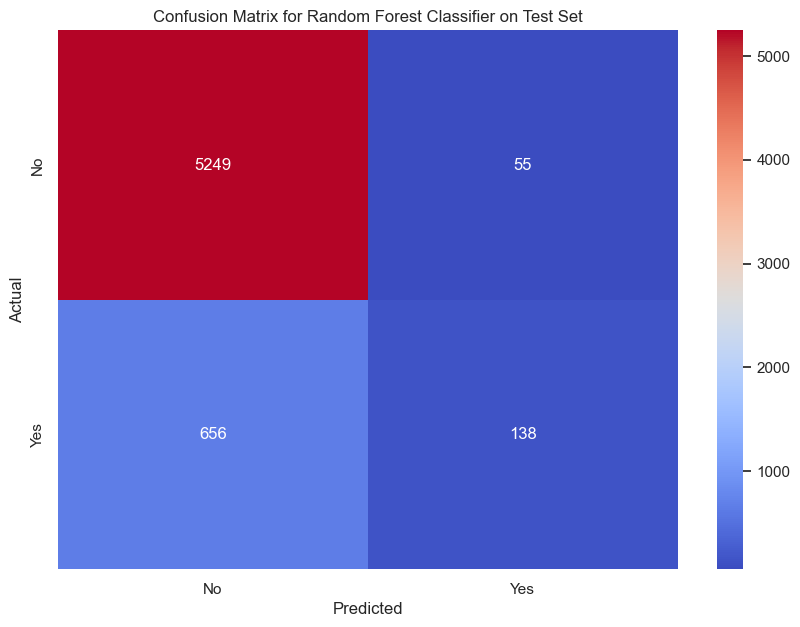

In [480]:
# Initialize the Random Forest Classifier with best parameters
best_random_forest = RandomForestClassifier(max_depth=16, max_leaf_nodes=22, random_state=42)

# Train the Random Forest Classifier on the entire training set
best_random_forest.fit(X_train, y_train)

# Predict on the test set
y_test_pred_rf = best_random_forest.predict(X_test)

# Evaluate the model
accuracy_rf_test = accuracy_score(y_test, y_test_pred_rf)
classification_rep_rf_test = classification_report(y_test, y_test_pred_rf)
confusion_mat_rf_test = confusion_matrix(y_test, y_test_pred_rf)

# Print the evaluation metrics on test set
print(f"Accuracy on test set: {accuracy_rf_test:.2f}")
print("\nClassification Report on test set:\n", classification_rep_rf_test)

# Plot the Confusion Matrix for test set
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_mat_rf_test, annot=True, fmt='d', cmap='coolwarm', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest Classifier on Test Set')
plt.show()

In comparison, the initial attempt achieved higher recall for class `"yes"` but lower precision and F1-score overall, indicating it was better at correctly identifying positive cases but had more false positives. The current attempt shows improved precision for class `"yes"`, indicating fewer false positives, but at the cost of lower recall, suggesting it misses more positive cases.

In [481]:
df_train = pd.DataFrame({'target': y_train})

# Count samples in each class
class_counts = df_train['target'].value_counts()

# Assuming '0' represents 'no' and '1' represents 'yes'
count_no = class_counts[0]
count_yes = class_counts[1]

# Calculate imbalance ratio
imbalance_ratio = count_no / count_yes

print(f"Imbalance Ratio: {imbalance_ratio:.2f}")

Imbalance Ratio: 6.92


Accuracy on test set: 0.82

Classification Report on test set:
               precision    recall  f1-score   support

         0.0       0.94      0.85      0.89      5304
         1.0       0.38      0.63      0.47       794

    accuracy                           0.82      6098
   macro avg       0.66      0.74      0.68      6098
weighted avg       0.87      0.82      0.84      6098



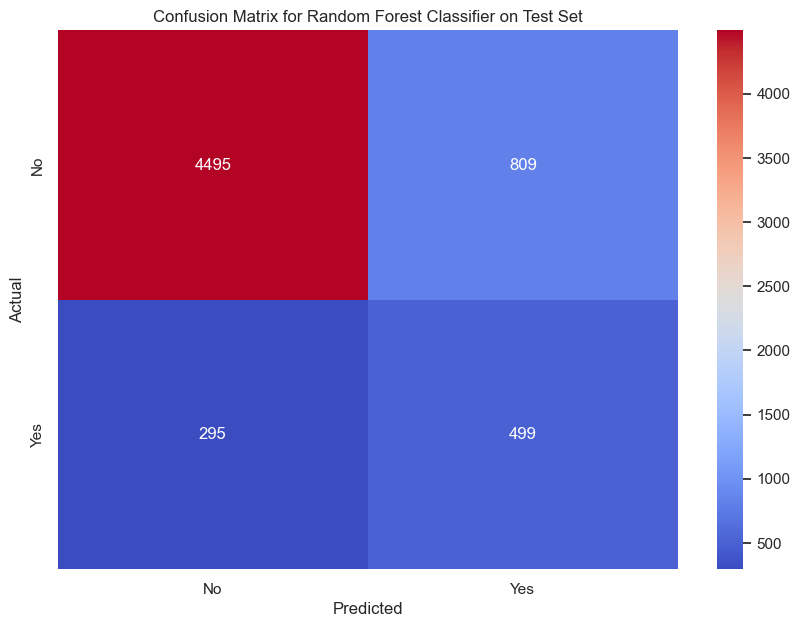

In [482]:
# Define the class weights based on your preference
class_weights = {0: 1, 1: 6.92}

# Initialize the Random Forest Classifier with best parameters and updated class weights
best_random_forest = RandomForestClassifier(max_depth=16, max_leaf_nodes=22, random_state=42, class_weight=class_weights)

# Train the Random Forest Classifier on the entire training set
best_random_forest.fit(X_train, y_train)

# Predict on the test set
y_test_pred_rf = best_random_forest.predict(X_test)

# Evaluate the model
accuracy_rf_test = accuracy_score(y_test, y_test_pred_rf)
classification_rep_rf_test = classification_report(y_test, y_test_pred_rf)
confusion_mat_rf_test = confusion_matrix(y_test, y_test_pred_rf)

# Print the evaluation metrics on test set
print(f"Accuracy on test set: {accuracy_rf_test:.2f}")
print("\nClassification Report on test set:\n", classification_rep_rf_test)

# Plot the Confusion Matrix for test set
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_mat_rf_test, annot=True, fmt='d', cmap='coolwarm', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest Classifier on Test Set')
plt.show()

I tried to change **class weights** and I got a better F1 score for `"y"` but with a smaller overall accuracy.

Now I plot the **ROC (Receiver Operating Characteristic)** curve that illustrates the performance of the binary classifier across various thresholds. The **AUC (Area Under the Curve)** score summarizes the ROC curve into a single metric, indicating the model's ability to distinguish between classes.

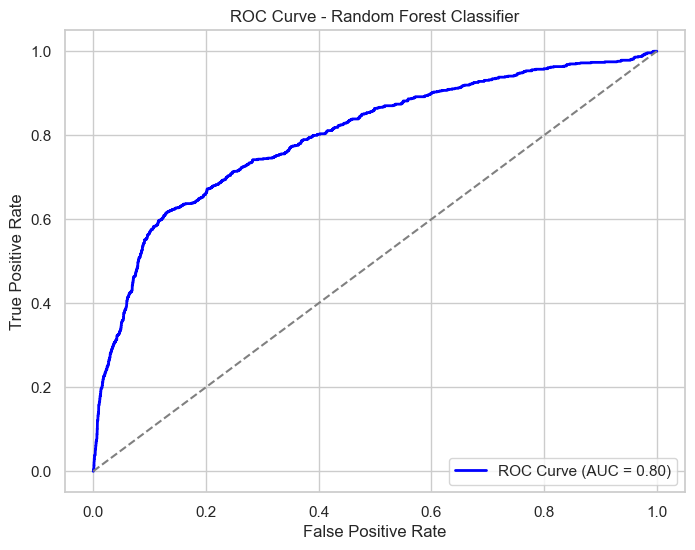

In [483]:
# Compute predicted probabilities for class 1
y_probs_rf = best_random_forest.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs_rf)

# Calculate AUC score
auc_score = roc_auc_score(y_test, y_probs_rf)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest Classifier')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

And the **Precision-Recall** curve which plots precision against recall, providing insights into how well the classifier is performing, particularly for the minority class (`"yes"`).

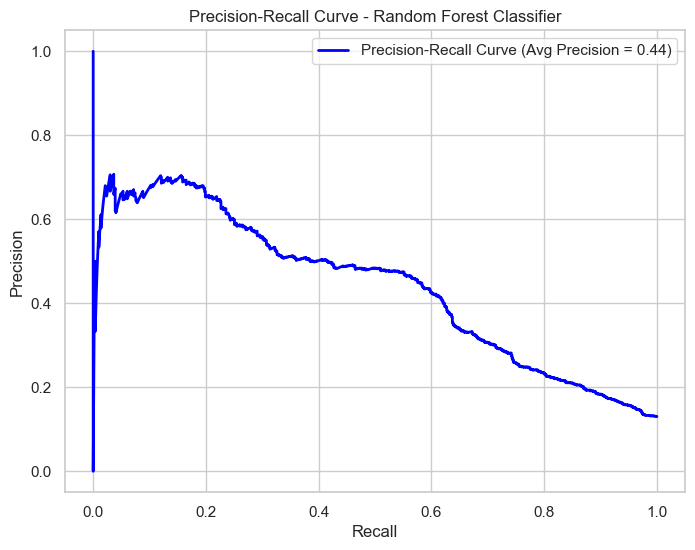

In [484]:
# Calculate precision and recall
precision, recall, _ = precision_recall_curve(y_test, y_probs_rf)

# Calculate average precision score
avg_precision = average_precision_score(y_test, y_probs_rf)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall Curve (Avg Precision = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Random Forest Classifier')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

But also the **Feature Importance** plot that helps identify which features have the most significant impact on the model's predictions.

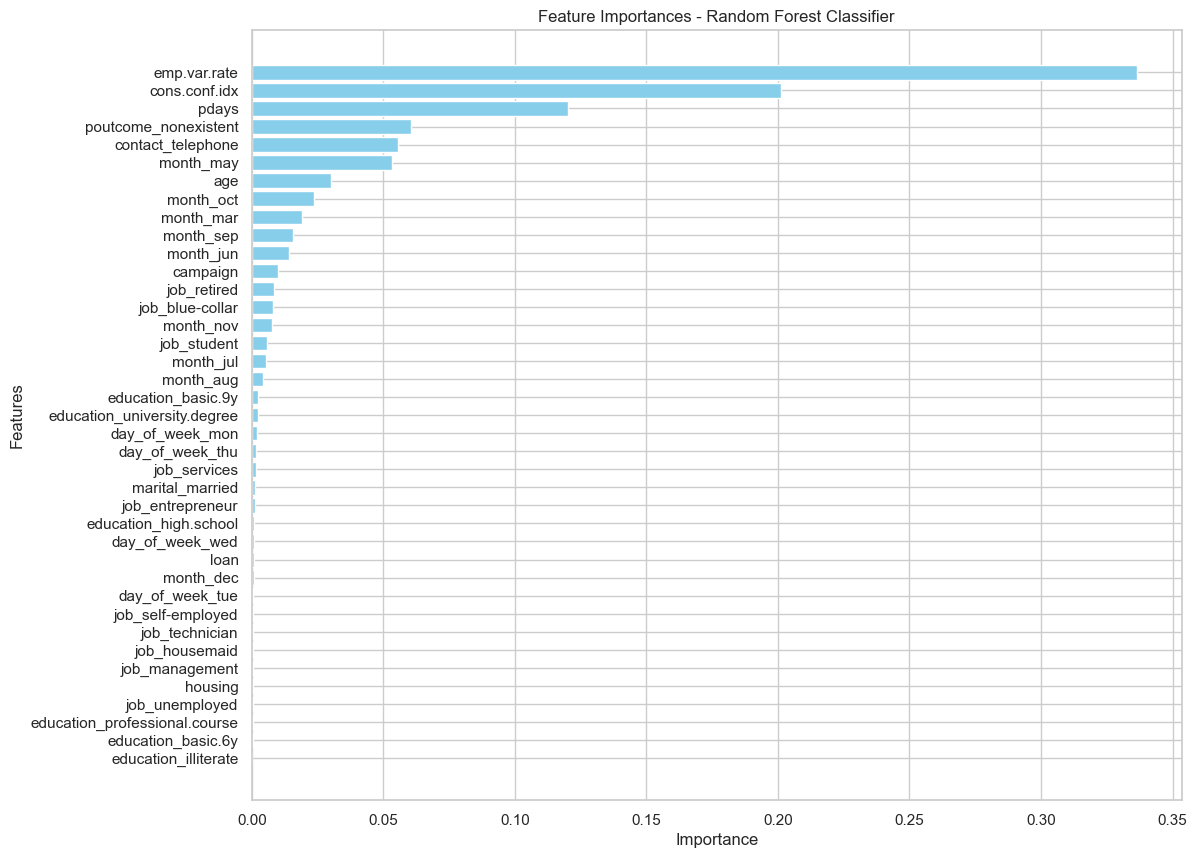

In [485]:
# Get feature importances from the model
feature_importances = best_random_forest.feature_importances_
sorted_idx = np.argsort(feature_importances)[::-1]
features = X.columns[sorted_idx]  # All features sorted by importance

# Plot Feature Importance
plt.figure(figsize=(12, 10))
plt.barh(features, feature_importances[sorted_idx], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances - Random Forest Classifier')
plt.gca().invert_yaxis()
plt.show()

Compared to the **Decision Tree Classifier**, we see that the **Random Forest Classifier** takes into consideration a *wide range* of features with high importance.

Here is the **Random Forest Classifier** graph.

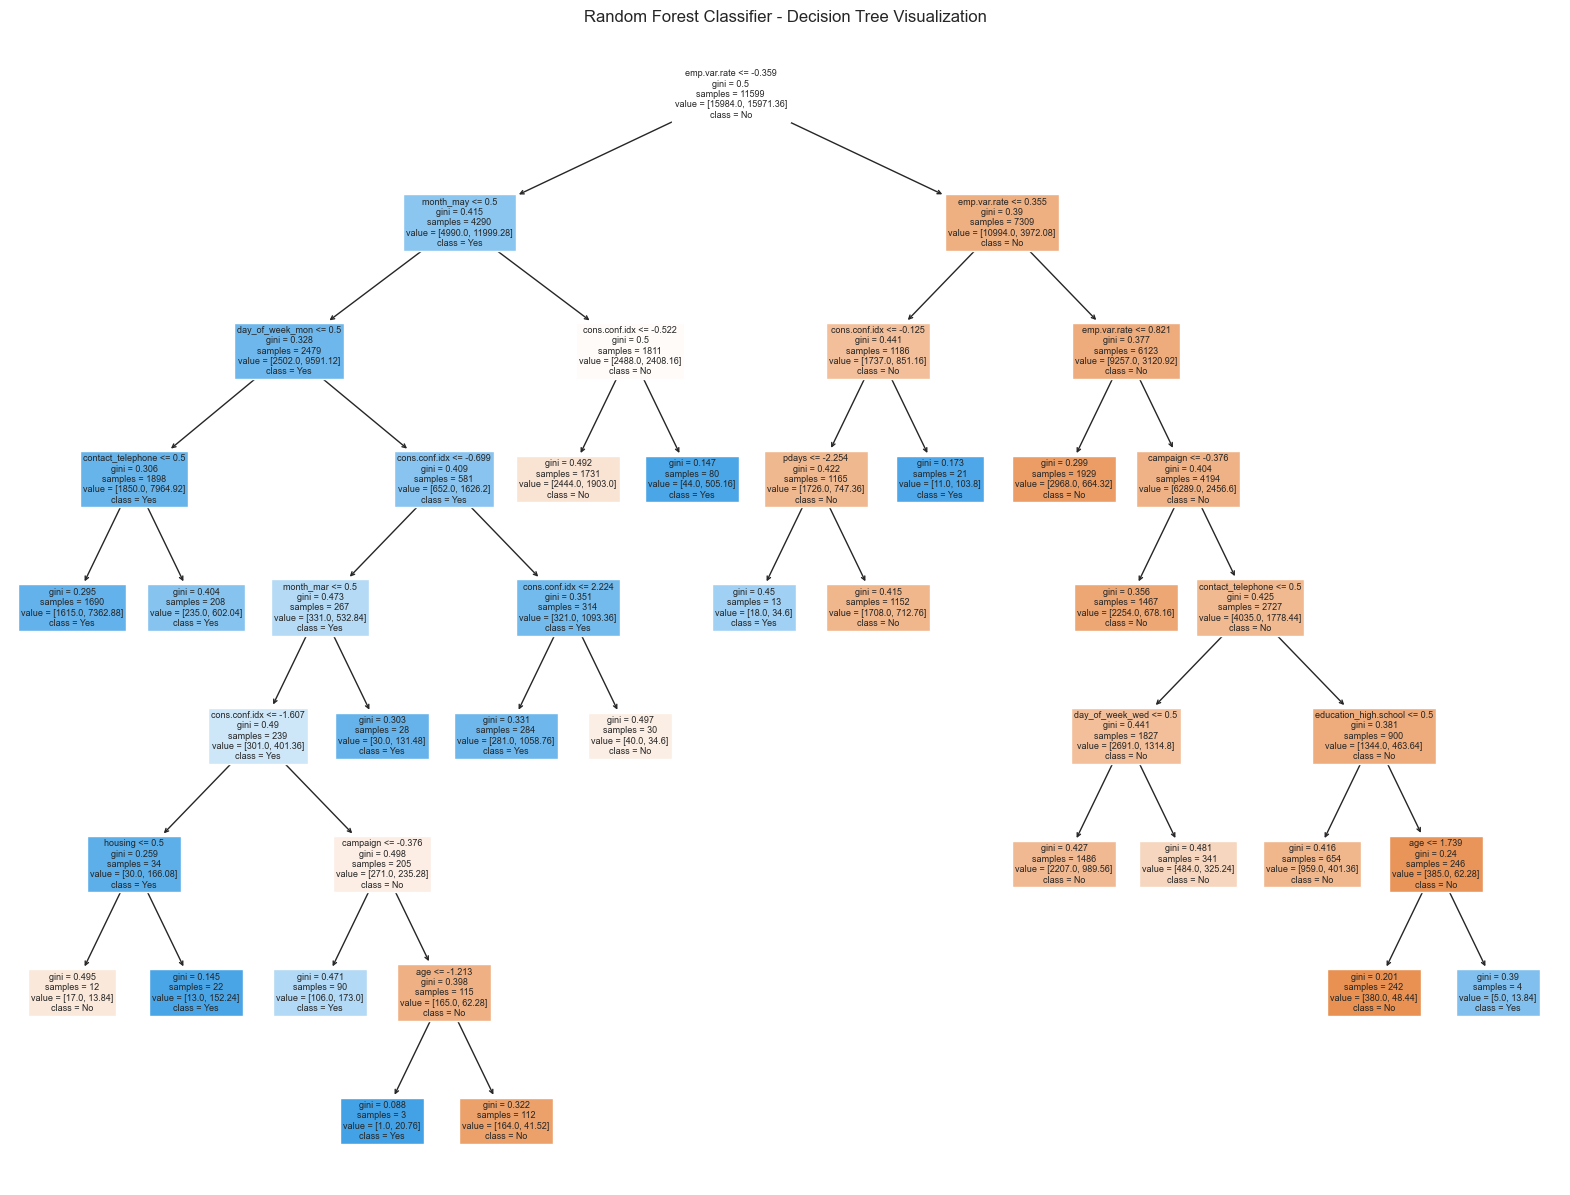

In [486]:
# Get one of the trees from the forest (assuming best_random_forest is already trained)
estimator = best_random_forest.estimators_[0]

# Plot the tree
plt.figure(figsize=(20, 15))
tree.plot_tree(estimator, feature_names=X.columns, class_names=["No", "Yes"], filled=True)
plt.title('Random Forest Classifier - Decision Tree Visualization')
plt.show()

### **Logistic Regression**

Now I am going to explore **Logistic Regression**, given that I have a binary target variable `"y"`. **Logistic Regression** is well-suited for binary classification tasks due to its ability to output probabilities directly. It should perform well if the relationships between features and the target are linear but might underperform compared to ensemble methods on capturing complex, non-linear patterns.

Accuracy on validation set: 0.89

Classification Report:
               precision    recall  f1-score   support

         0.0       0.90      0.98      0.94      5344
         1.0       0.62      0.21      0.32       754

    accuracy                           0.89      6098
   macro avg       0.76      0.60      0.63      6098
weighted avg       0.86      0.89      0.86      6098



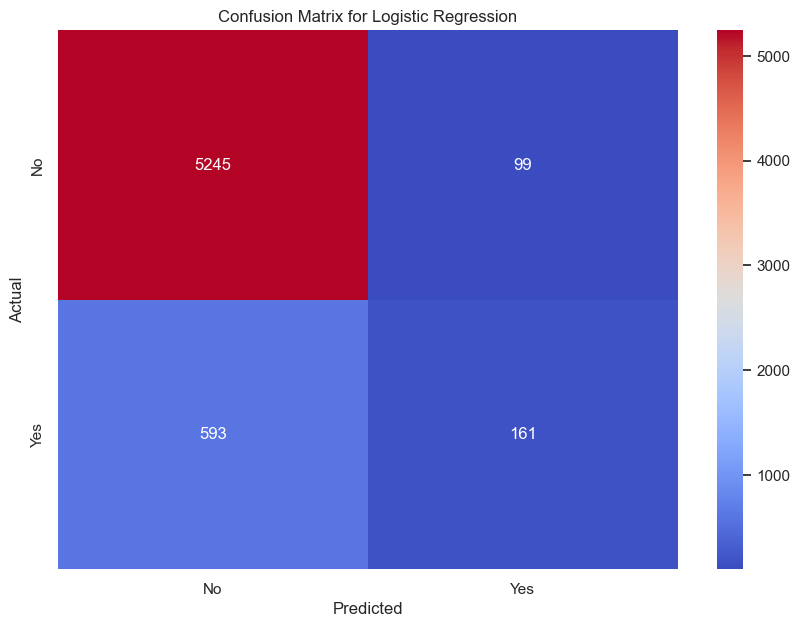

In [487]:
# Define the Logistic Regression model
log_reg = LogisticRegression(random_state=42, max_iter=1000)

# Train the model on the training data
log_reg.fit(X_train, y_train)

# Make predictions on the validation set
y_valid_pred = log_reg.predict(X_valid)

# Evaluate the model
accuracy = accuracy_score(y_valid, y_valid_pred)
print(f"Accuracy on validation set: {accuracy:.2f}")

# Classification Report
print("\nClassification Report:\n", classification_report(y_valid, y_valid_pred))

# Confusion Matrix
confusion_mat = confusion_matrix(y_valid, y_valid_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='coolwarm', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

To improve performance, especially for the minority class (`"y"`), I will use class weights in the **Logistic Regression** model to handle the class imbalance.

Accuracy on validation set: 0.81

Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.83      0.88      5344
         1.0       0.35      0.66      0.46       754

    accuracy                           0.81      6098
   macro avg       0.65      0.74      0.67      6098
weighted avg       0.87      0.81      0.83      6098



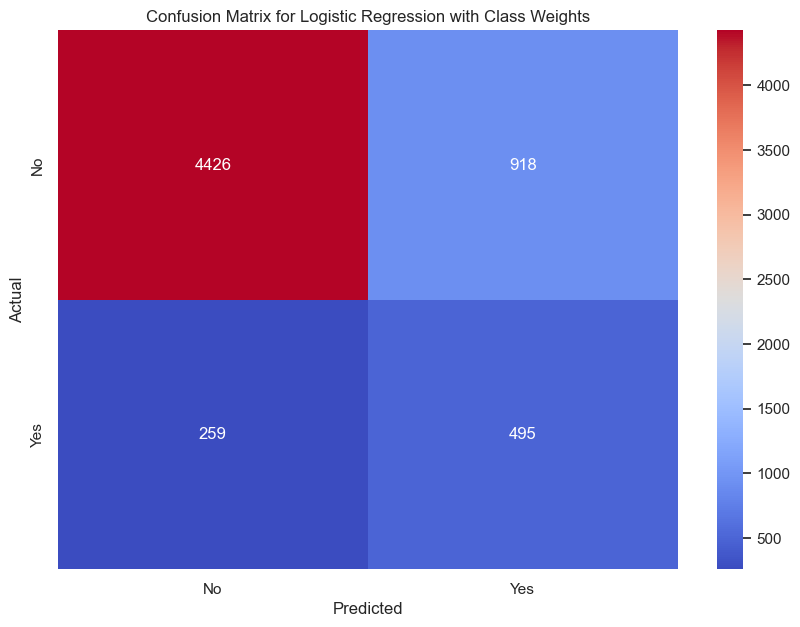

In [488]:
# Redefine the Logistic Regression model with class weights
log_reg = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')

# Train the model on the training data
log_reg.fit(X_train, y_train)

# Make predictions on the validation set
y_valid_pred = log_reg.predict(X_valid)

# Evaluate the model
accuracy = accuracy_score(y_valid, y_valid_pred)
print(f"Accuracy on validation set: {accuracy:.2f}")

# Classification Report
print("\nClassification Report:\n", classification_report(y_valid, y_valid_pred))

# Confusion Matrix
confusion_mat = confusion_matrix(y_valid, y_valid_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='coolwarm', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression with Class Weights')
plt.show()

Using class weights improved the recall (0.66) for `"y"`, but the overall accuracy decreased to 0.81. The precision for the minority class (0.35) remains low, indicating some misclassifications.

Now I perform hyperparameter tuning for the **Logistic Regression** model using GridSearchCV to find the optimal parameters for regularization strength (C) and solver. This aims to improve the model's accuracy and performance on the validation set by identifying the best configuration.

Best Parameters: {'C': 10, 'solver': 'liblinear'}
Accuracy on validation set: 0.81

Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.83      0.88      5344
         1.0       0.35      0.65      0.46       754

    accuracy                           0.81      6098
   macro avg       0.65      0.74      0.67      6098
weighted avg       0.87      0.81      0.83      6098



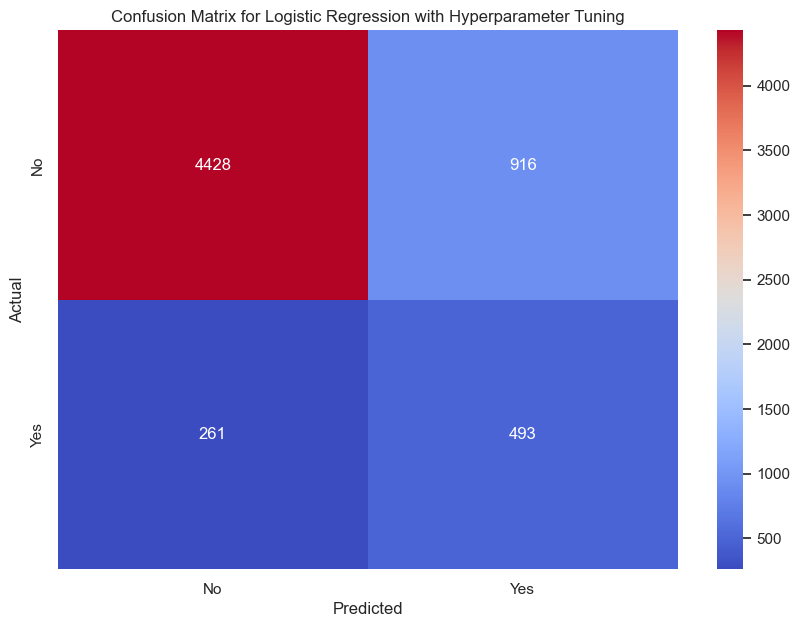

In [489]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

# Define the Logistic Regression model with class weights
log_reg = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print(f"Best Parameters: {best_params}")

# Make predictions on the validation set using the best model
y_valid_pred = best_model.predict(X_valid)

# Evaluate the best model
accuracy = accuracy_score(y_valid, y_valid_pred)
print(f"Accuracy on validation set: {accuracy:.2f}")

# Classification Report
print("\nClassification Report:\n", classification_report(y_valid, y_valid_pred))

# Confusion Matrix
confusion_mat = confusion_matrix(y_valid, y_valid_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='coolwarm', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression with Hyperparameter Tuning')
plt.show()

After hyperparameter tuning, the performance metrics for both the majority and minority classes **remain virtually unchanged** compared to the previous performance. The accuracy, recall, precision, and F1-scores have not shown significant improvement, suggesting that the hyperparameter tuning did not yield a better model configuration than before.

As with **Random Forest Classifier**, I plot some fancy graphs.

Starting from the **ROC curve**.

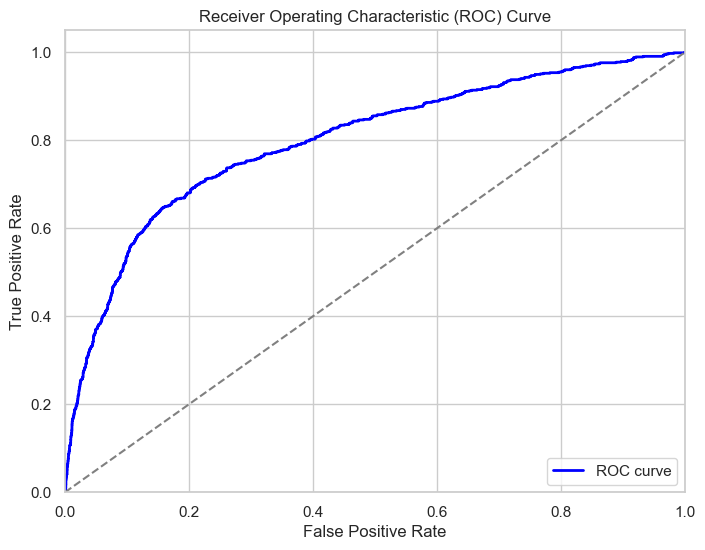

In [490]:
# Calculate probabilities for class 1
y_valid_prob = best_model.predict_proba(X_valid)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_valid, y_valid_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Then the **Precision-Recall** Curve.

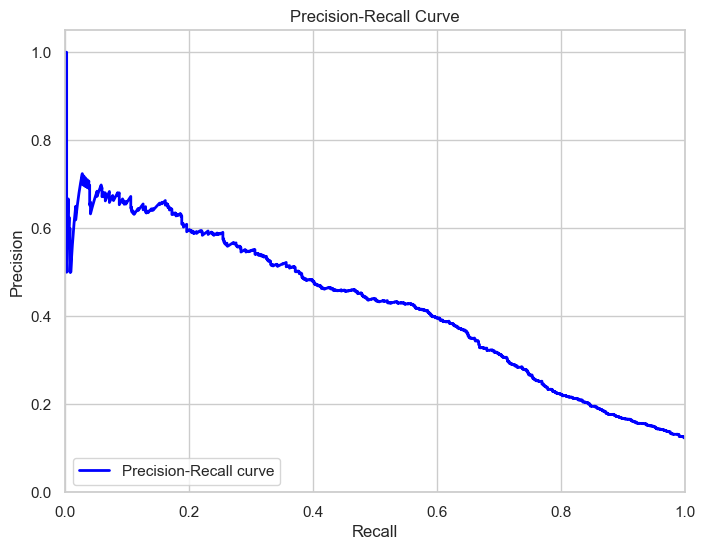

In [491]:
# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(y_valid, y_valid_prob)

# Calculate average precision score
average_precision = average_precision_score(y_valid, y_valid_prob)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

And the **Feature Importance** plot.

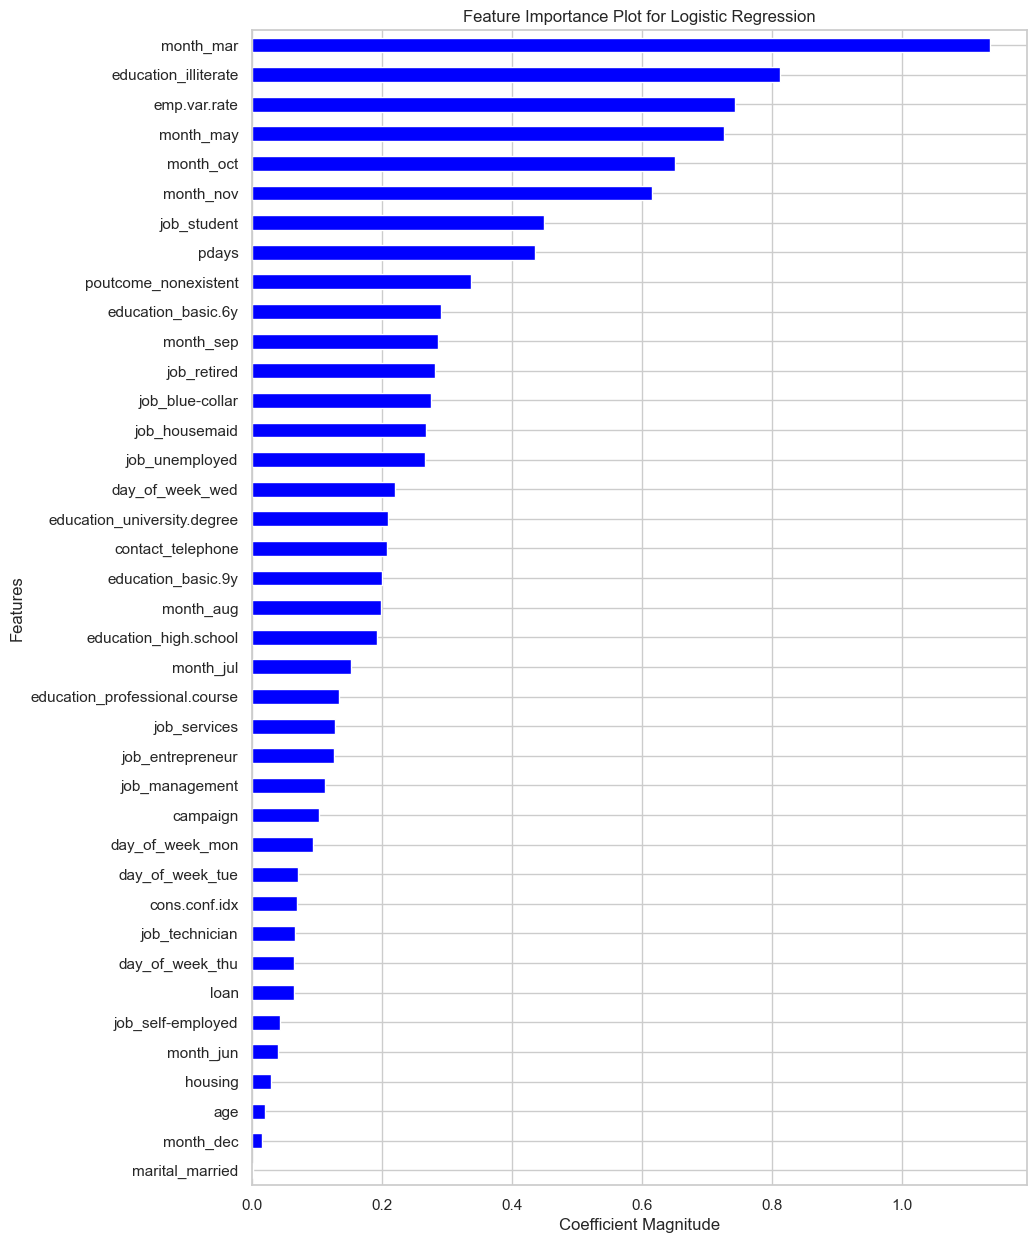

In [492]:
# Get feature coefficients
feature_coeffs = pd.Series(best_model.coef_[0], index=X_train.columns)

# Sort feature coefficients by absolute value
sorted_coeffs = feature_coeffs.abs().sort_values(ascending=False)

# Plot all feature coefficients horizontally
plt.figure(figsize=(10, 15))  # Adjust size as needed
sorted_coeffs.plot(kind='barh', color='blue')
plt.ylabel('Features')
plt.xlabel('Coefficient Magnitude')
plt.title('Feature Importance Plot for Logistic Regression')
plt.gca().invert_yaxis()
plt.show()

### **Neural Networks**

Now, I'm exploring **Neural Networks**, specifically the Multi-Layer Perceptron (MLP) classifier, to capture complex patterns in the data that other models may miss.

Accuracy on validation set: 0.88

Classification Report:
               precision    recall  f1-score   support

         0.0       0.91      0.96      0.93      5344
         1.0       0.53      0.33      0.41       754

    accuracy                           0.88      6098
   macro avg       0.72      0.64      0.67      6098
weighted avg       0.86      0.88      0.87      6098



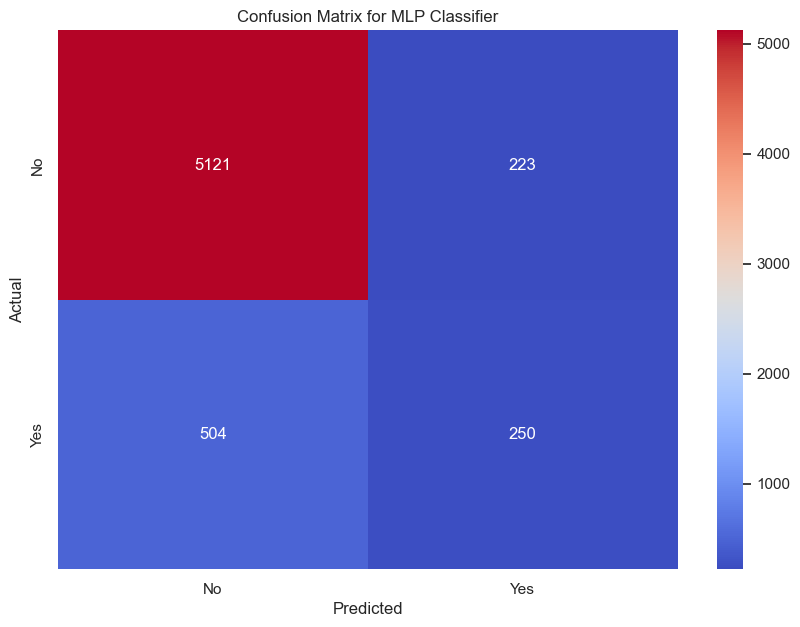

In [493]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Define the MLPClassifier model
mlp = MLPClassifier(hidden_layer_sizes=(100, ), activation='relu', solver='adam', 
                    alpha=0.0001, batch_size='auto', learning_rate='constant', 
                    learning_rate_init=0.001, max_iter=200, random_state=42)

# Fit the model on the training data
mlp.fit(X_train, y_train)

# Make predictions on the validation set
y_valid_pred = mlp.predict(X_valid)

# Evaluate the model
accuracy = accuracy_score(y_valid, y_valid_pred)
print(f"Accuracy on validation set: {accuracy:.2f}")

# Classification Report
print("\nClassification Report:\n", classification_report(y_valid, y_valid_pred))

# Confusion Matrix
confusion_mat = confusion_matrix(y_valid, y_valid_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='coolwarm', 
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for MLP Classifier')
plt.show()

The **MLP Classifier** achieved an accuracy of 0.88 on the validation set, with a higher precision and recall for the `"no"` compared to the `"yes"`. The model shows moderate performance overall, but there is room for improvement in correctly identifying the `"yes"`.

I  will optimize the **MLP Classifier**'s architecture and hyperparameters to enhance its ability to capture complex patterns in the data, aiming to improve overall performance metrics.

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (10,), 'max_iter': 400, 'solver': 'adam'}
Accuracy on validation set: 0.89

Classification Report:
               precision    recall  f1-score   support

         0.0       0.90      0.98      0.94      5344
         1.0       0.61      0.27      0.38       754

    accuracy                           0.89      6098
   macro avg       0.76      0.62      0.66      6098
weighted avg       0.87      0.89      0.87      6098



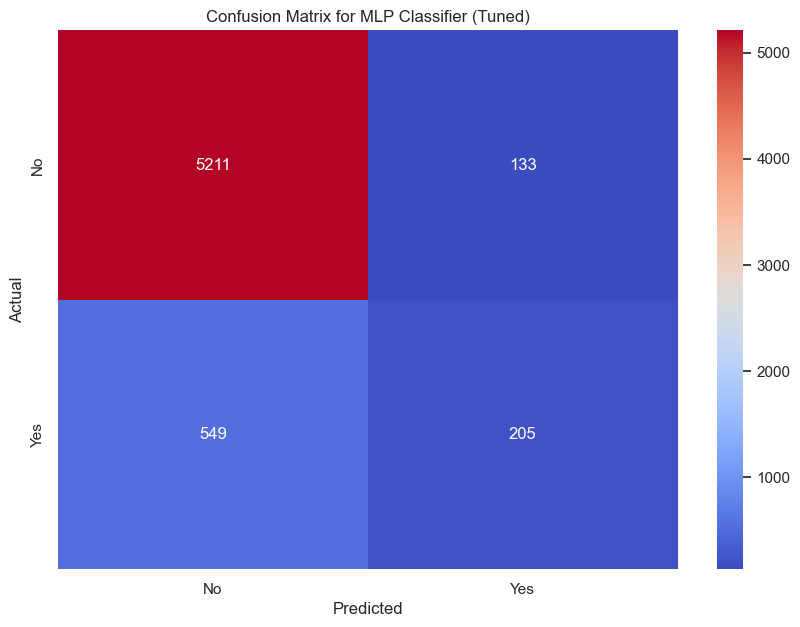

In [494]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'hidden_layer_sizes': [(10,)],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [0.01],
    'max_iter': [400],
}

# Define the MLPClassifier model
mlp = MLPClassifier(random_state=42)

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Make predictions on the validation set using the best model
y_valid_pred = best_model.predict(X_valid)

# Evaluate the best model
accuracy = accuracy_score(y_valid, y_valid_pred)
print(f"Accuracy on validation set: {accuracy:.2f}")

# Classification Report
print("\nClassification Report:\n", classification_report(y_valid, y_valid_pred))

# Confusion Matrix
confusion_mat = confusion_matrix(y_valid, y_valid_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='coolwarm', 
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for MLP Classifier (Tuned)')
plt.show()

The current **MLP Classifier** model with tuned parameters has marginally *improved accuracy* (from 0.88 to 0.89) but shows a *slight decrease in the F1-score* for class 1.0 (from 0.41 to 0.38). So, overall, the model's performance in correctly identifying the `"yes"` classes has slightly decreased.

And as for the others, I plot the **ROC Curve**.

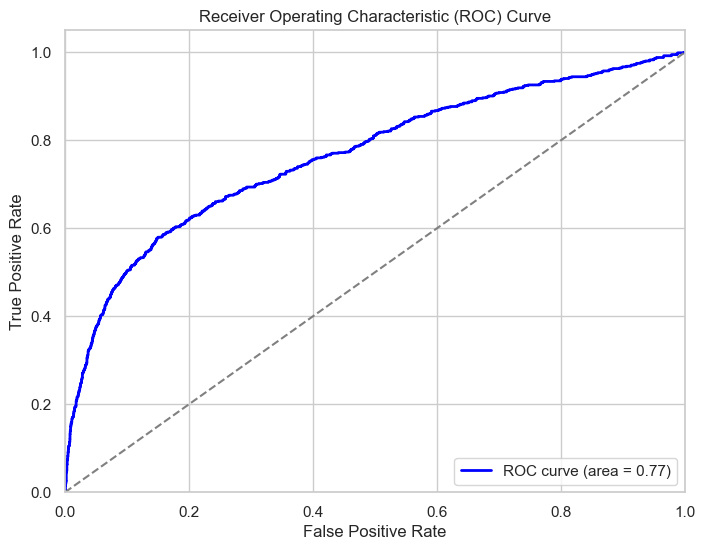

In [495]:
# Fit the model on the training data
mlp.fit(X_train, y_train)

# Now you can compute ROC curve and ROC area
from sklearn.metrics import roc_curve, roc_auc_score

# Compute probabilities for the positive class (class 1)
y_score = mlp.predict_proba(X_valid)[:, 1]

# Compute ROC curve and ROC area under curve
fpr, tpr, _ = roc_curve(y_valid, y_score)
roc_auc = roc_auc_score(y_valid, y_score)

# Plot ROC curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

The **Precision-Recall Curve**.

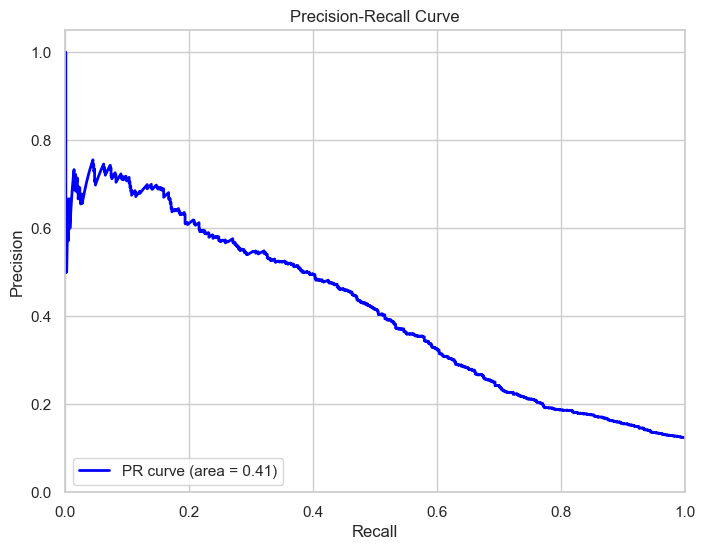

In [496]:
# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_valid, y_score)
pr_auc = auc(recall, precision)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='PR curve (area = {:.2f})'.format(pr_auc))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

And the **Feature Importance** graph.

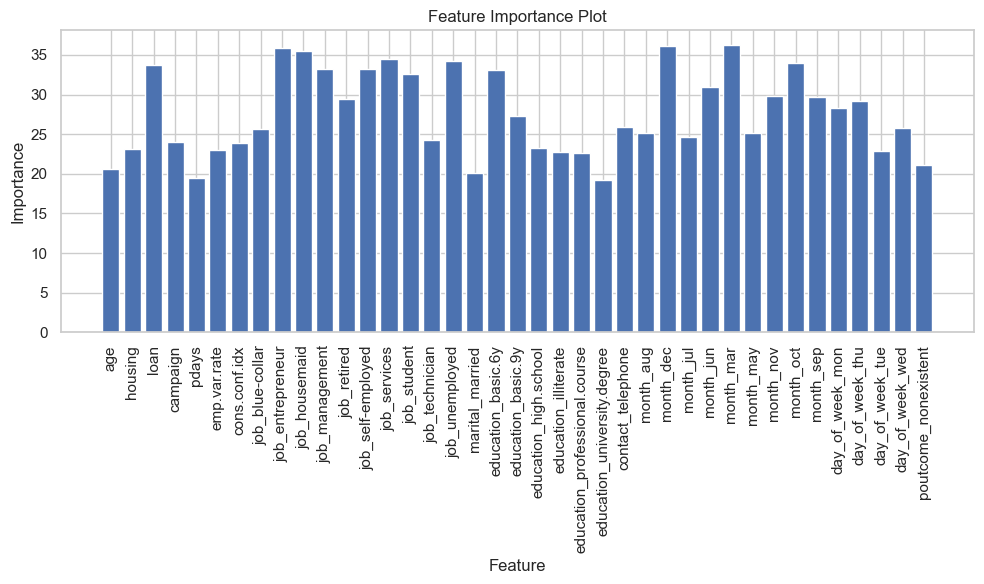

In [497]:
weights_input_hidden = mlp.coefs_[0]

# Compute feature importances by taking the absolute sum of weights for each feature across all neurons in the hidden layer
feature_importances = np.abs(weights_input_hidden).sum(axis=1)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances, align='center')
plt.xticks(range(len(feature_importances)), X_train.columns, rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance Plot')
plt.tight_layout()
plt.show()

## **5. Conclusions**

The four Machine Learning models used showed different performances.

Each model was evaluated using performance metrics such as accuracy, precision, recall, and F1-score. 

The **Random Forest Classifier** and **Logistic Regression** generally showed better performance on *F1-Score* for the *“yes”* class while **Decision Tree Classifier** and **Neural Networks** showed higher general *accuracy*.

- The **Random Forest** achieved a balance between high precision and recall, especially for the “yes” class, with an overall accuracy of 0.82. 

- **Neural Networks** demonstrated strong performance with an accuracy of 0.88, though struggled with recall for the minority class. 

- **Decision Trees**, while interpretable, had lower recall for the “yes”. 

- **Logistic Regression** offered a good baseline with an accuracy of 0.81 but similarly faced challenges with recall. 

Ultimately, ensemble methods like **Random Forest** and complex models like **Neural Networks** provided superior performance in capturing intricate patterns within the data, while the *challenge* was handling the imbalance between “yes” and “no” outcomes for the target variable `y`. 

**Logistic Regression** and **Neural Networks** showed a more complete feature importance given to each feature, while **Decision Tree** and **Random Forest Classifiers** lacked in taking into account the importance of the whole feature set.